# <span style="color: cyan;"> Setup</span>

## Import Packages (or install)

In [3]:
!pip install h5py
!pip install astropy
!pip install scipy
!pip install pycwt
!pip install pandas
!pip install statsmodels


In [4]:
import h5py
import pycwt as wavelet
import numpy as np
import scipy
import matplotlib.pyplot as plt
import astropy.units as unit
import astropy.constants as cons
from astropy.time import Time 
from datetime import datetime, timedelta

import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator
from scipy.stats import pearsonr
import pandas as pd
from pathlib import Path
import time
filePath = "../data/PlanetaryEphemerides.h5"

solar_mass = 1.989e30 # kg

__ANGLE_LIMIT_LOWER__ = 86
__ANGLE_LIMIT_HIGHER__ = 94

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='erfa')

class FancyColors:
    TEST = "\033[1;4;93;41m"
    RESET = "\033[0m"
    IMPORTANT = "\033[1;4;96;41m"

    RED = "\033[31m"
    GREEN = "\033[32m"
    YELLOW = "\033[33m"
    BLUE = "\033[34m"
    MAGENTA = "\033[35m"
    CYAN = "\033[36m"

plot_facecolor = (0.902, 0.902, 0.902)

## Define Statistics

In [5]:
def circ_lin_r(angle, y):
    angle = np.asarray(angle)
    y = np.asarray(y)
    x = (y - y.mean()) / y.std()
    c = np.cos(angle)
    s = np.sin(angle)
    r_xc = pearsonr(x, c)[0]
    r_xs = pearsonr(x, s)[0]
    r_cs = pearsonr(c, s)[0]
    return np.sqrt((r_xc**2 + r_xs**2 - 2*r_xc*r_xs*r_cs) / (1 - r_cs**2 + 1e-15)), x, c, s, r_cs

def sweep_lag_circ_lin(
    t_angle, angle, t_y, y, 
    lags,                      # iterable of lags in same units as t_* (e.g., days)
    L=30,                      # block length for perms (≈ autocorr time)
    n_perm=2000
):
    # Make DataFrames to inner-join on time after lagging
    da = pd.DataFrame({"t": t_angle, "angle": angle})
    dy0 = pd.DataFrame({"t": t_y, "y": y}).sort_values("t").reset_index(drop=True)

    results = []
    for lag in lags:
        # shift y in time by 'lag': y(t+lag)
        dy = dy0.copy()
        dy["t"] = dy["t"] + lag
        merged = pd.merge(da, dy, on="t", how="inner")
        if len(merged) < 10:
            results.append({"lag": lag, "r": np.nan})
            continue
        r,_,_,_,_ = circ_lin_r(merged["angle"].values, merged["y"].values)
        results.append({"lag": lag, "r": r})
    res = pd.DataFrame(results)
    if res["r"].notna().sum() == 0:
        return {"table": res, "best_lag": np.nan, "best_r": np.nan, "p_fwe": np.nan}

    # Observed max statistic across lags
    best_idx = res["r"].idxmax()
    obs_max_r = res.loc[best_idx, "r"]

    # --- max-T block-permutation (family-wise error across lags) ---
    # Build block indices on the original (unshifted) y to preserve autocorr
    W = len(dy0)
    idx = np.arange(W)
    blocks = [idx[i:i+L] for i in range(0, W, L)]

    max_r_perm = []
    y_arr = dy0["y"].values
    for _ in range(n_perm):
        order = np.random.permutation(len(blocks))
        pidx = np.concatenate([blocks[i] for i in order])
        dy_p = dy0.copy()
        dy_p["y"] = y_arr[pidx]

        max_r_this_perm = -np.inf
        for lag in lags:
            dyp = dy_p.copy()
            dyp["t"] = dyp["t"] + lag
            merged = pd.merge(da, dyp, on="t", how="inner")
            if len(merged) < 10:
                continue
            r_p,_,_,_,_ = circ_lin_r(merged["angle"].values, merged["y"].values)
            if r_p > max_r_this_perm:
                max_r_this_perm = r_p
        if np.isfinite(max_r_this_perm):
            max_r_perm.append(max_r_this_perm)

    # Family-wise p-value: fraction of permuted max-r >= observed max-r
    if len(max_r_perm) == 0:
        p_fwe = np.nan
    else:
        max_r_perm = np.asarray(max_r_perm)
        p_fwe = (np.sum(max_r_perm >= obs_max_r) + 1) / (len(max_r_perm) + 1)

    return {
        "table": res.sort_values("lag").reset_index(drop=True),
        "best_lag": res.loc[best_idx, "lag"],
        "best_r": obs_max_r,
        "p_fwe": p_fwe,  # corrected for multiple lags
    }

def circ_lin_corr(angle, y):

    r, x, c, s, r_cs = circ_lin_r(angle, y)

    # --- Block permutation p-value (choose block length L ~ dominant autocorr time) ---
    def block_perm_corr(x, c, s, r_cs, L=30, n_perm=5000):
        W = len(x)
        idx = np.arange(W)
        blocks = [idx[i:i+L] for i in range(0, W, L)]
        obs = r
        cnt = 0
        for _ in range(n_perm):
            # shuffle blocks
            order = np.random.permutation(len(blocks))
            pidx = np.concatenate([blocks[i] for i in order])
            xp = x[pidx]
            r_xc_p = pearsonr(xp, c)[0]
            r_xs_p = pearsonr(xp, s)[0]
            r_p = np.sqrt((r_xc_p**2 + r_xs_p**2 - 2*r_xc_p*r_xs_p*r_cs) / (1 - r_cs**2))
            cnt += (r_p >= obs)
        return (cnt+1)/(n_perm+1)

    p_vals = []
    for L in [10,20,30,40,60,80,120]:
        p_vals.append(block_perm_corr(x, c, s, r_cs, L=30, n_perm=2000))
    return {"pearsonr":r, "pscore":np.mean(p_vals)}

def wavelet_cross_analysis(x, y, dt, mother=wavelet.Morlet(6), dj=1/12, s0=None, J=None):
    """
    Compute individual CWTs, cross-wavelet transform (XWT),
    coherence (WCT), phase, and time delay using native pycwt.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # --- Define scales ---
    if s0 is None:
        s0 = 2 * dt
    if J is None:
        J = int(np.log2(len(x) * dt / s0) / dj)

    # --- Individual continuous wavelet transforms ---
    Wx, scales, freqs, coi_x, _, _ = wavelet.cwt(x, dt, dj, s0, J, mother)
    Wy, _, _, coi_y, _, _ = wavelet.cwt(y, dt, dj, s0, J, mother)
    period = 1 / freqs
    coi = np.minimum(coi_x, coi_y)  # conservative COI

    # --- Cross-wavelet transform (XWT) ---
    Wxy = Wx * np.conj(Wy)
    xwt_power = np.abs(Wxy)

    # --- Wavelet coherence (WCT) ---
    WCT, aWCT, coi_wct, freq_wct, sig = wavelet.wct(x, y, dt, dj=dj, s0=s0, J=J, mother=mother, sig = False) # Disable monte-carlo simulation with sig=False

    # --- Phase and delay ---
    phase = np.angle(aWCT)
    delay = (phase / (2 * np.pi)) * (1 / freq_wct)[:, None]

    return {
        "period": period,
        "freq": freqs,
        "Wx": Wx,
        "Wy": Wy,
        "Wxy": Wxy,
        "xwt": xwt_power,
        "wtc": WCT,
        "aWCT": aWCT,
        "phase": phase,
        "delay": delay,
        "sig": sig,
        "coi": coi,
        "coi_wct": coi_wct,
    }

def variance_ratio_scan(array, interval1_size: int = 10, interval2_size: int = 5, inverse: bool = False):
    """
    Computes running variance ratios across an array with circular wrapping.
    
    Parameters:
    -----------
    array : numpy array
        The input data array
    interval_size : int
        The size of each interval for variance computation
    
    Returns:
    --------
    ratios : numpy array
        Array of variance ratios (variance of second interval / variance of first interval)
    """
    n = len(array)
    ratios = np.zeros(n)

    for i in range(n):
        # Define first interval starting at index i
        interval1_indices = np.arange(i, i + interval1_size) % n
        interval1 = array[interval1_indices]

        # Define second interval starting at index i + interval1_size
        interval2_indices = np.arange(i + interval1_size, i + interval1_size + interval2_size) % n
        interval2 = array[interval2_indices]

        # Compute variances
        var1 = np.var(interval1)
        var2 = np.var(interval2)

        # Compute ratio (handle division by zero)
        if not inverse:
            if var1 != 0:
                ratios[i] = var2 / var1
            else:
                ratios[i] = np.nan  # or np.inf, depending on your preference
        else:
            if var2 != 0 :
                ratios[i] = var1 / var2
            else:
                ratios[i] = np.nan

    return ratios

def angle_window_variance_ratio(time_array, angle_array, data_array, 
                                  angle_min, angle_max, pre_steps, inverse: bool = False):
    """
    Computes variance ratios for data during angle windows vs pre-window periods.
    """
    # Find indices where angle is within the specified range
    in_window = (angle_array >= angle_min) & (angle_array <= angle_max)

    # Find contiguous windows
    windows = []
    start_idx = None

    for i in range(len(angle_array)):
        if in_window[i] and start_idx is None:
            # Start of a new window
            start_idx = i
        elif not in_window[i] and start_idx is not None:
            # End of a window
            windows.append((start_idx, i - 1))
            start_idx = None

    # Handle case where window extends to end of array
    if start_idx is not None:
        windows.append((start_idx, len(angle_array) - 1))

    # Compute variance ratios for each window
    window_info = []
    pre_data = None

    for start, end in windows:
        # Variance during the window
        window_data = data_array[start:end+1]
        var_during = np.var(window_data)

        # Variance before the window (pre_steps timesteps before start)
        pre_start = start - pre_steps
        pre_end = start - 1

        if pre_start >= 0:
            pre_data = data_array[pre_start:pre_end+1]
            var_before = np.var(pre_data)

            # Compute ratio
            if not inverse:
                if var_before != 0:
                    ratio = var_during / var_before
                elif (var_during == 0) & (var_before == 0):
                    ratio = 0
                else:
                    ratio = np.nan
            else:
                if var_during != 0:
                    ratio = var_before / var_during
                elif (var_during == 0 ) & (var_before == 0):
                    ratio = 0
                else:
                    ratio = np.nan
        else:
            # Not enough data before window
            ratio = np.nan

        window_info.append({
            'start_idx': start,
            'end_idx': end,
            'pre_start_idx': pre_start,
            'ratio': ratio,
            'start_time': time_array[start],
            'end_time': time_array[end],
            'var_during': var_during,
            'var_before': var_before if pre_start >= 0 else np.nan,
            'window_data': window_data,
            'pre_data': pre_data if len(windows)>0 else None
        })

    return window_info

def angle_window_variance_ratio_post(time_array, angle_array, data_array, 
                                    angle_min, angle_max, post_steps, inverse: bool = False):
    """
    Computes variance ratios for data during angle windows vs post-window periods.
    """
    # Find indices where angle is within the specified range
    in_window = (angle_array >= angle_min) & (angle_array <= angle_max)

    # Find contiguous windows
    windows = []
    start_idx = None

    for i in range(len(angle_array)):
        if in_window[i] and start_idx is None:
            # Start of a new window
            start_idx = i
        elif not in_window[i] and start_idx is not None:
            # End of a window
            windows.append((start_idx, i - 1))
            start_idx = None

    # Handle case where window extends to end of array
    if start_idx is not None:
        windows.append((start_idx, len(angle_array) - 1))

    # Compute variance ratios for each window
    window_info = []
    post_data = None

    for start, end in windows:
        # Variance during the window
        window_data = data_array[start:end+1]
        var_during = np.var(window_data)

        # Variance after the window (post_steps timesteps after end)
        post_start = end
        post_end = end + post_steps

        if post_end < len(data_array):
            post_data = data_array[post_start:post_end]
            var_after = np.var(post_data)

            # Compute ratio
            if not inverse:
                if var_after != 0:
                    ratio = var_during / var_after
                elif (var_during == 0) & (var_after == 0):
                    ratio = 0
                else:
                    ratio = np.nan
            else:
                if var_during != 0:
                    ratio = var_after / var_during
                elif (var_during == 0) & (var_after == 0):
                    ratio = 0
                else:
                    ratio = np.nan
        else:
            # Not enough data after window
            ratio = np.nan
            post_data = np.array([])
            var_after = np.nan

        window_info.append({
            'start_idx': start,
            'end_idx': end,
            'post_end_idx': post_end,
            'ratio': ratio,
            'start_time': time_array[start],
            'end_time': time_array[end],
            'var_during': var_during,
            'var_after': var_after,
            'window_data': window_data,
            'post_data': post_data
        })

    return window_info

def angle_window_post_event_difference(time_array, angle_array, data_array,
                                       angle_min, angle_max, 
                                       weeks_after, 
                                       n_points_at_end=1,
                                       n_points_after=1):
    """
    Computes the difference between data mean at event end vs X weeks after event end.
    
    Parameters:
    -----------
    time_array : numpy array
        Time series in Julian dates
    angle_array : numpy array
        Angle values corresponding to time_array
    data_array : numpy array
        Data values corresponding to time_array
    angle_min : float
        Minimum angle defining the event window (default 86 degrees)
    angle_max : float
        Maximum angle defining the event window (default 94 degrees)
    weeks_after : int
        Number of weeks after event end to compare
    n_points_at_end : int
        Number of points to average around event end (1 = single point)
    n_points_after : int
        Number of points to average around X-weeks-after point
        
    Returns:
    --------
    event_info : list of dicts
        Each dict contains:
        - end_idx: Index where event ends
        - end_time: Time when event ends
        - mean_at_end: Mean of data at event end
        - mean_after: Mean of data X weeks after
        - difference: mean_after - mean_at_end
        - std_at_end: Standard deviation at event end
        - std_after: Standard deviation X weeks after
        - error: Propagated error of the difference
        - data_at_end: Data points used for mean at end
        - data_after: Data points used for mean after
    """
    # Find indices where angle is within the specified range
    in_window = (angle_array >= angle_min) & (angle_array <= angle_max)
    
    # Find contiguous windows
    windows = []
    start_idx = None
    
    for i in range(len(angle_array)):
        if in_window[i] and start_idx is None:
            start_idx = i
        elif not in_window[i] and start_idx is not None:
            windows.append((start_idx, i - 1))
            start_idx = None
    
    if start_idx is not None:
        windows.append((start_idx, len(angle_array) - 1))
    
    event_info = []
    
    for start, end in windows:
        end_idx = end
        
        # Compute indices for averaging at event end
        if n_points_at_end == 1:
            idx_at_end = [end_idx]
        else:
            half_window = n_points_at_end // 2
            idx_at_end = list(range(end_idx - half_window, end_idx + half_window + 1))
            idx_at_end = [i for i in idx_at_end if 0 <= i < len(data_array)]
        
        # Compute mean and std at event end
        data_at_end = data_array[idx_at_end]
        mean_at_end = np.nanmean(data_at_end)
        std_at_end = np.nanstd(data_at_end)
        
        # Find index X weeks after event end
        # Assuming daily data: weeks_after * 7 days
        days_after = int(weeks_after * 7)
        after_idx = end_idx + days_after
        
        if after_idx >= len(data_array):
            # Not enough data after event
            event_info.append({
                'end_idx': end_idx,
                'after_idx': after_idx,
                'start_time': time_array[end_idx],
                'end_time': time_array[after_idx],
                'mean_at_end': mean_at_end,
                'mean_after': np.nan,
                'difference': np.nan,
                'std_at_end': std_at_end,
                'std_after': np.nan,
                'error': np.nan,
                'data_at_end': data_at_end,
                'data_after': np.array([])
            })
            continue
        
        # Compute indices for averaging X weeks after
        if n_points_after == 1:
            idx_after = [after_idx]
        else:
            half_window = n_points_after // 2
            idx_after = list(range(after_idx - half_window, after_idx + half_window + 1))
            idx_after = [i for i in idx_after if 0 <= i < len(data_array)]
        
        # Compute mean and std X weeks after
        data_after = data_array[idx_after]
        mean_after = np.nanmean(data_after)
        std_after = np.nanstd(data_after)
        
        # Compute difference
        difference = mean_after - mean_at_end
        
        # Propagate error (assuming independent measurements)
        n_at_end = len(data_at_end)
        n_after = len(data_after)
        error_at_end = std_at_end / np.sqrt(n_at_end) if n_at_end > 0 else np.nan
        error_after = std_after / np.sqrt(n_after) if n_after > 0 else np.nan
        error = np.sqrt(error_at_end**2 + error_after**2)
        
        event_info.append({
            'end_idx': end_idx,
            'after_idx': after_idx,
            'start_time': time_array[end_idx],
            'end_time': time_array[after_idx],
            'mean_at_end': mean_at_end,
            'mean_after': mean_after,
            'difference': difference,
            'std_at_end': std_at_end,
            'std_after': std_after,
            'error': error,
            'data_at_end': data_at_end,
            'data_after': data_after
        })
    
    return event_info

def angle_window_pre_event_difference(time_array, angle_array, data_array,
                                       angle_min, angle_max, 
                                       weeks_before, 
                                       n_points_at_start=1,
                                       n_points_before=1):
    """
    Computes the difference between data mean at event end vs X weeks after event end.
    
    Parameters:
    -----------
    time_array : numpy array
        Time series in Julian dates
    angle_array : numpy array
        Angle values corresponding to time_array
    data_array : numpy array
        Data values corresponding to time_array
    angle_min : float
        Minimum angle defining the event window (default 86 degrees)
    angle_max : float
        Maximum angle defining the event window (default 94 degrees)
    weeks_after : int
        Number of weeks after event end to compare
    n_points_at_end : int
        Number of points to average around event end (1 = single point)
    n_points_after : int
        Number of points to average around X-weeks-after point
        
    Returns:
    --------
    event_info : list of dicts
        Each dict contains:
        - end_idx: Index where event ends
        - end_time: Time when event ends
        - mean_at_end: Mean of data at event end
        - mean_after: Mean of data X weeks after
        - difference: mean_after - mean_at_end
        - std_at_end: Standard deviation at event end
        - std_after: Standard deviation X weeks after
        - error: Propagated error of the difference
        - data_at_end: Data points used for mean at end
        - data_after: Data points used for mean after
    """
    # Find indices where angle is within the specified range
    in_window = (angle_array >= angle_min) & (angle_array <= angle_max)
    
    # Find contiguous windows
    windows = []
    start_idx = None
    
    for i in range(len(angle_array)):
        if in_window[i] and start_idx is None:
            start_idx = i
        elif not in_window[i] and start_idx is not None:
            windows.append((start_idx, i - 1))
            start_idx = None
    
    if start_idx is not None:
        windows.append((start_idx, len(angle_array) - 1))
    
    event_info = []
    
    for start, end in windows:
        start_idx = start
        
        # Compute indices for averaging at event end
        if n_points_at_start == 1:
            idx_at_start = [start_idx]
        else:
            half_window = n_points_at_start // 2
            idx_at_start = list(range(start_idx - half_window, start_idx + half_window + 1))
            idx_at_start = [i for i in idx_at_start if 0 <= i < len(data_array)]
        
        # Compute mean and std at event end
        data_at_start = data_array[idx_at_start]
        mean_at_start = np.nanmean(data_at_start)
        std_at_start = np.nanstd(data_at_start)
        
        # Find index X weeks after event end
        # Assuming daily data: weeks_after * 7 days
        days_before = int(weeks_before * 7)
        before_idx = start_idx - days_before
        
        if before_idx <=0:
            # Not enough data after event
            event_info.append({
                'start_idx': start_idx,
                'before_idx': before_idx,
                'start_time': time_array[before_idx],
                'end_time': time_array[start_idx],
                'mean_at_start': mean_at_start,
                'mean_before': np.nan,
                'difference': np.nan,
                'std_at_start': std_at_start,
                'std_before': np.nan,
                'error': np.nan,
                'data_at_start': data_at_start,
                'data_before': np.array([])
            })
            continue
        
        # Compute indices for averaging X weeks after
        if n_points_before == 1:
            idx_before = [before_idx]
        else:
            half_window = n_points_before // 2
            idx_before = list(range(before_idx - half_window, before_idx + half_window + 1))
            idx_before = [i for i in idx_before if 0 <= i < len(data_array)]
        
        # Compute mean and std X weeks after
        data_before = data_array[idx_before]
        mean_before = np.nanmean(data_before)
        std_before = np.nanstd(data_before)
        
        # Compute difference
        difference = mean_at_start - mean_before
        
        # Propagate error (assuming independent measurements)
        n_at_start = len(data_at_start)
        n_before = len(data_before)
        error_at_start = std_at_start / np.sqrt(n_at_start) if n_at_start > 0 else np.nan
        error_before = std_before / np.sqrt(n_before) if n_before > 0 else np.nan
        error = np.sqrt(error_at_start**2 + error_before**2)
        
        event_info.append({
            'start_idx': start_idx,
            'before_idx': before_idx,
            'start_time': time_array[before_idx],
            'end_time': time_array[start_idx],
            'mean_at_start': mean_at_start,
            'mean_before': mean_before,
            'difference': difference,
            'std_at_start': std_at_start,
            'std_before': std_before,
            'error': error,
            'data_at_start': data_at_start,
            'data_before': data_before
        })
    
    return event_info

def angle_window_post_event_gradient(time_array, angle_array, data_array,
                                     angle_min, angle_max,
                                     weeks_after,
                                     error_window=5):
    """
    Computes the average gradient from event end to X weeks after event end.

    Parameters:
    -----------
    time_array : numpy array
        Time series in Julian dates
    angle_array : numpy array
        Angle values corresponding to time_array
    data_array : numpy array
        Data values corresponding to time_array
    angle_min : float
        Minimum angle defining the event window
    angle_max : float
        Maximum angle defining the event window
    weeks_after : int
        Number of weeks after event end to compute gradient
    error_window : int, optional
        Number of points around each endpoint to use for error estimation (default=5)
        Set to 0 to disable error computation

    Returns:
    --------
    event_info : list of dicts
        Each dict contains:
        - end_idx: Index where event ends
        - end_time: Time when event ends
        - after_idx: Index X weeks after
        - after_time: Time X weeks after
        - gradient: Average gradient (change in data per day)
        - gradient_per_week: Gradient in units per week
        - gradient_error: Error in gradient (per day)
        - gradient_error_per_week: Error in gradient (per week)
        - data_at_end: Data value at event end
        - data_after: Data value X weeks after
        - std_at_end: Standard deviation at event end
        - std_after: Standard deviation X weeks after
        - delta_data: Change in data
        - delta_time: Time interval in days
    """
    # Find indices where angle is within the specified range
    in_window = (angle_array >= angle_min) & (angle_array <= angle_max)

    # Find contiguous windows
    windows = []
    start_idx = None

    for i in range(len(angle_array)):
        if in_window[i] and start_idx is None:
            start_idx = i
        elif not in_window[i] and start_idx is not None:
            windows.append((start_idx, i - 1))
            start_idx = None

    if start_idx is not None:
        windows.append((start_idx, len(angle_array) - 1))

    event_info = []

    for start, end in windows:
        end_idx = end

        # Find index X weeks after event end
        days_after = weeks_after * 7
        after_idx = end_idx + days_after

        if after_idx >= len(data_array):
            # Not enough data after event
            event_info.append({
                'end_idx': end_idx,
                'end_time': time_array[end_idx],
                'after_idx': np.nan,
                'after_time': np.nan,
                'gradient': np.nan,
                'gradient_per_week': np.nan,
                'gradient_error': np.nan,
                'gradient_error_per_week': np.nan,
                'data_at_end': data_array[end_idx],
                'data_after': np.nan,
                'std_at_end': np.nan,
                'std_after': np.nan,
                'delta_data': np.nan,
                'delta_time': np.nan
            })
            continue

        # Get data and time values
        data_at_end = data_array[end_idx]
        data_after = data_array[after_idx]
        time_at_end = time_array[end_idx]
        time_after = time_array[after_idx]

        # Compute local standard deviations for error estimation
        if error_window > 0:
            # Get window around end point
            half_window = error_window // 2
            idx_at_end = list(range(end_idx - half_window, end_idx + half_window + 1))
            idx_at_end = [i for i in idx_at_end if 0 <= i < len(data_array)]

            # Get window around after point
            idx_after = list(range(after_idx - half_window, after_idx + half_window + 1))
            idx_after = [i for i in idx_after if 0 <= i < len(data_array)]

            # Compute standard deviations
            data_window_end = data_array[idx_at_end]
            data_window_after = data_array[idx_after]

            std_at_end = np.nanstd(data_window_end)
            std_after = np.nanstd(data_window_after)

            # Standard errors
            n_at_end = len(data_window_end)
            n_after = len(data_window_after)
            se_at_end = std_at_end / np.sqrt(n_at_end) if n_at_end > 0 else np.nan
            se_after = std_after / np.sqrt(n_after) if n_after > 0 else np.nan
        else:
            std_at_end = np.nan
            std_after = np.nan
            se_at_end = np.nan
            se_after = np.nan

        # Compute gradient
        delta_data = data_after - data_at_end
        delta_time = time_after - time_at_end  # in days (Julian dates)

        gradient = delta_data / delta_time if delta_time != 0 else np.nan
        gradient_per_week = gradient * 7  # Convert to per week

        # Compute gradient error: σ_g = sqrt(σ_end^2 + σ_after^2) / Δt
        if error_window > 0 and delta_time != 0:
            gradient_error = np.sqrt(se_at_end**2 + se_after**2) / delta_time
            gradient_error_per_week = gradient_error * 7
        else:
            gradient_error = np.nan
            gradient_error_per_week = np.nan

        event_info.append({
            'end_idx': end_idx,
            'end_time': time_at_end,
            'after_idx': after_idx,
            'after_time': time_after,
            'gradient': gradient,
            'gradient_per_week': gradient_per_week,
            'gradient_error': gradient_error,
            'gradient_error_per_week': gradient_error_per_week,
            'data_at_end': data_at_end,
            'data_after': data_after,
            'std_at_end': std_at_end,
            'std_after': std_after,
            'delta_data': delta_data,
            'delta_time': delta_time
        })

    return event_info

def random_span_difference_null_distribution(data_array, 
                                                    span_weeks=4, 
                                                    n_local_points=1, 
                                                    n_trials=1000,
                                                    random_seed=None):
    """
    Generates a null distribution by computing differences over random time spans.
    
    This function randomly selects time periods of a specified length and computes
    the difference between locally-averaged values at the start and end of each span.
    This creates a null distribution for comparison with event-based differences.
    
    Parameters:
    -----------
    data_array : numpy array
        The data time series
    span_weeks : int
        Length of each random span in weeks (default=4)
    n_local_points : int
        Number of points to average at start and end of span (default=1)
        If 1, uses single point; if >1, uses centered window
    n_trials : int
        Number of random trials to perform (default=1000)
    random_seed : int, optional
        Seed for random number generator for reproducibility
        
    Returns:
    --------
    result : dict
        Dictionary containing:
        - differences: array of all computed differences
        - percent_positive: percentage of differences > 0
        - percent_negative: percentage of differences < 0
        - percent_zero: percentage of differences == 0
        - mean_difference: mean of all differences
        - std_difference: standard deviation of differences
        - median_difference: median of differences
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    data_array = np.asarray(data_array)
    n_data = len(data_array)
    span_days = span_weeks * 7

    # Need enough data for span plus local averaging windows
    half_window = n_local_points // 2
    min_required = span_days + 2 * half_window

    if n_data < min_required:
        raise ValueError(f"Data array too short. Need at least {min_required} points.")

    differences = []

    for _ in range(n_trials):
        # Randomly select start of span
        # Ensure we have room for the span and local averaging windows
        max_start = n_data - span_days - half_window
        if max_start < half_window:
            raise ValueError("Not enough data for the specified span and averaging window.")

        start_idx = np.random.randint(half_window, max_start)
        end_idx = start_idx + span_days

        # Compute local average at start
        if n_local_points == 1:
            idx_at_start = [start_idx]
        else:
            idx_at_start = list(range(start_idx - half_window, start_idx + half_window + 1))
            idx_at_start = [i for i in idx_at_start if 0 <= i < n_data]

        data_at_start = data_array[idx_at_start]
        mean_at_start = np.nanmean(data_at_start)

        # Compute local average at end
        if n_local_points == 1:
            idx_at_end = [end_idx]
        else:
            idx_at_end = list(range(end_idx - half_window, end_idx + half_window + 1))
            idx_at_end = [i for i in idx_at_end if 0 <= i < n_data]

        data_at_end = data_array[idx_at_end]
        mean_at_end = np.nanmean(data_at_end)

        # Compute difference (end - start)
        difference = mean_at_end - mean_at_start
        differences.append(difference)

    differences = np.array(differences)

    # Compute statistics
    n_positive = np.sum(differences > 0)
    n_negative = np.sum(differences < 0)
    n_zero = np.sum(differences == 0)

    percent_positive = 100 * n_positive / n_trials
    percent_negative = 100 * n_negative / n_trials
    percent_zero = 100 * n_zero / n_trials

    return {
        'differences': differences,
        'percent_positive': percent_positive,
        'percent_negative': percent_negative,
        'percent_zero': percent_zero,
        'mean_difference': np.mean(differences),
        'std_difference': np.std(differences),
        'median_difference': np.median(differences),
        'n_trials': n_trials
    }

def random_span_variance_ratio_null_distribution(data_array, 
                                                pre_ratio_windows,
                                                post_ratio_windows,
                                                span_days=7, 
                                                lookback_days=7,
                                                lookforward_days=7,
                                                n_trials=1000,
                                                random_seed=None):
    """
    Generates a null distribution of variance ratios over random time spans.
    
    Randomly selects time spans and computes:
    - pre_ratio: var(span) / var(lookback_days before span)
    - post_ratio: var(span) / var(lookforward_days after span)
    
    Parameters:
    -----------
    data_array : numpy array
        The data time series
    span_days : int
        Length of each random span in days (default=7)
    lookback_days : int
        Number of days before span to compute comparison variance (default=7)
    lookforward_days : int
        Number of days after span to compute comparison variance (default=7)
    n_trials : int
        Number of random trials to perform (default=1000)
    random_seed : int, optional
        Seed for random number generator for reproducibility
        
    Returns:
    --------
    result : dict
        Dictionary containing:
        - pre_ratios: array of var(span) / var(pre) ratios
        - post_ratios: array of var(span) / var(post) ratios
        - pre_mean: mean of pre_ratios
        - pre_var: variance of pre_ratios
        - post_mean: mean of post_ratios
        - post_var: variance of post_ratios
        - n_trials: number of valid trials
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    data_array = np.asarray(data_array)
    n_data = len(data_array)

    # Need enough data for lookback + span + lookforward
    min_required = lookback_days + span_days + lookforward_days

    if n_data < min_required:
        raise ValueError(f"Data array too short. Need at least {min_required} points.")

    pre_ratios = []
    post_ratios = []

    start_windows = np.array([win['pre_start_idx'] for win in pre_ratio_windows])
    end_windows = np.array([win['post_end_idx'] for win in post_ratio_windows])

    n_successful_trials = 0
    while n_successful_trials < n_trials:
        # Randomly select start of span
        # Ensure we have room for lookback before and lookforward after
        min_start = lookback_days
        max_start = n_data - span_days - lookforward_days

        if max_start <= min_start:
            raise ValueError("Not enough data for the specified parameters.")

        span_start = np.random.randint(min_start, max_start)
        span_end = span_start + span_days
        pre_start = span_start - lookback_days
        pre_end = span_start
        post_start = span_end
        post_end = span_end + lookforward_days

        # if pre_start to post_end intersect a known window, skip
        mask = (
            ( (pre_start <= start_windows) & (start_windows <= post_end) ) | # Window lies within or samples intersects start of window
            ( (pre_start <= end_windows) & (end_windows <= post_end) ) # Window lies within or sample interseects end of pre window
        )
        if mask.any():
            continue

        # Get data for span
        span_data = data_array[span_start:span_end]
        var_span = np.var(span_data)

        # Get data for lookback period (X days before span)
        pre_data = data_array[pre_start:pre_end]
        var_pre = np.var(pre_data)

        # Get data for lookforward period (X days after span)
        post_data = data_array[post_start:post_end]
        var_post = np.var(post_data)

        # Compute ratios (handle division by zero)
        if var_pre != 0:
            pre_ratio = var_span / var_pre
        else:
            pre_ratio = np.nan

        if var_post != 0:
            post_ratio = var_span / var_post
        else:
            post_ratio = np.nan

        pre_ratios.append(pre_ratio)
        post_ratios.append(post_ratio)
        n_successful_trials += 1

    pre_ratios = np.array(pre_ratios)
    post_ratios = np.array(post_ratios)

    return {
        'pre_ratios': pre_ratios,
        'post_ratios': post_ratios,
        'pre_mean': np.nanmean(pre_ratios),
        'pre_var': np.nanvar(pre_ratios),
        'pre_std': np.sqrt(np.nanvar(pre_ratios)),
        'post_mean': np.nanmean(post_ratios),
        'post_var': np.nanvar(post_ratios),
        'post_std': np.sqrt(np.nanvar(post_ratios)),
        'n_trials': n_trials
    }

def filter_windows_by_trailing_separation(window_info, weeks_threshold):
    """
    Filters out event windows if there is another event within X weeks prior.
    
    Parameters:
    -----------
    window_info : list of dict
        Output from angle_window_variance_ratio function. Each dict contains:
        - 'start_time': start time of the window
        - 'end_time': end time of the window
        - other fields: 'start_idx', 'end_idx', 'ratio', etc.
    weeks_threshold : float
        Number of weeks. Windows with another event within this many weeks prior will be discarded.
    
    Returns:
    --------
    list of dict
        Filtered window_info list with windows that have sufficient temporal separation.
    """
    import pandas as pd
    
    if not window_info:
        return []
    
    # Sort windows by start_time to ensure chronological order
    sorted_windows = sorted(window_info, key=lambda x: x['start_time'])
    
    # Convert weeks to timedelta
    time_threshold = pd.Timedelta(weeks=weeks_threshold)
    
    # Filter windows
    filtered_windows = []
    
    for i, window in enumerate(sorted_windows):
        current_start = pd.to_datetime(
            window['start_time'],
            unit='D',
            origin='julian'
        )
        
        # Check if there's any window within X weeks prior
        has_recent_event = False
        
        for j in range(i):
            prev_end = pd.to_datetime(
                sorted_windows[j]['end_time'],
                unit='D',
                origin='julian'
            )
            time_diff = current_start - prev_end
            
            if time_diff < time_threshold:
                has_recent_event = True
                break
        
        # Only keep window if there's no recent event
        if not has_recent_event:
            filtered_windows.append(window)
    
    return filtered_windows

def filter_windows_by_following_separation(window_info, weeks_threshold):
    """
    Filters out event windows if there is another event within X weeks prior.
    
    Parameters:
    -----------
    window_info : list of dict
        Output from angle_window_variance_ratio function. Each dict contains:
        - 'start_time': start time of the window
        - 'end_time': end time of the window
        - other fields: 'start_idx', 'end_idx', 'ratio', etc.
    weeks_threshold : float
        Number of weeks. Windows with another event within this many weeks prior will be discarded.
    
    Returns:
    --------
    list of dict
        Filtered window_info list with windows that have sufficient temporal separation.
    """
    import pandas as pd
    
    if not window_info:
        return []
    
    # Sort windows by start_time to ensure chronological order
    sorted_windows = sorted(window_info, key=lambda x: x['start_time'])
    
    # Convert weeks to timedelta
    time_threshold = pd.Timedelta(weeks=weeks_threshold)
    
    # Filter windows
    filtered_windows = []
    
    for i, window in enumerate(sorted_windows):
        current_end = pd.to_datetime(
            window['end_time'],
            unit='D',
            origin='julian'
        )
        
        # Check if there's any window within X weeks prior
        has_recent_event = False
        
        for j in range(i+1, len(sorted_windows)):
            next_start = pd.to_datetime(
                sorted_windows[j]['start_time'],
                unit='D',
                origin='julian'
            )
            time_diff = np.abs(current_end - next_start)
            
            if time_diff < time_threshold:
                has_recent_event = True
                break
        
        # Only keep window if there's no recent event
        if not has_recent_event:
            filtered_windows.append(window)
    
    return filtered_windows

def angle_window_variance_ratio_matched(time_array, angle_array, data_array, angle_min, angle_max, inverse: bool = False):

    in_window = (angle_array >= angle_min) & (angle_array <= angle_max)

    windows = []
    start_idx = None

    for i in range(len(angle_array)):
        if in_window[i] and start_idx is None:
            start_idx = i
        elif not in_window[i] and start_idx is not None:
            windows.append((start_idx, i-1))
            start_idx = None

    if start_idx is not None:
        windows.append((start_idx, len(angle_array) - 1))

    window_info = []
    pre_data = None

    for start,end in windows:
        # Variance during the window
        window_data = data_array[start:end + 1]
        var_during = np.var(window_data)

        # Variance before the window
        # Use a lookback time equal to the length of the window itself
        pre_start = start - (end - start)
        pre_end = start - 1

        if pre_start >= 0:
            pre_data = data_array[pre_start:pre_end+1]
            var_before = np.var(pre_data)

            # Compute ratio
            if not inverse:
                if var_before != 0:
                    ratio = var_during / var_before
                elif (var_during == 0) & (var_before == 0):
                    ratio = 0
                else:
                    ratio = np.nan
            else:
                if var_during != 0:
                    ratio = var_before / var_during
                elif (var_during == 0 ) & (var_before == 0):
                    ratio = 0
                else:
                    ratio = np.nan
        else:
            # Not enough data before window
            ratio = np.nan

        window_info.append({
            'start_idx': start,
            'end_idx': end,
            'pre_start_idx': pre_start,
            'ratio': ratio,
            'start_time': time_array[start],
            'end_time': time_array[end],
            'var_during': var_during,
            'var_before': var_before if pre_start >= 0 else np.nan,
            'window_data': window_data,
            'pre_data': pre_data if len(windows)>0 else None
        })

    return window_info

def angle_window_variance_ratio_post_matched(time_array, angle_array, data_array, angle_min, angle_max, inverse: bool = False):
    """
    Computes variance ratios for data during angle windows vs post-window periods.
    """
    # Find indices where angle is within the specified range
    in_window = (angle_array >= angle_min) & (angle_array <= angle_max)

    # Find contiguous windows
    windows = []
    start_idx = None

    for i in range(len(angle_array)):
        if in_window[i] and start_idx is None:
            # Start of a new window
            start_idx = i
        elif not in_window[i] and start_idx is not None:
            # End of a window
            windows.append((start_idx, i - 1))
            start_idx = None

    # Handle case where window extends to end of array
    if start_idx is not None:
        windows.append((start_idx, len(angle_array) - 1))

    # Compute variance ratios for each window
    window_info = []
    post_data = None

    for start, end in windows:
        # Variance during the window
        window_data = data_array[start:end+1]
        var_during = np.var(window_data)

        # Variance after the window (post_steps timesteps after end)
        post_start = end
        post_end = end + (end - start)

        if post_end < len(data_array):
            post_data = data_array[post_start:post_end]
            var_after = np.var(post_data)

            # Compute ratio
            if not inverse:
                if var_after != 0:
                    ratio = var_during / var_after
                elif (var_during == 0) & (var_after == 0):
                    ratio = 0
                else:
                    ratio = np.nan
            else:
                if var_during != 0:
                    ratio = var_after / var_during
                elif (var_during == 0) & (var_after == 0):
                    ratio = 0
                else:
                    ratio = np.nan
        else:
            # Not enough data after window
            ratio = np.nan
            post_data = np.array([])
            var_after = np.nan

        window_info.append({
            'start_idx': start,
            'end_idx': end,
            'post_end_idx': post_end,
            'ratio': ratio,
            'start_time': time_array[start],
            'end_time': time_array[end],
            'var_during': var_during,
            'var_after': var_after,
            'window_data': window_data,
            'post_data': post_data
        })

    return window_info

def filter_windows_by_matched_trailing_separation(window_info):
    """
    Filters out event windows if there is another event with the event durations window prior to the event.
    
    Parameters:
    -----------
    window_info : list of dict
        Output from angle_window_variance_ratio function. Each dict contains:
        - 'start_time': start time of the window
        - 'end_time': end time of the window
        - other fields: 'start_idx', 'end_idx', 'ratio', etc.
 
    Returns:
    --------
    list of dict
        Filtered window_info list with windows that have sufficient temporal separation.
    """
    import pandas as pd
    
    if not window_info:
        return []
    
    # Sort windows by start_time to ensure chronological order
    sorted_windows = sorted(window_info, key=lambda x: x['start_time'])
        
    # Filter windows
    filtered_windows = []
    
    for i, window in enumerate(sorted_windows):
        current_start = pd.to_datetime(
            window['start_time'],
            unit='D',
            origin='julian'
        )

        current_end = pd.to_datetime(
            window['end_time'],
            unit = 'D',
            origin = 'julian'
        )

        window_duration = current_end - current_start
        
        # Check if there's any window within X weeks prior
        has_recent_event = False
        
        for j in range(i):
            prev_end = pd.to_datetime(
                sorted_windows[j]['end_time'],
                unit='D',
                origin='julian'
            )
            time_diff = current_start - prev_end
            
            if time_diff < window_duration:
                has_recent_event = True
                break
        
        # Only keep window if there's no recent event
        if not has_recent_event:
            filtered_windows.append(window)
    
    return filtered_windows

def filter_windows_by_matched_following_separation(window_info):
    """
    Filters out event windows if there is another event with the event durations window following the event.
    
    Parameters:
    -----------
    window_info : list of dict
        Output from angle_window_variance_ratio function. Each dict contains:
        - 'start_time': start time of the window
        - 'end_time': end time of the window
        - other fields: 'start_idx', 'end_idx', 'ratio', etc.
    
    Returns:
    --------
    list of dict
        Filtered window_info list with windows that have sufficient temporal separation.
    """
    import pandas as pd
    
    if not window_info:
        return []
    
    # Sort windows by start_time to ensure chronological order
    sorted_windows = sorted(window_info, key=lambda x: x['start_time'])
        
    # Filter windows
    filtered_windows = []
    
    for i, window in enumerate(sorted_windows):
        current_end = pd.to_datetime(
            window['end_time'],
            unit='D',
            origin='julian'
        )
        current_start = pd.to_datetime(
            window['start_time'],
            unit='D',
            origin = 'julian'
        )

        current_duration = current_end - current_start
        
        # Check if there's any window within X weeks prior
        has_recent_event = False
        
        for j in range(i+1, len(sorted_windows)):
            next_start = pd.to_datetime(
                sorted_windows[j]['start_time'],
                unit='D',
                origin='julian'
            )
            time_diff = np.abs(current_start - next_start)
            
            if time_diff < current_duration:
                has_recent_event = True
                break
        
        # Only keep window if there's no recent event
        if not has_recent_event:
            filtered_windows.append(window)
    
    return filtered_windows



poisson_p = lambda exp, obs: 2 * min(poisson.cdf(exp, obs), poisson.sf(exp-1, obs))
binom_p = lambda exp, obs: scipy.stats.binomtest(exp,obs, p=0.5).pvalue

## Test Statistics

In [6]:
# Test angle_window_variance_ratio
print("Testing angle_window_variance_ratio function:")
print("=" * 60)

# Create synthetic test data
n_points = 100
test_time = np.arange(n_points)
test_angles = np.linspace(0, 180, n_points)  # angles from 0 to 180

# Create data with known variance pattern:
# Low variance (0-1) before index 40
# High variance (random) between indices 40-60 (the "window")
# Low variance (0-1) after index 60
np.random.seed(42)
test_data = np.ones(n_points) * 0.5  # baseline
test_data[:40] += np.random.normal(0, 0.1, 40)  # low variance pre-window
test_data[40:60] += np.random.normal(0, 2.0, 20)  # high variance during window
test_data[60:] += np.random.normal(0, 0.1, 40)  # low variance post-window

# Test the function: look for angles between 70-110 degrees
# This should capture roughly the high-variance region
result = angle_window_variance_ratio(
    test_time, 
    test_angles, 
    test_data,
    angle_min=70,
    angle_max=110,
    pre_steps=10,
    inverse=False
)

print(f"\nNumber of windows found: {len(result)}")
for i, window in enumerate(result):
    print(f"\nWindow {i+1}:")
    print(f"  Start index: {window['start_idx']}, End index: {window['end_idx']}")
    print(f"  Variance before: {window['var_before']:.4f}")
    print(f"  Variance during: {window['var_during']:.4f}")
    print(f"  Ratio (during/before): {window['ratio']:.4f}")
    if window['ratio'] > 1:
        print(f"  ✓ During-window variance is HIGHER (as expected for our test data)")
    else:
        print(f"  ✗ During-window variance is LOWER")

print("\n" + "=" * 60)
print("Test complete!")

Testing angle_window_variance_ratio function:

Number of windows found: 1

Window 1:
  Start index: 39, End index: 60
  Variance before: 0.0115
  Variance during: 2.3279
  Ratio (during/before): 202.0106
  ✓ During-window variance is HIGHER (as expected for our test data)

Test complete!


In [7]:
# Test angle_window_variance_ratio_post
print("Testing angle_window_variance_ratio_post function:")
print("=" * 60)

# Create synthetic test data
n_points = 100
test_time = np.arange(n_points)
test_angles = np.linspace(0, 180, n_points)  # angles from 0 to 180

# Create data with known variance pattern:
# Low variance before index 40
# High variance between indices 40-60 (the "window")
# Low variance after index 60
np.random.seed(42)
test_data = np.ones(n_points) * 0.5  # baseline
test_data[:40] += np.random.normal(0, 0.1, 40)  # low variance pre-window
test_data[40:60] += np.random.normal(0, 2.0, 20)  # high variance during window
test_data[60:] += np.random.normal(0, 0.1, 40)  # low variance post-window

# Test the function: look for angles between 70-110 degrees
# This should capture roughly the high-variance region
result_post = angle_window_variance_ratio_post(
    test_time, 
    test_angles, 
    test_data,
    angle_min=70,
    angle_max=110,
    post_steps=10,
    inverse=False
)

print(f"\nNumber of windows found: {len(result_post)}")
for i, window in enumerate(result_post):
    print(f"\nWindow {i+1}:")
    print(f"  Start index: {window['start_idx']}, End index: {window['end_idx']}")
    print(f"  Variance during: {window['var_during']:.4f}")
    print(f"  Variance after: {window['var_after']:.4f}")
    print(f"  Ratio (during/after): {window['ratio']:.4f}")
    if window['ratio'] > 1:
        print(f"  ✓ During-window variance is HIGHER (as expected for our test data)")
    else:
        print(f"  ✗ During-window variance is LOWER")

print("\n" + "=" * 60)
print("Test complete!")

Testing angle_window_variance_ratio_post function:

Number of windows found: 1

Window 1:
  Start index: 39, End index: 60
  Variance during: 2.3279
  Variance after: 0.0070
  Ratio (during/after): 333.7210
  ✓ During-window variance is HIGHER (as expected for our test data)

Test complete!


In [8]:
# Edge case tests for both functions
print("Testing edge cases and special scenarios:")
print("=" * 60)

# Test 1: Multiple angle windows
print("\n1. Testing with multiple 90-degree angle windows:")
n_points = 200
test_time = np.arange(n_points)
# Create angles that cross 90 degrees multiple times
test_angles = 90 + 10 * np.sin(2 * np.pi * test_time / 50)
test_data = np.random.normal(1.0, 0.5, n_points)

result_multi = angle_window_variance_ratio(
    test_time, test_angles, test_data,
    angle_min=88, angle_max=92, pre_steps=5, inverse=False
)
print(f"   Found {len(result_multi)} windows")

# Test 2: Zero variance case
print("\n2. Testing with constant (zero variance) data:")
test_data_const = np.ones(100)
result_zero = angle_window_variance_ratio(
    np.arange(100), np.linspace(0, 180, 100), test_data_const,
    angle_min=70, angle_max=110, pre_steps=5, inverse=False
)
if len(result_zero) > 0:
    print(f"   Ratio with zero variance: {result_zero[0]['ratio']}")
    print(f"   (Should be 0 when both variances are zero)")

# Test 3: Test inverse parameter
print("\n3. Testing inverse=True parameter:")
np.random.seed(123)
test_data_inv = np.random.normal(0, 1, 100)
result_normal = angle_window_variance_ratio(
    np.arange(100), np.linspace(0, 180, 100), test_data_inv,
    angle_min=70, angle_max=110, pre_steps=10, inverse=False
)
result_inverse = angle_window_variance_ratio(
    np.arange(100), np.linspace(0, 180, 100), test_data_inv,
    angle_min=70, angle_max=110, pre_steps=10, inverse=True
)
if len(result_normal) > 0 and len(result_inverse) > 0:
    ratio_normal = result_normal[0]['ratio']
    ratio_inverse = result_inverse[0]['ratio']
    print(f"   Normal ratio: {ratio_normal:.4f}")
    print(f"   Inverse ratio: {ratio_inverse:.4f}")
    print(f"   Product (should be ~1): {ratio_normal * ratio_inverse:.4f}")

# Test 4: Insufficient data before window
print("\n4. Testing edge case: window too close to start (insufficient pre-data):")
result_edge = angle_window_variance_ratio(
    np.arange(50), np.linspace(0, 180, 50), np.random.normal(0, 1, 50),
    angle_min=5, angle_max=15, pre_steps=20, inverse=False  # Need 20 points before, but window starts early
)
if len(result_edge) > 0 and np.isnan(result_edge[0]['ratio']):
    print(f"   ✓ Correctly returns NaN when insufficient pre-data")
else:
    print(f"   Result: {result_edge}")

# Test 5: Insufficient data after window (for post function)
print("\n5. Testing edge case: window too close to end (insufficient post-data):")
result_edge_post = angle_window_variance_ratio_post(
    np.arange(50), np.linspace(0, 180, 50), np.random.normal(0, 1, 50),
    angle_min=160, angle_max=175, post_steps=20, inverse=False  # Need 20 points after
)
if len(result_edge_post) > 0 and np.isnan(result_edge_post[0]['ratio']):
    print(f"   ✓ Correctly returns NaN when insufficient post-data")
else:
    print(f"   Result: {result_edge_post}")

print("\n" + "=" * 60)
print("Edge case tests complete!")

Testing edge cases and special scenarios:

1. Testing with multiple 90-degree angle windows:
   Found 9 windows

2. Testing with constant (zero variance) data:
   Ratio with zero variance: 0
   (Should be 0 when both variances are zero)

3. Testing inverse=True parameter:
   Normal ratio: 1.1704
   Inverse ratio: 0.8544
   Product (should be ~1): 1.0000

4. Testing edge case: window too close to start (insufficient pre-data):
   ✓ Correctly returns NaN when insufficient pre-data

5. Testing edge case: window too close to end (insufficient post-data):
   ✓ Correctly returns NaN when insufficient post-data

Edge case tests complete!


In [9]:
# Test angle_window_post_event_difference
print("Testing angle_window_post_event_difference function:")
print("=" * 70)

# Create synthetic test data
n_points = 200
test_time = np.arange(n_points)  # Simulating daily data (Julian dates)
test_angles = np.linspace(0, 180, n_points)

# Create data with a known pattern:
# - Baseline value around 0.5
# - At event end (around index 60), value = 0.3
# - 4 weeks later (28 days), value increases to 0.8
np.random.seed(42)
test_data = np.ones(n_points) * 0.5 + np.random.normal(0, 0.05, n_points)

# Create a step increase 4 weeks after event end
event_end_idx = 60
weeks_after = 4
days_after = weeks_after * 7  # 28 days

# Set values at event end to be low
test_data[event_end_idx-2:event_end_idx+2] = 0.3 + np.random.normal(0, 0.02, 4)

# Set values 4 weeks after to be high
after_idx = event_end_idx + days_after
test_data[after_idx-2:after_idx+2] = 0.8 + np.random.normal(0, 0.02, 4)

# Test with single point measurements
print("\n1. Testing with single point (n_points_at_end=1, n_points_after=1):")
result_single = angle_window_post_event_difference(
    test_time, test_angles, test_data,
    angle_min=60, angle_max=70,  # Event should end around index 60
    weeks_after=4,
    n_points_at_end=1,
    n_points_after=1
)

if len(result_single) > 0:
    event = result_single[0]
    print(f"   Event end index: {event['end_idx']}")
    print(f"   Data at end: {event['mean_at_end']:.4f}")
    print(f"   Data 4 weeks after: {event['mean_after']:.4f}")
    print(f"   Difference (after - at_end): {event['difference']:.4f}")
    print(f"   Expected: ~0.5 (since 0.8 - 0.3 = 0.5)")
    print(f"   Error: {event['error']:.4f}")

# Test with averaging over multiple points
print("\n2. Testing with averaging (n_points_at_end=5, n_points_after=5):")
result_avg = angle_window_post_event_difference(
    test_time, test_angles, test_data,
    angle_min=60, angle_max=70,
    weeks_after=4,
    n_points_at_end=5,
    n_points_after=5
)

if len(result_avg) > 0:
    event = result_avg[0]
    print(f"   Event end index: {event['end_idx']}")
    print(f"   Mean at end (5 points): {event['mean_at_end']:.4f}")
    print(f"   Std at end: {event['std_at_end']:.4f}")
    print(f"   Mean 4 weeks after (5 points): {event['mean_after']:.4f}")
    print(f"   Std after: {event['std_after']:.4f}")
    print(f"   Difference: {event['difference']:.4f}")
    print(f"   Error: {event['error']:.4f}")
    print(f"   Note: Averaging reduces noise and provides error estimate")

print("\n" + "=" * 70)
print("Test complete!")

Testing angle_window_post_event_difference function:

1. Testing with single point (n_points_at_end=1, n_points_after=1):
   Event end index: 77
   Data at end: 0.4850
   Data 4 weeks after: 0.5202
   Difference (after - at_end): 0.0352
   Expected: ~0.5 (since 0.8 - 0.3 = 0.5)
   Error: 0.0000

2. Testing with averaging (n_points_at_end=5, n_points_after=5):
   Event end index: 77
   Mean at end (5 points): 0.4871
   Std at end: 0.0469
   Mean 4 weeks after (5 points): 0.5150
   Std after: 0.0446
   Difference: 0.0279
   Error: 0.0289
   Note: Averaging reduces noise and provides error estimate

Test complete!


In [10]:
# Test angle_window_post_event_gradient with error computation
print("Testing angle_window_post_event_gradient function with error:")
print("=" * 70)

# Create synthetic test data with a known linear trend after event
n_points = 200
test_time = np.arange(n_points)  # Simulating daily data
test_angles = np.linspace(0, 180, n_points)

# Create data with linear increase after event end + some noise
np.random.seed(123)
test_data = np.ones(n_points) * 0.5

# Event ends around index 60
event_end_idx = 60
weeks_after = 4
days_after = weeks_after * 7

# Create a linear trend: at end = 0.3, after 4 weeks = 0.8
# Gradient = (0.8 - 0.3) / 28 days = 0.0179 per day
test_data[event_end_idx] = 0.3
after_idx = event_end_idx + days_after
test_data[after_idx] = 0.8

# Fill in linear interpolation between these points with some noise
for i in range(event_end_idx + 1, after_idx):
    fraction = (i - event_end_idx) / days_after
    test_data[i] = 0.3 + fraction * (0.8 - 0.3) + np.random.normal(0, 0.02)

# Add noise around the endpoints
test_data[event_end_idx-2:event_end_idx+3] += np.random.normal(0, 0.03, 5)
test_data[after_idx-2:after_idx+3] += np.random.normal(0, 0.03, 5)

print("\n1. Testing gradient with error calculation (error_window=5):")
result_grad = angle_window_post_event_gradient(
    test_time, test_angles, test_data,
    angle_min=60, angle_max=70,
    weeks_after=4,
    error_window=5
)

if len(result_grad) > 0:
    event = result_grad[0]
    print(f"   Event end index: {event['end_idx']}")
    print(f"   Data at end: {event['data_at_end']:.4f} ± {event['std_at_end']:.4f}")
    print(f"   Data 4 weeks after: {event['data_after']:.4f} ± {event['std_after']:.4f}")
    print(f"   Delta data: {event['delta_data']:.4f}")
    print(f"   Delta time (days): {event['delta_time']:.1f}")
    print(f"   Gradient (per day): {event['gradient']:.6f} ± {event['gradient_error']:.6f}")
    print(f"   Gradient (per week): {event['gradient_per_week']:.4f} ± {event['gradient_error_per_week']:.4f}")
    print(f"   Expected gradient: ~0.017857 per day")

# Test without error computation
print("\n2. Testing gradient without error (error_window=0):")
result_no_error = angle_window_post_event_gradient(
    test_time, test_angles, test_data,
    angle_min=60, angle_max=70,
    weeks_after=4,
    error_window=0
)

if len(result_no_error) > 0:
    event = result_no_error[0]
    print(f"   Gradient (per day): {event['gradient']:.6f}")
    print(f"   Gradient error: {event['gradient_error']} (disabled)")

# Test with multiple events
print("\n3. Testing with multiple angle events:")
test_angles_multi = 90 + 10 * np.sin(2 * np.pi * test_time / 50)
test_data_multi = np.linspace(0, 1, n_points)  # Steady increase

result_multi = angle_window_post_event_gradient(
    test_time, test_angles_multi, test_data_multi,
    angle_min=88, angle_max=92,
    weeks_after=2,
    error_window=5
)

print(f"   Found {len(result_multi)} events")
if len(result_multi) > 0:
    for i, event in enumerate(result_multi[:3]):  # Show first 3 events
        if not np.isnan(event['gradient']):
            print(f"   Event {i+1}: gradient = {event['gradient']:.6f} ± {event['gradient_error']:.6f} per day")

print("\n" + "=" * 70)
print("Test complete!")

Testing angle_window_post_event_gradient function with error:

1. Testing gradient with error calculation (error_window=5):
   Event end index: 77
   Data at end: 0.6477 ± 0.0445
   Data 4 weeks after: 0.5000 ± 0.0000
   Delta data: -0.1477
   Delta time (days): 28.0
   Gradient (per day): -0.005275 ± 0.000711
   Gradient (per week): -0.0369 ± 0.0050
   Expected gradient: ~0.017857 per day

2. Testing gradient without error (error_window=0):
   Gradient (per day): -0.005275
   Gradient error: nan (disabled)

3. Testing with multiple angle events:
   Found 9 events
   Event 1: gradient = 0.005025 ± 0.000303 per day
   Event 2: gradient = 0.005025 ± 0.000321 per day
   Event 3: gradient = 0.005025 ± 0.000321 per day

Test complete!


Visual demonstration of post-event statistics:


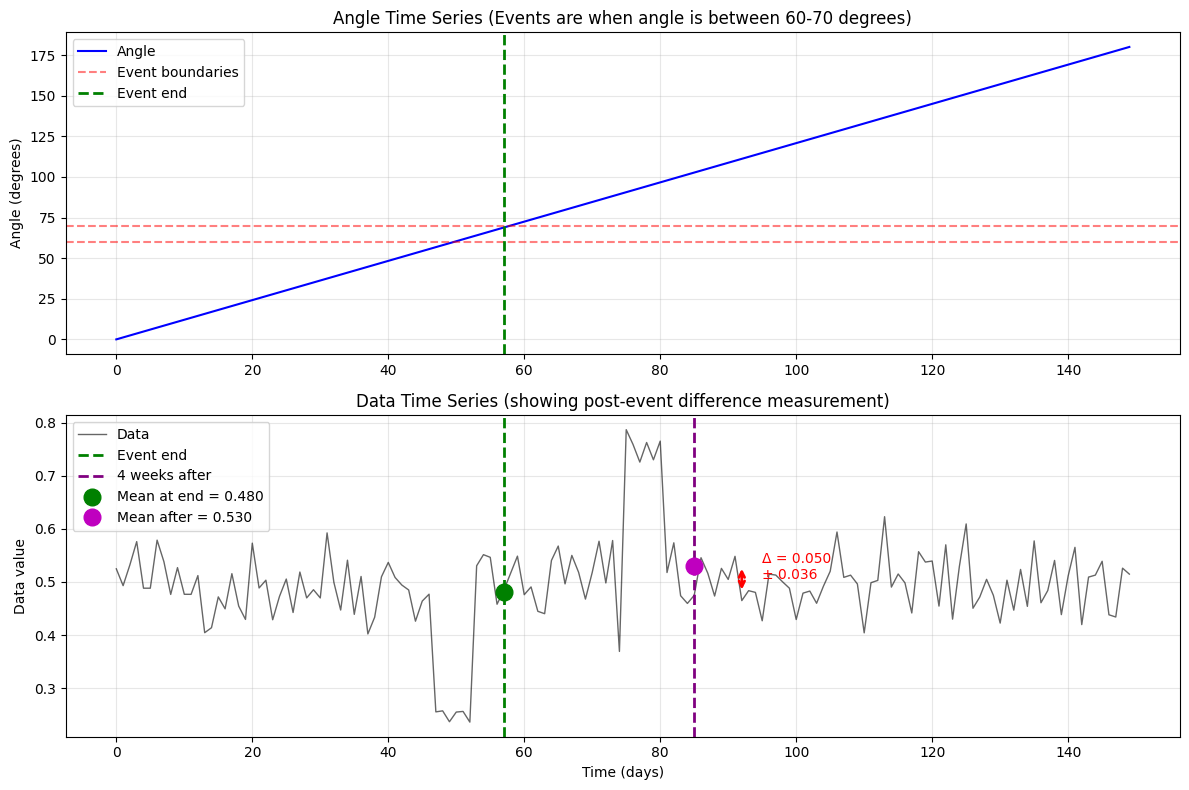


Results summary:
  Difference method: Δ = 0.0499 ± 0.0355
  Gradient method: -0.000344 per day
                   -0.0024 per week



In [11]:
# Visual test: Plot to show what the functions are measuring
print("Visual demonstration of post-event statistics:")
print("=" * 70)

# Create synthetic data
n_points = 150
start = 2426342.5
test_time = start + np.arange(n_points)
test_angles = np.linspace(0, 180, n_points)

# Create data with a clear pattern after event end
np.random.seed(42)
test_data = 0.5 + np.random.normal(0, 0.05, n_points)

# Event ends around index 50
event_end = 50
# 4 weeks after = index 78 (28 days later)
weeks = 4
after_idx = event_end + weeks * 7

# Create lower values at event end
test_data[event_end-3:event_end+3] = 0.25 + np.random.normal(0, 0.02, 6)

# Create higher values 4 weeks after
test_data[after_idx-3:after_idx+3] = 0.75 + np.random.normal(0, 0.02, 6)

# Run the functions
diff_result = angle_window_post_event_difference(
    test_time, test_angles, test_data,
    angle_min=60, angle_max=70,
    weeks_after=4,
    n_points_at_end=10,
    n_points_after=10
)

grad_result = angle_window_post_event_gradient(
    test_time, test_angles, test_data,
    angle_min=60, angle_max=70,
    weeks_after=4
)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Top panel: Show the angle and event window
ax1.plot(test_time-start, test_angles, 'b-', linewidth=1.5, label='Angle')
ax1.axhline(y=60, color='r', linestyle='--', alpha=0.5, label='Event boundaries')
ax1.axhline(y=70, color='r', linestyle='--', alpha=0.5)
if len(diff_result) > 0:
    event_end_idx = diff_result[0]['end_idx']
    ax1.axvline(x=event_end_idx, color='g', linestyle='--', linewidth=2, label='Event end')
ax1.set_ylabel('Angle (degrees)')
ax1.set_title('Angle Time Series (Events are when angle is between 60-70 degrees)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom panel: Show the data and measurements
ax2.plot(test_time-start, test_data, 'k-', linewidth=1, alpha=0.6, label='Data')
if len(diff_result) > 0:
    event = diff_result[0]
    end_idx = event['end_idx']
    
    # Mark event end
    ax2.axvline(x=end_idx, color='g', linestyle='--', linewidth=2, label='Event end')
    
    # Mark 4 weeks after
    ax2.axvline(x=end_idx + 28, color='purple', linestyle='--', linewidth=2, 
                label=f'{weeks} weeks after')
    
    # Show the mean values
    ax2.plot(end_idx, event['mean_at_end'], 'go', markersize=12, 
            label=f"Mean at end = {event['mean_at_end']:.3f}")
    ax2.plot(end_idx + 28, event['mean_after'], 'mo', markersize=12,
            label=f"Mean after = {event['mean_after']:.3f}")
    
    # Draw arrow showing difference
    ax2.annotate('', xy=(end_idx + 35, event['mean_after']), 
                xytext=(end_idx + 35, event['mean_at_end']),
                arrowprops=dict(arrowstyle='<->', color='red', lw=2))
    ax2.text(end_idx + 38, (event['mean_at_end'] + event['mean_after'])/2,
            f"Δ = {event['difference']:.3f}\n± {event['error']:.3f}",
            fontsize=10, color='red')

ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Data value')
ax2.set_title('Data Time Series (showing post-event difference measurement)')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if len(diff_result) > 0 and len(grad_result) > 0:
    print(f"\nResults summary:")
    print(f"  Difference method: Δ = {diff_result[0]['difference']:.4f} ± {diff_result[0]['error']:.4f}")
    print(f"  Gradient method: {grad_result[0]['gradient']:.6f} per day")
    print(f"                   {grad_result[0]['gradient_per_week']:.4f} per week")

print("\n" + "=" * 70)

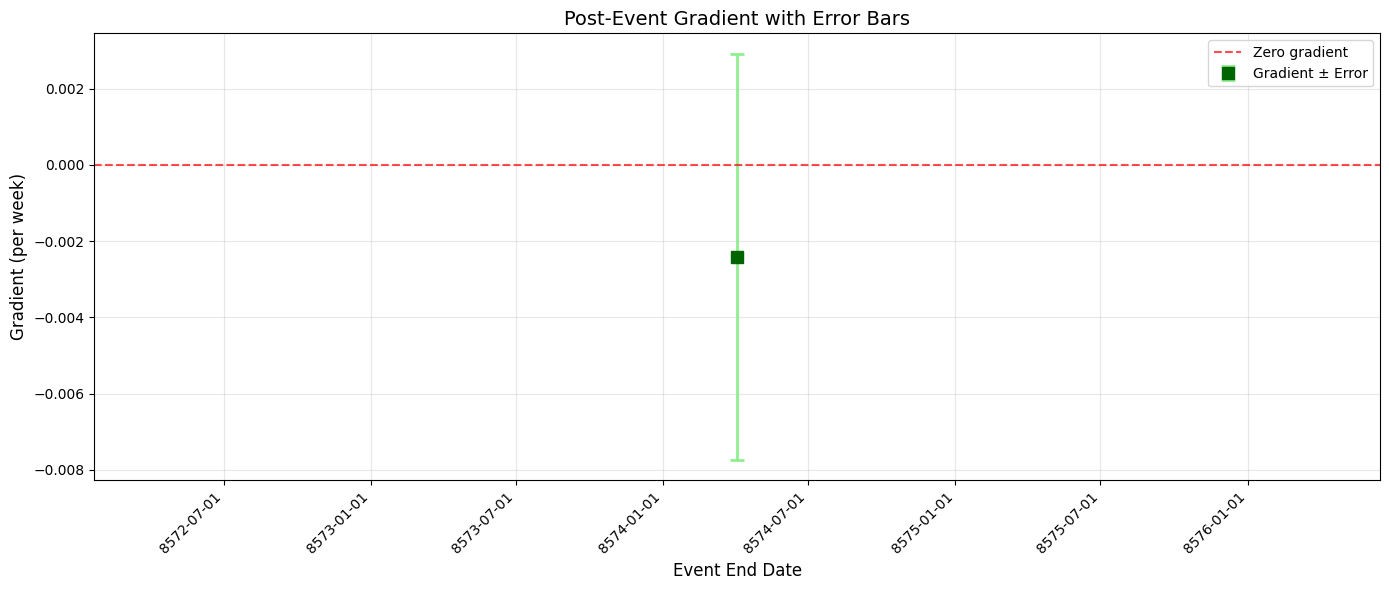

Summary of 1 events:
  Mean gradient: -0.002407 ± 0.000000 per week
  Median gradient: -0.002407 per week
  Mean error: 0.005329 per week
  Number of positive gradients: 0
  Number of negative gradients: 1


In [12]:
# Plot post-event gradients with error bars
# Assuming you have stored the gradient result in a variable (e.g., 'grad_result')
# grad_result = angle_window_post_event_gradient(...)

# Extract data from the result
gradients = [event['gradient_per_week'] for event in grad_result]
gradient_errors = [event['gradient_error_per_week'] for event in grad_result]
event_times_jd = [start+event['end_time'] for event in grad_result]

# Convert Julian dates to datetime
event_dates = Time(event_times_jd, format='jd').to_datetime()

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot with error bars
ax.errorbar(event_dates, gradients, yerr=gradient_errors, 
            fmt='s', markersize=8, capsize=5, capthick=2,
            color='darkgreen', ecolor='lightgreen', elinewidth=2,
            label='Gradient ± Error')

# Add horizontal line at zero for reference
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Zero gradient')

# Formatting
ax.set_xlabel('Event End Date', fontsize=12)
ax.set_ylabel('Gradient (per week)', fontsize=12)
ax.set_title('Post-Event Gradient with Error Bars', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Format x-axis to show dates nicely
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Summary of {len(gradients)} events:")
print(f"  Mean gradient: {np.nanmean(gradients):.6f} ± {np.nanstd(gradients):.6f} per week")
print(f"  Median gradient: {np.nanmedian(gradients):.6f} per week")
print(f"  Mean error: {np.nanmean(gradient_errors):.6f} per week")
print(f"  Number of positive gradients: {sum(1 for g in gradients if g > 0)}")
print(f"  Number of negative gradients: {sum(1 for g in gradients if g < 0)}")

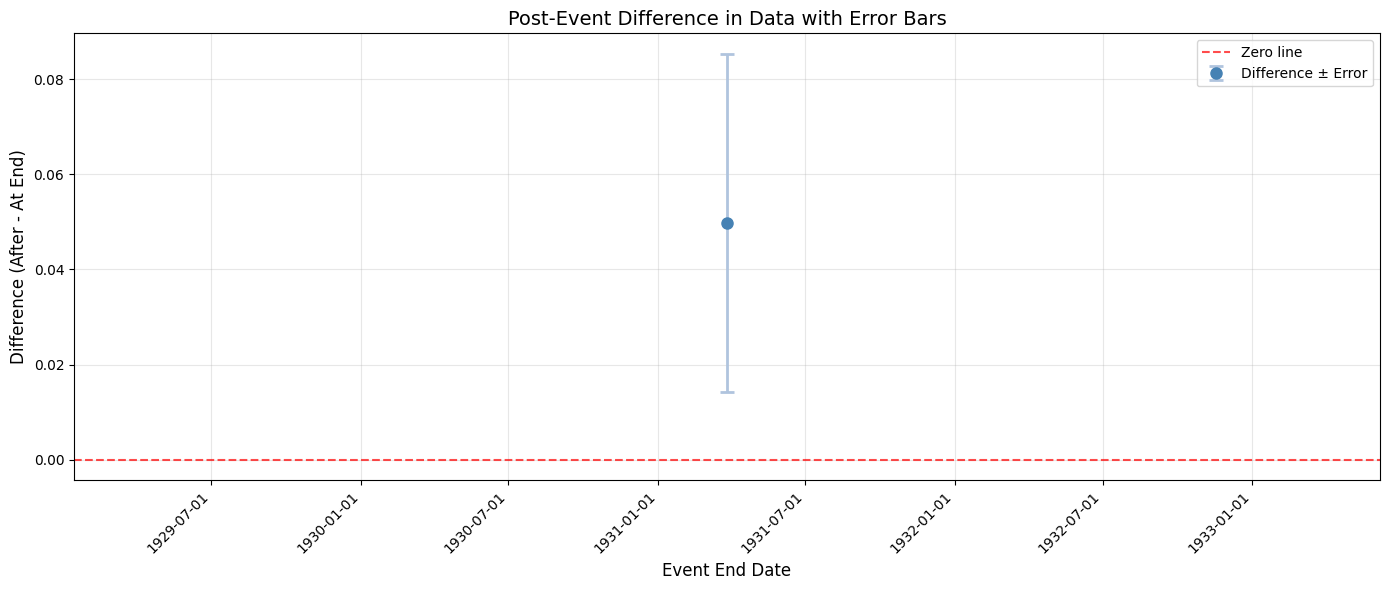

Summary of 1 events:
  Mean difference: 0.0499 ± 0.0000
  Median difference: 0.0499
  Mean error: 0.0355
  Number of positive differences: 1
  Number of negative differences: 0


In [13]:
# Plot post-event differences with error bars
# Assuming you have stored the result in a variable (e.g., 'diff_result')
# diff_result = angle_window_post_event_difference(...)

# Extract data from the result
differences = [event['difference'] for event in diff_result]
errors = [event['error'] for event in diff_result]
event_times_jd = [event['end_time'] for event in diff_result]

# Convert Julian dates to datetime
event_dates = Time(event_times_jd, format='jd').to_datetime()

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot with error bars
ax.errorbar(event_dates, differences, yerr=errors, 
            fmt='o', markersize=8, capsize=5, capthick=2,
            color='steelblue', ecolor='lightsteelblue', elinewidth=2,
            label='Difference ± Error')

# Add horizontal line at zero for reference
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Zero line')

# Formatting
ax.set_xlabel('Event End Date', fontsize=12)
ax.set_ylabel('Difference (After - At End)', fontsize=12)
ax.set_title('Post-Event Difference in Data with Error Bars', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Format x-axis to show dates nicely
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Summary of {len(differences)} events:")
print(f"  Mean difference: {np.nanmean(differences):.4f} ± {np.nanstd(differences):.4f}")
print(f"  Median difference: {np.nanmedian(differences):.4f}")
print(f"  Mean error: {np.nanmean(errors):.4f}")
print(f"  Number of positive differences: {sum(1 for d in differences if d > 0)}")
print(f"  Number of negative differences: {sum(1 for d in differences if d < 0)}")

## Load HDF5 File and Sunspot Data

Ephemerides Data

In [14]:
file = h5py.File(filePath)
planets = list(file.keys())
print(planets)
print(file['Earth'].keys())
print(file['Earth'].attrs.keys())

['Earth', 'Jupiter', 'Mercury', 'Neptune', 'Saturn', 'Sun', 'Uranus', 'Venus']
<KeysViewHDF5 ['jd', 'vx', 'vy', 'vz', 'x', 'y', 'z']>
<KeysViewHDF5 ['n_points', 'naif_id', 'units_position', 'units_velocity']>


Sunspot Data

In [15]:
study_key = "N_Sunspots_Norm"


# Path to sunspots data file
__SUNSPOT_FILE__ = Path("../data/SN_d_tot_V2.0.csv")

# Load the csv file into memory
sp_file =pd.read_csv(__SUNSPOT_FILE__, sep = None, na_values=['-1', 'NaN'], engine='python')

# Compute the normalized number of sunspots, ranging from 0 to 1
minv = sp_file['N_Sunspots'].min()
maxv = sp_file['N_Sunspots'].max()
mean = sp_file['N_Sunspots'].mean()
std = sp_file['N_Sunspots'].std()
sp_file['N_Sunspots_Norm'] = (sp_file['N_Sunspots'] - minv) / (maxv - minv)

# Compute the solar tranquility, defined by 1 - N_Sunspots_Norm
sp_file["Tranquility"] = (1 - sp_file["N_Sunspots_Norm"])

# Create new column converting Year-Month-Day data into julian date
sp_file['jd'] = Time(
    [f"{y}-{m}-{d}" for y, m, d in zip(sp_file['Year'], sp_file['Month'], sp_file['Day'])],
    format='iso'
).jd

# Print summary of datatable
sp_file


,Year,Month,Day,Decimal_Year,N_Sunspots,Std,N_Observations,Def/Prov,N_Sunspots_Norm,Tranquility,jd
0,1818,1,1,1818.001,NaN,NaN,0,1,NaN,NaN,2385070.5
1,1818,1,2,1818.004,NaN,NaN,0,1,NaN,NaN,2385071.5
2,1818,1,3,1818.007,NaN,NaN,0,1,NaN,NaN,2385072.5
3,1818,1,4,1818.010,NaN,NaN,0,1,NaN,NaN,2385073.5
4,1818,1,5,1818.012,NaN,NaN,0,1,NaN,NaN,2385074.5
...,...,...,...,...,...,...,...,...,...,...,...
75905,2025,10,27,2025.821,98.0,17.2,31,0,0.185606,0.814394,2460975.5
75906,2025,10,28,2025.823,114.0,13.6,30,0,0.215909,0.784091,2460976.5
75907,2025,10,29,2025.826,100.0,13.3,23,0,0.189394,0.810606,2460977.5
75908,2025,10,30,2025.829,70.0,15.7,25,0,0.132576,0.867424,2460978.5


## Ensure Date Ranges of Planetary Ephemerides Match

In [16]:
dataConsistent = True
timearray = None
for planet in planets:
    if np.all(file[planet]['jd'][:] != file['Earth']['jd'][:]):
        print(f"Error as {planet}")
        dataConsistent = False
if dataConsistent:
    timearray = file['Earth']['jd'][:]
print(f"Date's are consistent across planets: {FancyColors.CYAN}{dataConsistent}{FancyColors.RESET}")

Date's are consistent across planets: True


In [17]:
# Grab only the dates that correspond to our selected epochs

# Generate mask for each set of dates
timearray_mask = np.isin(timearray, sp_file['jd'].values)
sp_mask = np.isin(sp_file['jd'].values, timearray)

# Slice the dataframe according to the timearray dates
sliced_df = sp_file[sp_file['jd'].isin(timearray)]
sliced_df

,Year,Month,Day,Decimal_Year,N_Sunspots,Std,N_Observations,Def/Prov,N_Sunspots_Norm,Tranquility,jd
41272,1931,1,1,1931.001,0.0,2.0,1,1,0.000000,1.000000,2426342.5
41273,1931,1,2,1931.004,12.0,3.0,1,1,0.022727,0.977273,2426343.5
41274,1931,1,3,1931.007,0.0,2.0,1,1,0.000000,1.000000,2426344.5
41275,1931,1,4,1931.010,15.0,3.5,1,1,0.028409,0.971591,2426345.5
41276,1931,1,5,1931.012,30.0,4.9,1,1,0.056818,0.943182,2426346.5
...,...,...,...,...,...,...,...,...,...,...,...
75905,2025,10,27,2025.821,98.0,17.2,31,0,0.185606,0.814394,2460975.5
75906,2025,10,28,2025.823,114.0,13.6,30,0,0.215909,0.784091,2460976.5
75907,2025,10,29,2025.826,100.0,13.3,23,0,0.189394,0.810606,2460977.5
75908,2025,10,30,2025.829,70.0,15.7,25,0,0.132576,0.867424,2460978.5


## Extract Ephemerides and Compute Angles

Build Dictionary for Ephemerides

In [18]:
ephemerides = {k:0 for k in planets}
for planet in planets:
    px = file[planet]['x'][:]*unit.AU.to(unit.m) # Meters
    py = file[planet]['y'][:]*unit.AU.to(unit.m) # Meters
    pz = file[planet]['z'][:]*unit.AU.to(unit.m) # Meters

    coords = np.stack([px,py,pz], axis=1)

    ephemerides[planet] = coords

planet_masses = {
    'Mercury': 3.3011e23, # kg
    'Venus':4.8675e24, # kg
    'Earth': 5.9724e24,# kg
    #'Mars': 6.4171e23,# kg
    'Jupiter':1.898e27,# kg
    'Saturn':5.685e26,# kg
    'Uranus':8.682e25,# kg
    'Neptune':1.024e26# kg
    }

Compute planetary center vectors for each group

In [19]:
g1_weights = np.array([.14,.34,.15,.35,.02])
g2_weights = np.array([.35,.40,.125,.125])

In [20]:
group1 = ['Mercury', 'Venus', 'Earth', 'Jupiter', 'Saturn']
#group1 = ['Mercury', 'Venus', 'Earth']

group2 = ['Jupiter', 'Saturn', 'Uranus', 'Neptune']


# Group1 total mass
g1_masses = np.asarray([planet_masses[p] for p in group1])

# Group2 total mass
g2_masses = np.asarray([planet_masses[p] for p in group2])

# Compute weights for position vectors
#g1_weights = g1_masses / (solar_mass + np.sum(g1_masses))
#g2_weights = g2_masses / (solar_mass + np.sum(g2_masses))


print(f" Group1 total mass: {np.sum(g1_masses)}   Group2 total mass: {np.sum(g2_masses)}")

# Compute total number of time series points
n_points = len(timearray)

# Compute the group1 barycenter
g1_ephemerides = np.asarray([ephemerides[p] for p in group1])
g1_barycenter = np.sum(g1_weights[:,None,None] * g1_ephemerides, axis=0)

# Compute the group2 barycenter
g2_ephemerides = np.asarray([ephemerides[p] for p in group2])
g2_barycenter = np.sum(g2_weights[:,None,None] * g2_ephemerides, axis=0)

 Group1 total mass: 2.47767001e+27   Group2 total mass: 2.65572e+27


Compute angles over time

In [21]:
# Inner products
dot_prods = np.einsum('ij,ij->i', g1_barycenter, g2_barycenter)
norms = np.linalg.norm(g1_barycenter, axis=1) * np.linalg.norm(g2_barycenter, axis=1)

# Compute the cosine of angles
cos_angles = dot_prods / norms
angles = np.arccos(cos_angles) * 180 / np.pi


In [22]:
## Slice the angles according to the date range of the sunspots
sliced_angles = angles[timearray_mask]

## Extract sunspots for from sliced dateframe
sunspots = sliced_df['N_Sunspots_Norm'].values

## Ensure dates are aligned
print(f"Dates are aligned: {np.all(sliced_df['jd'] == timearray[timearray_mask])}")

## Ensure data lists are identical lengths
print(f"Data is consistent lengths: {len(sliced_angles) == len(sunspots)}")

Dates are aligned: True
Data is consistent lengths: True


# <span style="color: cyan;"> Planetary Centers Analysis</span>

## Plot the Angles Over Epochs

In [ ]:
import matplotlib.dates as mdates

tarr = Time(timearray, format='jd').to_datetime()

plt.figure(figsize=(10, 5))
plt.plot(tarr, angles, lw=1.5)
plt.axhline(y=90, color='r', linestyle='--', linewidth=1.5, label='90 Degrees')
plt.xlabel("Date")
plt.ylabel("Angle (degrees)")
plt.title("New Weighted Angles Over Time")
plt.grid(True, alpha=0.3)
plt.legend()

# Format date axis nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

plt.tight_layout()
#plt.savefig("../figures/barycenter_angles.png")
#plt.savefig('../literature/our_work/barycenter_angles.png')
plt.savefig("../figures/weighted_angles.png")
plt.savefig('../literature/our_work/weighted_angles.png')


# <span style="color: cyan;"> Sunspot Analysis</span>

## Compute Statistics

In [ ]:
## Compute correlation and p-score
circ_lin_corr(sliced_angles, sunspots)

In [ ]:
lags = np.arange(-120,120,10)
out = sweep_lag_circ_lin(timearray[timearray_mask], sliced_angles, sliced_df['jd'], sunspots, lags, L=30, n_perm=2000)
out

In [ ]:
res = wavelet_cross_analysis(sliced_angles, sunspots, timearray[1] - timearray[0])
print(f"Mean coherence: {np.nanmean(res['wtc']):.3f}")
print(f"Mean delay: {np.nanmean(res['delay']):.2f} time units")
res.keys()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- align array lengths ---
time = np.asarray(timearray[timearray_mask], float)
period = np.asarray(res["period"], float)
wtc = np.asarray(res["wtc"])
angles_deg = sliced_angles

n = min(len(time), wtc.shape[1], len(angles_deg))
time, wtc, angles_deg = time[:n], wtc[:, :n], angles_deg[:n]

# --- build figure with tight, touching layout ---
fig = plt.figure(figsize=(10, 7))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)
ax_top = fig.add_subplot(gs[0])
ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)

# --- top: wavelet coherence ---
T, P = np.meshgrid(time, period)
pcm = ax_top.pcolormesh(T, P, wtc, shading="auto", cmap="turbo")
ax_top.set_yscale("log")
ax_top.set_ylabel("Period")
ax_top.set_title("Wavelet Coherence")
fig.colorbar(pcm, ax=ax_top, orientation="vertical", label="Coherence")

# hide top plot’s x ticks and labels
ax_top.tick_params(labelbottom=False)
ax_top.set_xlabel("")  # no label on top plot

# --- bottom: driver angle vs. time ---
ax_bottom.plot(time, angles_deg, lw=0.8, color="tab:blue")
ax_bottom.set_ylabel("Angle (°)")
ax_bottom.set_xlabel("Time (Julian Date)")
ax_bottom.set_xlim(time[0], time[-1])
#ax_bottom.set_title("Driver Angle vs. Time")

# --- ensure exact horizontal alignment ---
pos0 = ax_top.get_position()
pos1 = ax_bottom.get_position()
ax_bottom.set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])


plt.savefig("../figures/wavelet_coh.png")
plt.savefig('../literature/our_work/wavelet_coh.png')


In [ ]:
phase_raw = np.angle(res['Wxy'])
import numpy as np
import matplotlib.pyplot as plt

# --- align array lengths ---
time = np.asarray(timearray[timearray_mask], float)
period = np.asarray(res["period"], float)
wtc = phase_raw
angles_deg = sliced_angles

n = min(len(time), wtc.shape[1], len(angles_deg))
time, wtc, angles_deg = time[:n], wtc[:, :n], angles_deg[:n]

# --- build figure with tight, touching layout ---
fig = plt.figure(figsize=(10, 7))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)
ax_top = fig.add_subplot(gs[0])
ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)

# --- top: wavelet coherence ---
T, P = np.meshgrid(time, period)
pcm = ax_top.pcolormesh(T, P, wtc, shading="auto", cmap="turbo")
ax_top.set_yscale("log")
ax_top.set_ylabel("Period")
ax_top.set_title("Relative Phase")
fig.colorbar(pcm, ax=ax_top, orientation="vertical", label="Coherence")

# hide top plot’s x ticks and labels
ax_top.tick_params(labelbottom=False)
ax_top.set_xlabel("")  # no label on top plot

# --- bottom: driver angle vs. time ---
ax_bottom.plot(time, angles_deg, lw=0.8, color="tab:blue")
ax_bottom.set_ylabel("Angle (°)")
ax_bottom.set_xlabel("Time (Julian Date)")
ax_bottom.set_xlim(time[0], time[-1])
#ax_bottom.set_title("Driver Angle vs. Time")

# --- ensure exact horizontal alignment ---
pos0 = ax_top.get_position()
pos1 = ax_bottom.get_position()
ax_bottom.set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])

plt.savefig("../figures/wavelet_coh_phase.png")
plt.savefig('../literature/our_work/wavelet_coh_phase.png')


In [ ]:
tarr = Time(timearray[timearray_mask], format='jd').to_datetime()

plt.figure(figsize=(10, 5))
plt.plot(tarr, sunspots, lw=1.5)
plt.xlabel("Date")
plt.ylabel("Tranquility")
plt.title("Temporal Evolution of Solar Tranquility")
plt.grid(True, alpha=0.3)
plt.legend()

# Format date axis nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

plt.tight_layout()
plt.savefig("../figures/soltranq.png")
plt.savefig('../literature/our_work/soltranq.png')


# <span style="color: cyan;"> Study A</span>

## Figure 1 Recreation

In [ ]:
# First, recreate Fig. 1

tranquility = sp_file[study_key]

time_lower = Time('2015-06-05', format='iso').jd
time_higher = Time('2019-12-05', format='iso').jd

# Generate the time mask
MASK = ( timearray >= time_lower ) & ( timearray <= time_higher)

# Slice the time array
timearray = file['Earth']['jd'][:]
timearray_sliced = timearray[ MASK ]

# Slice the angle array
angles_sliced = angles[ MASK ]

# Create a boolean array to show where 90 degree events occur
events_bool = ( angles_sliced >= __ANGLE_LIMIT_LOWER__ ) & ( angles_sliced <= __ANGLE_LIMIT_HIGHER__)

# SLice the tranquility array to the times as well
sp_mask = ( sp_file['jd'] >= time_lower ) & ( sp_file['jd'] <= time_higher )
tranq_masked = tranquility[sp_mask]

In [ ]:
times = Time(timearray_sliced, format='jd')
iso_dates = times.iso
plot_facecolor = (0.902, 0.902, 0.902)
# Create the plot
fig, ax = plt.subplots(figsize=(16, 8), facecolor=plot_facecolor)
ax.plot(timearray_sliced, 0.2 * events_bool, 'b-', linewidth=1.5, label='90 degree events') # Rescaled for nice figure
ax.plot(timearray_sliced, tranq_masked, 'r-', linewidth=1.5, label='solar activity')

# Set only 10 x-ticks with ISO format labels
tick_indices = np.linspace(0, len(timearray_sliced)-1, 10, dtype=int)
ax.set_xticks(timearray_sliced[tick_indices])
ax.set_xticklabels([iso_dates[i][:10] for i in tick_indices], rotation=45, ha='right', fontsize=16)

ax.set_xlabel('Date (ISO)', fontsize=16)
ax.get_yaxis().set_visible(False)  # Turn off y-axis
ax.set_title('Solar Activity versus 90 degree events', fontsize=16)
ax.legend(fontsize=16)
ax.grid(True, alpha=0.3)
ax.set_facecolor(plot_facecolor)
plt.tight_layout()

plt.savefig("../figures/sol_tranq_and_90_degree_select.png")
plt.savefig('../literature/our_work/sol_tranq_and_90_degree_select.png')

## Figure 2 Recreation

In [ ]:

tranquility = sp_file[study_key]

time_lower = Time('1935-01-11', format='iso').jd
time_higher = Time('2022-01-11', format='iso').jd

# Generate the time mask
MASK = ( timearray >= time_lower ) & ( timearray <= time_higher)

# Slice the time array
timearray = file['Earth']['jd'][:]
timearray_sliced = timearray[ MASK ]

# Slice the angle array
angles_sliced = angles[ MASK ]

# Create a boolean array to show where 90 degree events occur
events_bool = ( angles_sliced >= __ANGLE_LIMIT_LOWER__ ) & ( angles_sliced <= __ANGLE_LIMIT_HIGHER__)

# SLice the tranquility array to the times as well
sp_mask = ( sp_file['jd'] >= time_lower ) & ( sp_file['jd'] <= time_higher )
tranq_masked = tranquility[sp_mask]

In [ ]:
times = Time(timearray_sliced, format='jd')
iso_dates = times.iso
plot_facecolor = (0.902, 0.902, 0.902)
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6), facecolor=plot_facecolor)
ax.plot(timearray_sliced, .5 * events_bool, 'b-', linewidth=1.5, label='90 degree events') # Rescaled for nice figure
ax.plot(timearray_sliced, tranq_masked, 'r-', linewidth=1.5, label='solar activity', alpha=0.8)

# Set only 10 x-ticks with ISO format labels
tick_indices = np.linspace(0, len(timearray_sliced)-1, 10, dtype=int)
ax.set_xticks(timearray_sliced[tick_indices])
ax.set_xticklabels([iso_dates[i][:10] for i in tick_indices], rotation=45, ha='right', fontsize=16)

ax.set_xlabel('Date (ISO)', fontsize=16)
ax.get_yaxis().set_visible(False)  # Turn off y-axis
ax.set_title('Solar Activity versus 90 degree events', fontsize=16)
ax.legend(fontsize=16)
ax.grid(True, alpha=0.3)
ax.set_facecolor(plot_facecolor)
plt.tight_layout()

plt.savefig("../figures/sol_tranq_and_90_degree.png")
plt.savefig('../literature/our_work/sol_tranq_and_90_degree.png')


## Stability of Solar Tranquility Figures of Merit

In [ ]:
tranquility = sp_file[study_key]

#print(f"Using 7-day rolling average of Tranquility")
#tranquility = tranquility.rolling(window=7).mean()


sp_file_time = sp_file['jd'].values
ps_file_time = file['Earth']['jd'][:]

# Use entire aligned date range
time_lower = np.max([sp_file_time[0], ps_file_time[0]]) # 1931-01-01
time_higher = np.min([sp_file_time[-1], ps_file_time[-1]]) # 2025-10-31

# Generate the time mask
MASK = ( timearray >= time_lower ) & ( timearray <= time_higher)
SP_MASK = ( sp_file['jd'] >= time_lower ) & ( sp_file['jd'] <= time_higher )

# Slice the time array

timearray_sliced = timearray[ MASK ]
sp_time_sliced = sp_file_time[ SP_MASK ]

# Ensure time arrays are aligned
print(f"Time arrays are aligned: {np.all(timearray_sliced == sp_time_sliced)}")

# Slice the angle array
angles_sliced = angles[ MASK ]

# Create a boolean array to show where 90 degree events occur
events_bool = ( angles_sliced >= __ANGLE_LIMIT_LOWER__ ) & ( angles_sliced <= __ANGLE_LIMIT_HIGHER__)

# SLice the tranquility array to the times as well
tranq_masked = tranquility[SP_MASK]

In [ ]:
# Compute complete running variance ratio of solar tranquility

tranq_var_rat_pre = angle_window_variance_ratio(
    timearray_sliced,
    angles_sliced,
    tranq_masked,
    86,
    94,
    12*7,
    inverse = False
)

# Drop NaN values (occurs usually when there is no sunspot data for that date)
tranq_var_rat_pre_filt = [win for win in tranq_var_rat_pre if not np.isnan(win['ratio']) ]
rats_pre = [win['ratio'] for win in tranq_var_rat_pre]
print(f"Number of events: {len(tranq_var_rat_pre_filt)}")
print(f"Ratios: {rats_pre}")
print(f"Mean: {np.nanmean(rats_pre)}")
print(f"Median: {np.nanmedian(rats_pre)}")

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(rats_pre)
ax.axhline(y=1, label='unity', color='red', linestyle='--');
ax.set_title("Pre-During Variance with 14 day lookback")
ax.set_ylabel("Var(during) / Var(Pre)")
ax.set_xlabel("Event Index")
ax.grid(True)
plt.legend();

plt.savefig("../figures/sol_tranq_pre_var.png")
plt.savefig('../literature/our_work/sol_tranq_pre_var.png')

In [ ]:
tranq_var_rat_post = angle_window_variance_ratio_post(
    timearray_sliced,
    angles_sliced,
    tranq_masked,
    86,
    94,
    12*7,
    inverse = False
)

# Drop NaN values (occurs usually when there is no sunspot data for that date)
tranq_var_rat_post_filt = [win for win in tranq_var_rat_post if not np.isnan(win['ratio']) ]
rats_post = [win['ratio'] for win in tranq_var_rat_post][:]
rats_post = np.delete(rats_post,5)
print(f"Number of events: {len(tranq_var_rat_post_filt)}")
print(f"Ratios: {rats_post}")
print(f"Mean: {np.nanmean(rats_post)}")
print(f"Median: {np.nanmedian(rats_post)}")

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(rats_post)
ax.axhline(y=1, label='unity', color='red', linestyle='--');
ax.set_title("During/Post Variance with 14 day lookforward")
ax.set_ylabel("Var(during) / Var(Post)")
ax.set_xlabel("Event Index")
ax.grid(True)
ax.set_ylim(0,np.max(rats_post))
plt.legend();
plt.savefig("../figures/sol_tranq_post_var.png")
plt.savefig('../literature/our_work/sol_tranq_post_var.png')

In [ ]:
# Plot the mean pre ratio versus lookback time

def compute_pre_mean(lb_time):
    res = angle_window_variance_ratio(
        timearray_sliced,
        angles_sliced,
        tranq_masked,
        86,
        94,
        lb_time,
        inverse = False
    )

    # Drop NaN values (occurs usually when there is no sunspot data for that date)
    rats_pre = [win['ratio'] for win in res]
    return np.mean(rats_pre)

def compute_post_mean(lb_time):
    res = angle_window_variance_ratio_post(
        timearray_sliced,
        angles_sliced,
        tranq_masked,
        86,
        94,
        lb_time,
        inverse = False
    )

    # Drop NaN values (occurs usually when there is no sunspot data for that date)
    rats_pre = [win['ratio'] for win in res]
    return np.nanmean(rats_pre)

pre_means = [compute_pre_mean(lb) for lb in np.arange(4,28)]
post_means = [compute_post_mean(lb) for lb in np.arange(4,28)]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(pre_means, label="during-pre")
ax.plot(post_means, label="during-post")
ax.axhline(y=1, label='unity', color='red', linestyle='--');
ax.set_title("Pre- and Post- ratios versus lookback/lookforward time")
ax.set_ylabel("<Var(during) / Var(Pre/Post)>")
ax.set_xlabel("Lookback/forward time")
ax.grid(True)
ax.set_ylim(0,np.nanmax(post_means))
plt.legend();
plt.savefig("../figures/mean_ratio_vs_lookbackforward.png")
plt.savefig('../literature/our_work/mean_ratio_vs_lookbackforward.png')

In [ ]:
# Compute number of pre-ratios that are below unity
n_below_pre = len([rat for rat in rats_pre if rat < 1])

# Compute number of post-ratios that are below unity
n_below_post = len([rat for rat in rats_post if rat < 1])

# Number of total events
n_events = len(rats_pre)

# Compute p-score, assuming the null-hypothesis is unity
pre_p_score = scipy.stats.binomtest(n_below_pre, n_events, p=0.5).pvalue
post_p_score = scipy.stats.binomtest(n_below_post, n_events, p=0.5).pvalue

print(f"""
    Number of events with lower Var during (pre): {n_below_pre}  {n_below_pre/n_events:.2f}%
    Number of events with lower Var during (post): {n_below_post}  {n_below_post/n_events:.2f}%
    Events with lower Var during (pre) - p score: {pre_p_score}
    Events with lower Var during (post) - p score: {post_p_score}
""")

print(f"""
                                pre ratio                 post ratio
                                ------------              -----------
n:                              {n_events}                        {n_events}
Median ratio:                   {np.nanmedian(rats_pre):.4f}                    {np.nanmedian(rats_post):.4f}
Mean ratio:                     {np.nanmean(rats_pre):.4f}                    {np.nanmean(rats_post):.4f}
Events with lower var during:   {n_below_pre} ({100*n_below_pre / n_events:.2f}%)               {n_below_post} ({100*n_below_post / n_events:.2f}%)
p-score:                        {pre_p_score:.4f}                    {post_p_score:.4f}

""")

## Randomly Sampled Ratios

We now randomly sample the variance ratios to understand the statistical distribution

First, recompute data

In [33]:
tranquility = sp_file[study_key]

#print(f"Using 7-day rolling average of Tranquility")
#tranquility = tranquility.rolling(window=7).mean()


sp_file_time = sp_file['jd'].values
ps_file_time = file['Earth']['jd'][:]

# Use entire aligned date range
time_lower = np.max([sp_file_time[0], ps_file_time[0]]) # 1931-01-01
time_higher = np.min([sp_file_time[-1], ps_file_time[-1]]) # 2025-10-31

# Generate the time mask
MASK = ( timearray >= time_lower ) & ( timearray <= time_higher)
SP_MASK = ( sp_file['jd'] >= time_lower ) & ( sp_file['jd'] <= time_higher )

# Slice the time array

timearray_sliced = timearray[ MASK ]
sp_time_sliced = sp_file_time[ SP_MASK ]

# Ensure time arrays are aligned
print(f"Time arrays are aligned: {np.all(timearray_sliced == sp_time_sliced)}")

# Slice the angle array
angles_sliced = angles[ MASK ]

# Create a boolean array to show where 90 degree events occur
events_bool = ( angles_sliced >= __ANGLE_LIMIT_LOWER__ ) & ( angles_sliced <= __ANGLE_LIMIT_HIGHER__)

# SLice the tranquility array to the times as well
tranq_masked = tranquility[SP_MASK]

tranq_var_rat_pre = angle_window_variance_ratio(
    timearray_sliced,
    angles_sliced,
    tranq_masked,
    86,
    94,
    12*7,
    inverse = False
)

# Drop NaN values (occurs usually when there is no sunspot data for that date)
tranq_var_rat_pre_filt = [win for win in tranq_var_rat_pre if not np.isnan(win['ratio']) ]

tranq_var_rat_post = angle_window_variance_ratio_post(
    timearray_sliced,
    angles_sliced,
    tranq_masked,
    86,
    94,
    12*7,
    inverse = False
)

# Drop NaN values (occurs usually when there is no sunspot data for that date)
tranq_var_rat_post_filt = [win for win in tranq_var_rat_post if not np.isnan(win['ratio']) ]

Time arrays are aligned: True


In [34]:
## Compute average event size
spans = [win['end_time'] - win['start_time'] for win in tranq_var_rat_pre_filt]
pre_ratios = np.array([win['ratio'] for win in tranq_var_rat_pre_filt])
post_ratios = np.array([win['ratio'] for win in tranq_var_rat_post_filt])
median_span = np.median(spans)
mean_span = np.mean(spans)

span = int(median_span)
lookbackforward = span
random_results = random_span_variance_ratio_null_distribution(
    tranq_masked.values,
    tranq_var_rat_pre_filt,
    tranq_var_rat_post_filt,
    span_days = int(span),
    lookback_days = 7*12,
    lookforward_days = 7*12,
    n_trials = 50000
)
num_trials = len(random_results['pre_ratios'])
print(f"""
Range of event durations: min = {min(spans)}   max = {max(spans)}
Number of trials: {num_trials}
span: {int(span)}
pre_mean: {random_results['pre_mean']:.4f}              post_mean: {random_results['post_mean']:.4f}         
pre_std: {np.sqrt(random_results['pre_var']):.4f}               post_std: {np.sqrt(random_results['post_var']):.4f} 
pre skewness: {scipy.stats.skew(random_results["pre_ratios"]):.4f}          post skewness: {scipy.stats.skew(random_results["post_ratios"]):.4f}
pre exc. kurtosis: {scipy.stats.kurtosis(random_results["pre_ratios"]) - 3:.4f}    post exc. kurtosis: {scipy.stats.kurtosis(random_results["post_ratios"]) - 3:.4f}
""")


Range of event durations: min = 17.0   max = 169.0
Number of trials: 50000
span: 42
pre_mean: 1.1477              post_mean: 1.1278         
pre_std: 1.3296               post_std: 1.1731 
pre skewness: 6.9357          post skewness: 4.7892
pre exc. kurtosis: 83.0468    post exc. kurtosis: 38.2059



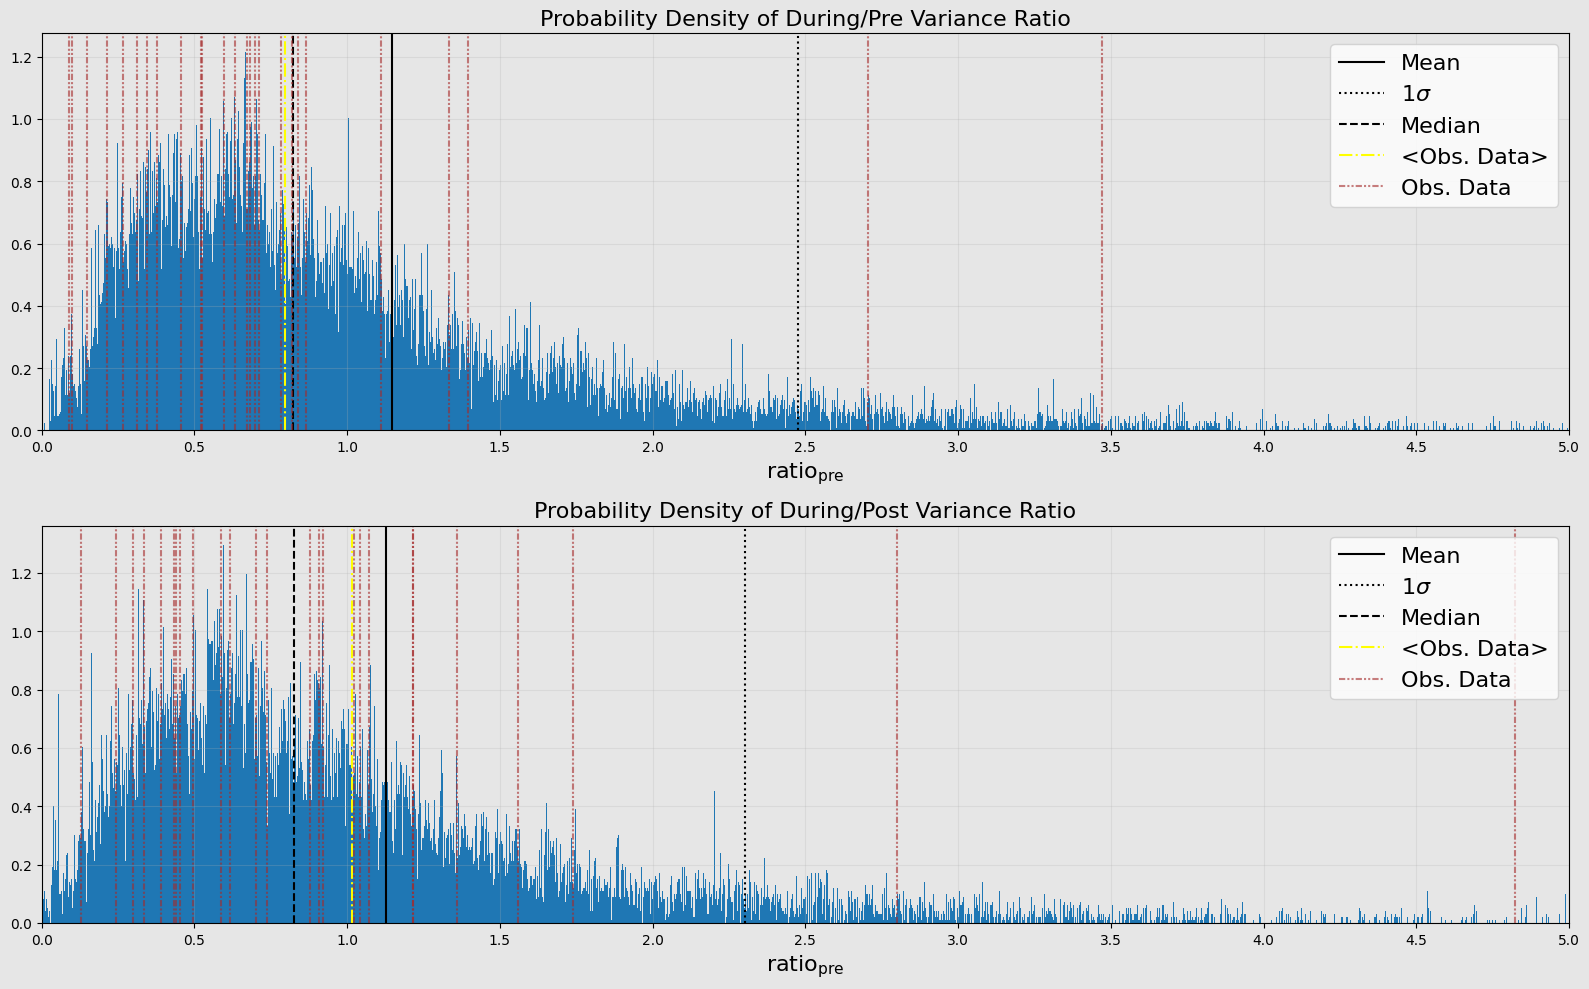

In [35]:
# Plotting settings
obs_data_color = ('brown', 0.6)
obs_mean_color = (1,1,0)
obs_data_linestyle = (0, (3, 1, 1, 1, 1, 1))
plot_facecolor = (0.902, 0.902, 0.902)



fig, axs = plt.subplots(2,1, figsize=(16,10), facecolor=plot_facecolor)
axs[0].hist(random_results['pre_ratios'], bins=10000, density = True);
axs[0].set_xlim(0,5)
axs[0].set_title("Probability Density of During/Pre Variance Ratio", fontsize=16)
axs[0].grid(True, alpha=0.25)
axs[0].set_xlabel(r'ratio$_{\text{pre}}$', fontsize=16)
axs[0].axvline(x = random_results['pre_mean'], color='black', label="Mean")
axs[0].axvline(x = random_results['pre_mean'] + random_results['pre_std'], color='black', label=r'$1 \sigma$', linestyle=':')
axs[0].axvline(x = np.median(random_results['pre_ratios']), color='black', label="Median", linestyle = "--")
axs[0].axvline(x = np.mean(pre_ratios), label="<Obs. Data>", linestyle = "-.", color=obs_mean_color)
counter = 0
for rat in pre_ratios:
    if counter == 0:
        axs[0].axvline(x = rat, label="Obs. Data", linestyle = obs_data_linestyle, color=obs_data_color)
    else:
        axs[0].axvline(x = rat,  linestyle = obs_data_linestyle, color=obs_data_color)
    counter += 1
axs[0].legend(fontsize=16)
axs[0].xaxis.set_major_locator(MaxNLocator(nbins=10))
axs[0].set_facecolor(plot_facecolor)

axs[1].hist(random_results['post_ratios'], bins=10000, density = True);
axs[1].set_xlim(0,5)
axs[1].set_title("Probability Density of During/Post Variance Ratio", fontsize=16)
axs[1].grid(True, alpha=0.23)
axs[1].set_xlabel(r'ratio$_{\text{pre}}$', fontsize=16)
axs[1].axvline(x = random_results['post_mean'], color='black', label="Mean")
axs[1].axvline(x = random_results['post_mean'] + random_results['post_std'], color='black', label=r'$1 \sigma$', linestyle=':')
axs[1].axvline(x = np.median(random_results['post_ratios']), color='black', label="Median", linestyle = "--")
axs[1].axvline(x = np.mean(post_ratios), label="<Obs. Data>", linestyle = "-.", color=obs_mean_color)
counter = 0
for rat in post_ratios:
    if counter == 0:
        axs[1].axvline(x = rat, label="Obs. Data", linestyle = obs_data_linestyle, color=obs_data_color)
    else:
        axs[1].axvline(x = rat,  linestyle = obs_data_linestyle, color=obs_data_color)
    counter += 1
axs[1].legend(fontsize=16);
axs[1].xaxis.set_major_locator(MaxNLocator(nbins=10));
axs[1].set_facecolor(plot_facecolor)

plt.tight_layout();


plt.savefig("../figures/ratio_distribution.png")
plt.savefig('../literature/our_work/ratio_distribution.png')

Now compare our observed data to this distribution

In [36]:
# 1-sided p score
pre_percentiles = [np.mean(random_results['pre_ratios'] <= r) for r in pre_ratios]
post_percentiles = [np.mean(random_results['post_ratios'] <= r) for r in post_ratios]
print(f"mean 1-sided pre p-score: {np.mean(pre_percentiles):.4f}")
print(f"mean 1-sided post p-score: {np.mean(post_percentiles):.4f}")
print(f"median 1-sided pre p-score: {np.median(pre_percentiles):.4f}")
print(f"median 1-sided post p-score: {np.median(post_percentiles):.4f}")
print(f"min 1-sided pre p-score: {np.min(pre_percentiles):.4f}")
print(f"min 1-sided post p-score: {np.min(post_percentiles):.4f}")
print(f"max 1-sided pre p-score: {np.max(pre_percentiles):.4f}")
print(f"max 1-sided post p-score: {np.max(post_percentiles):.4f}")

num_ratios_less_unity = len(pre_ratios[pre_ratios<1])
num_ratios = len(pre_ratios)
num_postratios_less_unity = len(post_ratios[post_ratios<1])
num_postratios = len(post_ratios)

print(f"during/pre: {num_ratios_less_unity}/{num_ratios} less than unity")
print(f"during/post: {num_postratios_less_unity}/{num_postratios} less than unity")
print(f"Binomial p-score for pre ratios: {binom_p(num_ratios_less_unity, num_ratios)}")
print(f"Binomial p-score for post ratios: {binom_p(num_postratios_less_unity, num_postratios)}")

mean 1-sided pre p-score: 0.3764
mean 1-sided post p-score: 0.4678
median 1-sided pre p-score: 0.3780
median 1-sided post p-score: 0.4885
min 1-sided pre p-score: 0.0113
min 1-sided post p-score: 0.0212
max 1-sided pre p-score: 0.9666
max 1-sided post p-score: 0.9823
during/pre: 21/26 less than unity
during/post: 16/26 less than unity
Binomial p-score for pre ratios: 0.002493917942047119
Binomial p-score for post ratios: 0.32693958282470703


In [37]:
# 2 sided p-score 
null_value = 1
obs_dist = abs(np.mean(pre_ratios) - null_value)
null_dist = np.abs(random_results['pre_ratios'] - null_value)
pre_p_value = np.mean(null_dist > obs_dist)
obs_dist = abs(np.mean(post_ratios) - null_value)
null_dist = np.abs(random_results['post_ratios'] - null_value)
post_p_value = np.mean(null_dist >= obs_dist)

print(f"2-sided pre p-value: {pre_p_value:.4f} -> {(1-pre_p_value)*100:.2f}%")
print(f"2-sided post p-value: {post_p_value:.4f} -> {(1-post_p_value)*100:.2f}%")

2-sided pre p-value: 0.7820 -> 21.80%
2-sided post p-value: 0.9804 -> 1.96%



pre mean: 1.1481    post mean: 1.1287
pre std: 0.2621      post std: 0.2308
pre skew: 1.3879       post_skew: 0.9694
pre exc. kurts: 0.4498 post exc. kurts: -1.2922



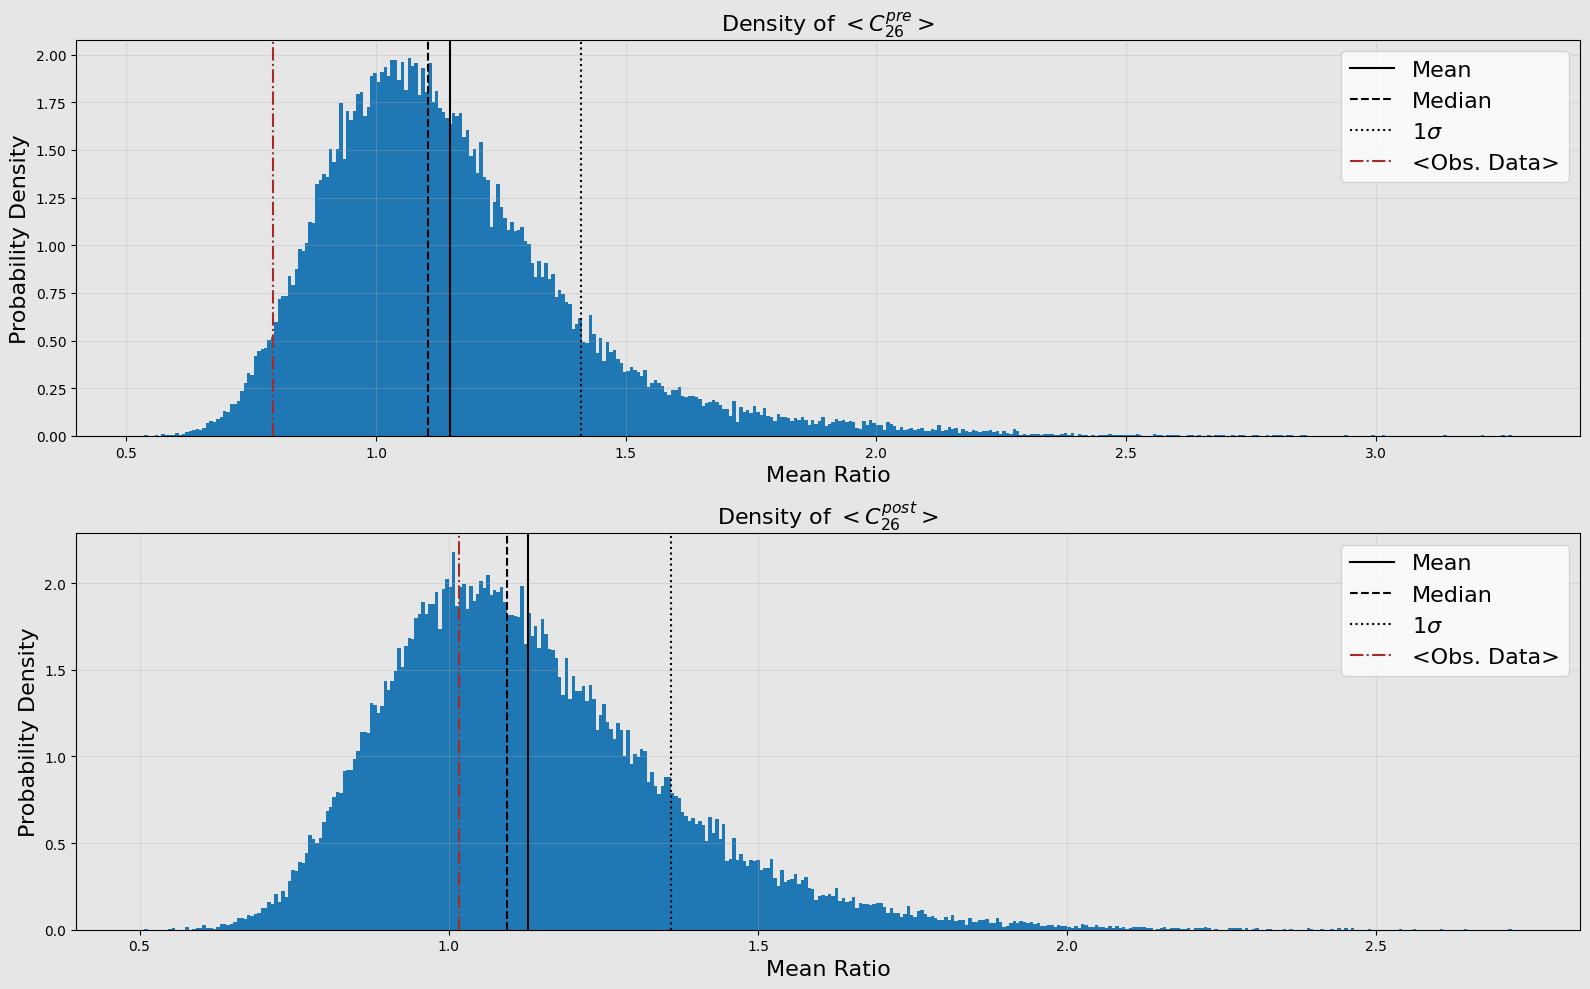

In [38]:
# Plot the probability density distribution of the means of N=26 choices
plot_facecolor = (0.902, 0.902, 0.902)
means_pre = []
means_post = []
n_perms = 50000
skew = scipy.stats.skew
kurt = scipy.stats.kurtosis
n_choices = 26
rng = np.random.default_rng()

for _ in range(n_perms):
    random_sample_pre = rng.choice(random_results['pre_ratios'], size=n_choices)
    mean_pre = np.mean(random_sample_pre)
    means_pre.append(mean_pre)

    random_sample_post = rng.choice(random_results['post_ratios'], size = n_choices)
    mean_post = np.mean(random_sample_post)
    means_post.append(mean_post)

print(f"""
pre mean: {np.mean(means_pre):.4f}    post mean: {np.mean(means_post):.4f}
pre std: {np.std(means_pre):.4f}      post std: {np.std(means_post):.4f}
pre skew: {skew(means_pre):.4f}       post_skew: {skew(means_post):.4f}
pre exc. kurts: {kurt(means_pre)-3:.4f} post exc. kurts: {kurt(means_post)-3:.4f}
""")

fig,axes = plt.subplots(2,1, figsize=(16,10), facecolor=plot_facecolor)
axes[0].hist(means_pre, bins = 400, density=True)
axes[0].set_xlabel("Mean Ratio", fontsize=16)
axes[0].set_ylabel("Probability Density", fontsize=16)
axes[0].grid(True, alpha = 0.3)
axes[0].set_title(r"Density of $<C^{pre}_{26}>$", fontsize=16)
axes[0].axvline(x = np.mean(means_pre), label="Mean", linestyle = '-', color='black')
axes[0].axvline(x = np.median(means_pre), label="Median", linestyle = '--', color='black')
axes[0].axvline(x = np.mean(means_pre) + np.std(means_pre), label=r'1$\sigma$', linestyle = ':', color='black')
axes[0].axvline(x = np.mean(pre_ratios), label="<Obs. Data>", linestyle = "-.", color='brown')
axes[0].legend(fontsize=16)
axes[0].set_facecolor(plot_facecolor)

axes[1].hist(means_post, bins = 400, density=True)
axes[1].set_xlabel("Mean Ratio", fontsize=16)
axes[1].set_ylabel("Probability Density", fontsize=16)
axes[1].grid(True, alpha = 0.3)
axes[1].set_title(r"Density of $<C^{post}_{26}>$", fontsize=16)
axes[1].axvline(x = np.mean(means_post), label="Mean", linestyle = '-', color='black')
axes[1].axvline(x = np.median(means_post), label="Median", linestyle = '--', color='black')
axes[1].axvline(x = np.mean(means_post) + np.std(means_post), label=r'1$\sigma$', linestyle = ':', color='black')
axes[1].axvline(x = np.mean(post_ratios), label="<Obs. Data>", linestyle = "-.", color='brown')
axes[1].legend(fontsize=16)
axes[1].set_facecolor(plot_facecolor)

plt.tight_layout();


plt.savefig("../figures/ratio_mean_distribution.png")
plt.savefig('../literature/our_work/ratio_mean_distribution.png')

In [ ]:
# 1 -sided p score

mean_pre_obs_ratio = np.mean(pre_ratios)
mean_post_obs_ratio = np.mean(post_ratios)

pre_mean_percentile = np.mean(means_pre < mean_pre_obs_ratio)
post_mean_percentile = np.mean(means_post < mean_post_obs_ratio)

print(f"1-sided pre p-score: {pre_mean_percentile} -> {(1-pre_mean_percentile)*100:.3f}%")
print(f"1-sided post p-socre: {post_mean_percentile} -> {(1-post_mean_percentile)*100:.3f}%")

In [ ]:
# Null value
null_value = 1.0

obs_dist = abs(mean_pre_obs_ratio - null_value)
null_dist = np.abs(np.array(means_pre) - null_value)
pre_p_value = np.mean(null_dist >= obs_dist)
obs_dist = abs(mean_post_obs_ratio - null_value)
null_dist = np.abs(np.array(means_post) - null_value)
post_p_value = np.mean(null_dist >= obs_dist)
print(f"pre p-value: {pre_p_value:.4f} -> {(1-pre_p_value)*100:.3f}%")
print(f"post p-value: {post_p_value:.4f} -> {(1-post_p_value)*100:.3f}%")

We repeat the exact same analysis as above but filter the observed windows using a trailing or advanced buffer

In [ ]:
# Filter the observed ratios

tranq_var_rat_pre = angle_window_variance_ratio(
    timearray_sliced,
    angles_sliced,
    tranq_masked,
    86,
    94,
    12*7,
    inverse = False
)
tranq_var_rat_post = angle_window_variance_ratio_post(
    timearray_sliced,
    angles_sliced,
    tranq_masked,
    86,
    94,
    12*7,
    inverse = False
)

# Drop NaN values (occurs usually when there is no sunspot data for that date)
tranq_var_rat_pre_filt = [win for win in tranq_var_rat_pre if not np.isnan(win['ratio']) ]
tranq_var_rat_post_filt = [win for win in tranq_var_rat_post if not np.isnan(win['ratio']) ]

# Filter by the 12 weeks following/trailing separation
tranq_var_rat_pre_filtered = filter_windows_by_trailing_separation(
    tranq_var_rat_pre_filt, 12
)
tranq_var_rat_post_filtered = filter_windows_by_following_separation(
    tranq_var_rat_post_filt, 12
)

print(f"Number of filtered pre ratios: {len(tranq_var_rat_pre_filtered)} / {len(tranq_var_rat_pre_filt)}")
print(f"Number of filtered post ratios: {len(tranq_var_rat_post_filtered)} / {len(tranq_var_rat_post_filt)}")

pre_filt_ratios = [win['ratio'] for win in tranq_var_rat_pre_filtered]
post_filt_ratios = [win['ratio'] for win in tranq_var_rat_post_filtered]

# 1-sided p score
pre_percentiles = [np.mean(random_results['pre_ratios'] <= r) for r in pre_filt_ratios]
post_percentiles = [np.mean(random_results['post_ratios'] <= r) for r in post_filt_ratios]
print(f"1-sided pre p-score: {np.mean(pre_percentiles):.2f}")
print(f"1-sided post p-score: {np.mean(post_percentiles):.2f}")

In [ ]:
# 2 sided p-score 
null_value = 1
obs_dist = abs(np.mean(pre_ratios) - null_value)
null_dist = np.abs(random_results['pre_ratios'] - null_value)
pre_p_value = np.mean(null_dist > obs_dist)
obs_dist = abs(np.mean(post_ratios) - null_value)
null_dist = np.abs(random_results['post_ratios'] - null_value)
post_p_value = np.mean(null_dist >= obs_dist)

print(f"2-sided pre p-value: {pre_p_value:.4f} -> {(1-pre_p_value)*100:.2f}%")
print(f"2-sided post p-value: {post_p_value:.4f} -> {(1-post_p_value)*100:.2f}%")

In [ ]:
# Plot the probability density distribution of the means of N=21 choices
means_pre = []
means_post = []
n_choices = len(tranq_var_rat_post_filtered)
for _ in range(n_perms):
    random_sample_pre = np.random.choice(random_results['pre_ratios'], size=n_choices)
    mean_pre = np.mean(random_sample_pre)
    means_pre.append(mean_pre)

    random_sample_post = np.random.choice(random_results['post_ratios'], size = n_choices)
    mean_post = np.mean(random_sample_post)
    means_post.append(mean_post)

fig,axes = plt.subplots(2,1, figsize=(16,8))
axes[0].hist(means_pre, bins = 400, density=True)
axes[0].set_xlabel("Mean Ratio")
axes[0].set_ylabel("Probability Density")
axes[0].grid(True, alpha = 0.3)
axes[0].set_title(r"Density of $<C^{pre}_{21}>$")
axes[0].axvline(x = np.mean(means_pre), label="Mean", linestyle = '-', color='black')
axes[0].axvline(x = np.mean(means_pre) + np.std(means_pre), label=r'1$\sigma$', linestyle = ':', color='black')
axes[0].axvline(x = np.mean(pre_ratios), label="<Obs. Data>", linestyle = "-.", color='brown')
axes[0].legend()


axes[1].hist(means_post, bins = 400, density=True)
axes[1].set_xlabel("Mean Ratio")
axes[1].set_ylabel("Probability Density")
axes[1].grid(True, alpha = 0.3)
axes[1].set_title(r"Density of $<C^{post}_{21}>$")
axes[1].axvline(x = np.mean(means_post), label="Mean", linestyle = '-', color='black')
axes[1].axvline(x = np.mean(means_post) + np.std(means_post), label=r'1$\sigma$', linestyle = ':', color='black')
axes[1].axvline(x = np.mean(post_ratios), label="<Obs. Data>", linestyle = "-.", color='brown')
axes[1].legend()

plt.tight_layout();


plt.savefig("../figures/ratio_mean_distribution_filtered.png")
plt.savefig('../literature/our_work/ratio_mean_distribution_filtered.png')

In [ ]:
# 1 -sided p score
mean_pre_obs_ratio = np.mean(pre_ratios)
mean_post_obs_ratio = np.mean(post_ratios)

pre_mean_percentile = np.mean(means_pre < mean_pre_obs_ratio)
post_mean_percentile = np.mean(means_post < mean_post_obs_ratio)

print(f"1-sided pre p-score: {pre_mean_percentile} -> {(1-pre_mean_percentile)*100:.3f}%")
print(f"1-sided post p-socre: {post_mean_percentile} -> {(1-post_mean_percentile)*100:.3f}%")

In [ ]:
# 2 -sided
null_value = 1.0

obs_dist = abs(mean_pre_obs_ratio - null_value)
null_dist = np.abs(np.array(means_pre) - null_value)
pre_p_value = np.mean(null_dist >= obs_dist)
obs_dist = abs(mean_post_obs_ratio - null_value)
null_dist = np.abs(np.array(means_post) - null_value)
post_p_value = np.mean(null_dist >= obs_dist)
print(f"pre p-value: {pre_p_value:.4f} -> {(1-pre_p_value)*100:.3f}%")
print(f"post p-value: {post_p_value:.4f} -> {(1-post_p_value)*100:.3f}%")

We take a variant of the above study by, instead of taking a fixed 12 week lookback/lookforward time, we take a lookback/lookforward time that matches the duration of the event itself, and filter the events that overlap with the dynamic buffer. 

In [ ]:
tranq_var_rat_pre = angle_window_variance_ratio_matched(
    timearray_sliced,
    angles_sliced,
    tranq_masked,
    86,
    94,
    inverse = False
)

tranq_var_rat_post = angle_window_variance_ratio_post_matched(
    timearray_sliced,
    angles_sliced,
    tranq_masked,
    86,
    94,
    inverse = False
)

# Filter using the matched filtering algorithm
tranq_var_rat_pre_filt = filter_windows_by_matched_trailing_separation(tranq_var_rat_pre)
tranq_var_rat_post_filt = filter_windows_by_matched_following_separation(tranq_var_rat_post)
number_pre_filtered = len(tranq_var_rat_pre_filtered)
number_post_filtered = len(tranq_var_rat_post_filtered)
print(f"Remaining pre windows: {len(tranq_var_rat_pre_filt)}/{len(tranq_var_rat_pre)}")
print(f"Remaining post windows: {len(tranq_var_rat_post_filt)}/{len(tranq_var_rat_post)}")


pre_ratios = [win['ratio'] for win in tranq_var_rat_pre_filt]
post_ratios = [win['ratio'] for win in tranq_var_rat_post_filt]

# inject dummy events to make array length match
for inx in range(len(tranq_var_rat_pre) - len(tranq_var_rat_pre_filt)):
    tranq_var_rat_pre_filt.append(
        {'pre_start_idx': np.inf,
        'post_end_idx': np.inf
        }
    )
for inx in range(len(tranq_var_rat_post) - len(tranq_var_rat_post_filt)):
    tranq_var_rat_post_filt.append(
        {'pre_start_idx': np.inf,
        'post_end_idx': np.inf
        }
    )
    
# Take the mean duration of the windows as the lookback/lookforward time
random_results = random_span_variance_ratio_null_distribution(
    tranq_masked.values,
    tranq_var_rat_pre_filt,
    tranq_var_rat_post_filt,
    span_days = int(span),
    lookback_days = int(span),
    lookforward_days = int(span),
    n_trials = 50000
)


# 1-sided p score
pre_percentiles = [np.mean(random_results['pre_ratios'] <= r) for r in pre_ratios]
post_percentiles = [np.mean(random_results['post_ratios'] <= r) for r in post_ratios]
print(f"1-sided pre p-score: {np.mean(pre_percentiles):.2f}")
print(f"1-sided post p-score: {np.mean(post_percentiles):.2f}")

In [ ]:
# 2 sided p-score 
null_value = 1
obs_dist = abs(np.mean(pre_ratios) - null_value)
null_dist = np.abs(random_results['pre_ratios'] - null_value)
pre_p_value = np.mean(null_dist > obs_dist)
obs_dist = abs(np.mean(post_ratios) - null_value)
null_dist = np.abs(random_results['post_ratios'] - null_value)
post_p_value = np.mean(null_dist >= obs_dist)

print(f"2-sided pre p-value: {pre_p_value:.4f} -> {(1-pre_p_value)*100:.2f}%")
print(f"2-sided post p-value: {post_p_value:.4f} -> {(1-post_p_value)*100:.2f}%")

In [ ]:
# Plot the probability density distribution of the means of N=26 choices
means_pre = []
means_post = []
n_perms = 50000
n_choices_pre = number_pre_filtered
n_choices_post = number_post_filtered

for _ in range(n_perms):
    random_sample_pre = rng.choice(random_results['pre_ratios'], size=n_choices_pre)
    mean_pre = np.mean(random_sample_pre)
    if not np.isnan(mean_pre):
        means_pre.append(mean_pre)

    random_sample_post = rng.choice(random_results['post_ratios'], size = n_choices_post)
    mean_post = np.mean(random_sample_post)
    if not np.isnan(mean_post):
        means_post.append(mean_post)

fig,axes = plt.subplots(2,1, figsize=(16,8))
axes[0].hist(means_pre, bins = 400, density=True)
axes[0].set_xlabel("Mean Ratio")
axes[0].set_ylabel("Probability Density")
axes[0].grid(True, alpha = 0.3)
axes[0].set_title(r"Density of $<C^{pre}_{26}>$")
axes[0].axvline(x = np.mean(means_pre), label="Mean", linestyle = '-', color='black')
axes[0].axvline(x = np.median(means_pre), label="Median", linestyle = '--', color='black')
axes[0].axvline(x = np.mean(means_pre) + np.std(means_pre), label=r'1$\sigma$', linestyle = ':', color='black')
axes[0].axvline(x = np.mean(pre_ratios), label="<Obs. Data>", linestyle = "-.", color='brown')
axes[0].set_xlim(0,6)
axes[0].legend()


axes[1].hist(means_post, bins = 400, density=True)
axes[1].set_xlabel("Mean Ratio")
axes[1].set_ylabel("Probability Density")
axes[1].grid(True, alpha = 0.3)
axes[1].set_title(r"Density of $<C^{post}_{26}>$")
axes[1].axvline(x = np.mean(means_post), label="Mean", linestyle = '-', color='black')
axes[1].axvline(x = np.median(means_post), label="Median", linestyle = '--', color='black')
axes[1].axvline(x = np.mean(means_post) + np.std(means_post), label=r'1$\sigma$', linestyle = ':', color='black')
axes[1].axvline(x = np.mean(post_ratios), label="<Obs. Data>", linestyle = "-.", color='brown')
axes[1].set_xlim(0,6)
axes[1].legend()

plt.tight_layout();


plt.savefig("../figures/ratio_mean_distribution.png")
plt.savefig('../literature/our_work/ratio_mean_distribution.png')

In [ ]:
# 1 -sided p score
mean_pre_obs_ratio = np.mean(pre_ratios)
mean_post_obs_ratio = np.mean(post_ratios)

pre_mean_percentile = np.mean(means_pre < mean_pre_obs_ratio)
post_mean_percentile = np.mean(means_post < mean_post_obs_ratio)

print(f"1-sided pre p-score: {pre_mean_percentile} -> {(1-pre_mean_percentile)*100:.3f}%")
print(f"1-sided post p-socre: {post_mean_percentile} -> {(1-post_mean_percentile)*100:.3f}%")

In [ ]:
# Null value
null_value = 1.0

obs_dist = abs(mean_pre_obs_ratio - null_value)
null_dist = np.abs(np.array(means_pre) - null_value)
pre_p_value = np.mean(null_dist >= obs_dist)
obs_dist = abs(mean_post_obs_ratio - null_value)
null_dist = np.abs(np.array(means_post) - null_value)
post_p_value = np.mean(null_dist >= obs_dist)
print(f"pre p-value: {pre_p_value:.4f} -> {(1-pre_p_value)*100:.3f}%")
print(f"post p-value: {post_p_value:.4f} -> {(1-post_p_value)*100:.3f}%")

# <span style="color: cyan;"> Study B</span>

## Load and Process Data

In [ ]:
tranquility = sp_file[study_key]
use_roll_avg = False

if use_roll_avg:
    avg_x_days = 7
    print(f"{FancyColors.IMPORTANT}Using {avg_x_days}-day rolling average of Tranquility{FancyColors.RESET}")
    tranquility = tranquility.rolling(window=avg_x_days).mean()


sp_file_time = sp_file['jd'].values
ps_file_time = file['Earth']['jd'][:]

# Use entire aligned date range
time_lower = Time('1935-01-01', format='iso').jd # np.max([sp_file_time[0], ps_file_time[0]]) #Time('2015-06-05', format='iso').jd
time_higher = Time('2025-01-01', format='iso').jd # np.min([sp_file_time[-1], ps_file_time[-1]]) # Time('2019-12-05', format='iso').jd

print(f"""
minimum time: {Time(time_lower, format='jd').iso}
minimum time: {Time(time_higher, format='jd').iso}
""")
# Generate the time mask
MASK = ( timearray >= time_lower ) & ( timearray <= time_higher)
SP_MASK = ( sp_file['jd'] >= time_lower ) & ( sp_file['jd'] <= time_higher )

# Slice the time array
timearray_sliced = timearray[ MASK ]
sp_time_sliced = sp_file_time[ SP_MASK ]

# Ensure time arrays are aligned
print(f"Time arrays are aligned: {np.all(timearray_sliced == sp_time_sliced)}")

# Slice the angle array
angles_sliced = angles[ MASK ]

# Create a boolean array to show where 90 degree events occur
events_bool = ( angles_sliced >= __ANGLE_LIMIT_LOWER__ ) & ( angles_sliced <= __ANGLE_LIMIT_HIGHER__)

# Slice the tranquility array to the times as well
tranq_masked = tranquility[SP_MASK].values

## Compute post x-day delta

In [ ]:
# 3 weeks after and 10 day local-averaging times span gives most positive differences, 22/26 -> pscore 0.0005335211753845215
# 5 weeks after and 4 day local-averaging times gives most negative differences, 15/26 -> pscore 0.557197093963623

weeks_after = 3
endof_points = 10 # Number of points to use for local averaging around end of event
after_points = 10 # Number of points to use for local averaging around x-weeks after

delta_info = angle_window_post_event_difference(
    timearray_sliced, 
    angles_sliced, 
    tranq_masked, 
    __ANGLE_LIMIT_LOWER__,
    __ANGLE_LIMIT_HIGHER__,
    weeks_after, # weeks after
    n_points_at_end = endof_points,
    n_points_after = after_points
)
print(f"Number of windows: {len(delta_info)}")

delta_info = filter_windows_by_following_separation(delta_info, 5)

print(f"Number of remaining windows: {len(delta_info)}")

In [ ]:
plot_facecolor = (0.902, 0.902, 0.902)
differences = [event['difference'] for event in delta_info]
errors = [event['error'] for event in delta_info]
event_times_jd = [event['start_time'] for event in delta_info]

print(f"""
    Median difference: {np.median(differences)}
    Mean difference: {np.mean(differences)}
""")

# Convert Julian dates to datetime
event_dates = Time(event_times_jd, format='jd').to_datetime()

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6), facecolor=plot_facecolor)

# Plot with error bars
ax.scatter(event_dates, differences,
            color='steelblue', 
            label='Difference')

# Add horizontal line at zero for reference
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Zero line')

# Formatting
ax.set_xlabel('Event End Date', fontsize=12)
ax.set_ylabel('Difference (After - Event End)', fontsize=12)
ax.set_title('Post-Event Difference in Data', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)
ax.set_facecolor(plot_facecolor)

# Format x-axis to show dates nicely
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig("../figures/3weekdeltas.png")
plt.savefig('../literature/our_work/3weekdeltas.png')



Compute the number of events where the difference is negative

In [ ]:
n_diff_decrease = len([info['difference'] for info in delta_info if info['difference']<0])
n_diff_increase = len([info['difference'] for info in delta_info if info['difference']>0])
n_diff_zero = len([info['difference'] for info in delta_info if info['difference']==0])

print(f"Number of events where the {weeks_after}-weeks after is less than the end-of-event: {FancyColors.YELLOW}{n_diff_decrease}{FancyColors.RESET}")
print(f"Number of events where the {weeks_after}-weeks after is greater than the end-of-event: {FancyColors.YELLOW}{n_diff_increase}{FancyColors.RESET}")
print(f"Number of events where the {weeks_after}-weeks after is zero: {FancyColors.YELLOW}{n_diff_zero}{FancyColors.RESET}")

print(f"Associated (decrease) binomial p-score: {binom_p(n_diff_decrease, len(delta_info))}")
print(f"Associated (increase) binomial p-score: {binom_p(n_diff_increase, len(delta_info))}")


We now analyze the change in the delta versus lookforward time

In [ ]:
weeks_after = np.linspace(0,10,110,dtype=np.float64)


mean_diffs = []
p_scores = []
for wk_after in weeks_after:
    delta_info = angle_window_post_event_difference(
        timearray_sliced, 
        angles_sliced, 
        tranq_masked, 
        __ANGLE_LIMIT_LOWER__,
        __ANGLE_LIMIT_HIGHER__,
        wk_after, # weeks after
        n_points_at_end = 10,
        n_points_after = 10
    )
    n_diff_decrease = len([info['difference'] for info in delta_info if info['difference']<0])
    p_score = binom_p(n_diff_decrease, len(delta_info))
    diffs = [info['difference'] for info in delta_info]
    mean_diffs.append(diffs)
    p_scores.append( p_score)
mean_diffs = np.asarray(mean_diffs)
p_scores = np.asarray(p_scores)

In [ ]:
plot_facecolor = (0.902, 0.902, 0.902)
font_size = 18


x_data = weeks_after * 7  # Your time array

# Create figure with vertically stacked subplots
fig, axes = plt.subplots(2,1, figsize=(14, 8), sharex=True, facecolor=plot_facecolor)

# Convert time to datetime for nice formatting
mdata = np.mean(mean_diffs, axis=1)
meddata = np.median(mean_diffs, axis=1)
axes[0].plot(x_data, mdata, linewidth=1.5, color='brown', label="Median diff", linestyle="-.")
axes[0].plot(x_data, meddata, linewidth=1.5, color='green', label="Median diff", linestyle=':')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=font_size)

axes[0].set_title("Variance of Solar Activity Delta versus Lookforward Time",fontsize=font_size)
axes[0].set_ylabel(f"Solar Activity Delta",fontsize=font_size)
axes[0].set_xlabel('Lookforward time (days)', fontsize=font_size)
axes[0].set_facecolor(plot_facecolor)

axes[1].plot(x_data, p_scores, linewidth=1.5, color='green', label="p-score", linestyle=':')
axes[1].grid(True, alpha=0.3)
#axes[1].legend(fontsize=font_size)

axes[1].set_title("Variance of Solar Activity Delta versus Lookforward Time",fontsize=font_size)
axes[1].set_ylabel(f"p-score",fontsize=font_size)
axes[1].set_xlabel('Lookforward time (days)', fontsize=font_size)
axes[1].set_facecolor(plot_facecolor)

plt.tight_layout()



plt.savefig("../figures/delta_g2pos_vs_lookforward.png")
plt.savefig('../literature/our_work/delta_g2pos_vs_lookforward.png')

<span style="color: cyan;">
We see that to maximize the differences, we pick a 3-week lookforward time and a 10 day local averaging span.

This produces a pscore of 0.00053 for 4 / 26 days with negative difference

To show randomness in the tranquility data, we repeat this calculation for randomly selected 3-week spans
</span>

In [ ]:
results = random_span_difference_null_distribution(
    tranq_masked,
    span_weeks = 3,
    n_local_points = 10,
    n_trials =5000
)

print(f"""
Percent number of positive differences: {results["percent_positive"]}
Percent number of negative differences: {results["percent_negative"]}
Percent number of zero differences: {results["percent_zero"]}
""")

### Plot the deltas versus OCG mangitude

In [ ]:
tranquility = sp_file[study_key]
use_roll_avg = False

if use_roll_avg:
    avg_x_days = 7
    print(f"{FancyColors.IMPORTANT}Using {avg_x_days}-day rolling average of Tranquility{FancyColors.RESET}")
    tranquility = tranquility.rolling(window=avg_x_days).mean()


sp_file_time = sp_file['jd'].values
ps_file_time = file['Earth']['jd'][:]

# Use entire aligned date range
time_lower = Time('1935-01-01', format='iso').jd # np.max([sp_file_time[0], ps_file_time[0]]) #Time('2015-06-05', format='iso').jd
time_higher = Time('2025-01-01', format='iso').jd # np.min([sp_file_time[-1], ps_file_time[-1]]) # Time('2019-12-05', format='iso').jd

# Generate the time mask
timearray = file['Earth']['jd'][:]
MASK = ( timearray >= time_lower ) & ( timearray <= time_higher)
SP_MASK = ( sp_file['jd'] >= time_lower ) & ( sp_file['jd'] <= time_higher )

# Slice the time array
timearray_sliced = timearray[ MASK ]
sp_time_sliced = sp_file_time[ SP_MASK ]

# Ensure time arrays are aligned
print(f"Time arrays are aligned: {np.all(timearray_sliced == sp_time_sliced)}")

# Slice the angle array
angles_sliced = angles[ MASK ]

# Create a boolean array to show where 90 degree events occur
events_bool = ( angles_sliced >= __ANGLE_LIMIT_LOWER__ ) & ( angles_sliced <= __ANGLE_LIMIT_HIGHER__)

# Slice the tranquility array to the times as well
tranq_masked = tranquility[SP_MASK].values

In [ ]:
weeks_after = 3
endof_points = 10 # Number of points to use for local averaging around end of event
after_points = 10 # Number of points to use for local averaging around x-weeks after

delta_info = angle_window_post_event_difference(
    timearray_sliced, 
    angles_sliced, 
    tranq_masked, 
    __ANGLE_LIMIT_LOWER__,
    __ANGLE_LIMIT_HIGHER__,
    weeks_after, # weeks after
    n_points_at_end = endof_points,
    n_points_after = after_points
)
print(f"Number of windows: {len(delta_info)}")


In [ ]:
filtered_windows = filter_windows_by_trailing_separation(
    delta_info,
    5
)
print(f"Remaining  windows: {len(filtered_windows)}")

In [ ]:
mags = np.linalg.norm(g2_barycenter, axis=1)
min_mag = min(mags)
max_mag = max(mags)
mags_normed = (mags - min_mag) / (max_mag- min_mag)
g2_center_normed = g2_barycenter * (mags_normed / mags)[:,None]

# Slice the normed centers to be aligned with the sunspot data
g2_center_normed = g2_center_normed[ MASK ]

In [ ]:
data_pairs = []
for info in filtered_windows:
    ratio = info['difference']
    center_mag_at_event_start = np.linalg.norm(g2_center_normed[info['end_idx']])
    center_mag_at_event_end = np.linalg.norm(g2_center_normed[info['after_idx']])
    mean_mag = np.mean([center_mag_at_event_start, center_mag_at_event_end])
    data_pairs.append(
        (ratio, mean_mag, center_mag_at_event_start, center_mag_at_event_end)
    )


In [ ]:
plot_facecolor = (0.902, 0.902, 0.902)
font_size = 18


diffs = np.array([d[0] for d in data_pairs])
mags = np.array([d[1] for d in data_pairs])

num_greater_zero = len(diffs[diffs>0])
num_less_zero = len(diffs[diffs<0])
num_diffs = len(diffs)
pears = scipy.stats.pearsonr(mags, diffs)
print(f"""
Media diff: {np.median(diffs):.4f}    Mean diff: {np.mean(diffs):.4f}
Pearson r and p-value: {pears.statistic:.4f} {pears.pvalue:.4f}
Kendall Tau: {scipy.stats.kendalltau(mags, diffs)[0]:.4f}   p-score: {scipy.stats.kendalltau(mags, diffs)[1]:.4f}
Number greater zero: {num_greater_zero}/{num_diffs}     Number less zero: {num_less_zero}/{num_diffs}    Binomial p: {binom_p(num_less_zero, num_diffs):.4f} -> {100*(1 - binom_p(num_less_zero, num_diffs)):.2f}%
""")


fig, ax = plt.subplots(figsize=(16,8), facecolor=plot_facecolor)
ax.plot(mags, diffs, 'o')

# Draw median, mean, and unity lines
ax.axhline(y=np.median(diffs), color='black', alpha = 0.7, linestyle = ':', linewidth = 1, label = "Median delta")
ax.axhline(y=np.mean(diffs), color='black', alpha = 0.7, linestyle = '--', linewidth = 1, label = "Mean delta")
ax.axvline(x = np.median(mags), color='black', alpha=0.7, linestyle="-.", linewidth=1, label="Median magnitude")
ax.grid(True, alpha=0.3)

ax.set_xlabel(r'$d_{G2}$', fontsize=font_size)
ax.set_ylabel("Solar Activity Change ", fontsize=font_size)
ax.set_title("Solar Activity +3 Weeks Delta versus Magnitude of G2 Center", fontsize=font_size)
ax.set_facecolor(plot_facecolor)
plt.legend(fontsize=font_size)


plt.savefig("../figures/vardelta_g2pos.png")
plt.savefig('../literature/our_work/vardelta_g2pos.png')


### Study events whose G2 mag is greater than median

In [ ]:
diffs = np.array([d[0] for d in data_pairs])
mags = np.array([d[1] for d in data_pairs])

median_mag = np.median(mags)

diffs = diffs[mags>=median_mag]
mags = mags[mags>=median_mag]

num_greater_zero = len(diffs[diffs>0])
num_less_zero = len(diffs[diffs<0])
num_diffs = len(diffs)
pears = scipy.stats.pearsonr(mags, diffs)
ktau = scipy.stats.kendalltau(mags, diffs)

print(f"""
Media diff: {np.median(diffs):.4f}    Mean diff: {np.mean(diffs):.4f}
Pearson r and p-value: {pears.statistic:.4f}  {pears.pvalue:.4f}
Kendall Tau: {ktau[0]:.4f}   p-score: {ktau[1]:.4f}
Number greater zero: {num_greater_zero}/{num_diffs}     Number less zero: {num_less_zero}/{num_diffs}    Binomial p: {binom_p(num_greater_zero, num_diffs):.4f}
""")


fig, ax = plt.subplots(figsize=(16,8), facecolor=plot_facecolor)
ax.plot(mags, diffs, 'o')

# Draw median, mean, and unity lines
ax.axhline(y=np.median(diffs), color='black', alpha = 0.7, linestyle = ':', linewidth = 1, label = "Median diffs")
ax.axhline(y=np.mean(diffs), color='black', alpha = 0.7, linestyle = '--', linewidth = 1, label = "Mean diffs")
ax.grid(True, alpha=0.3)

ax.set_xlabel(r'$||g2_{center}||$')
ax.set_ylabel("Tranquility +3 Weeks Difference ")
ax.set_title("Tranquility +3 Weeks Delta versus Magnitude of G2 Center")
ax.set_facecolor(plot_facecolor)
plt.legend()


plt.savefig("../figures/vardelta_g2pos_greatermedian.png")
plt.savefig('../literature/our_work/vardelta_g2pos_greatermedian.png')


### Study events whose G2 mag is less than median

In [ ]:
diffs = np.array([d[0] for d in data_pairs])
mags = np.array([d[1] for d in data_pairs])

median_mag = np.median(mags)

diffs = diffs[mags<median_mag]
mags = mags[mags<median_mag]

num_greater_zero = len(diffs[diffs>0])
num_less_zero = len(diffs[diffs<0])
num_diffs = len(diffs)

pears = scipy.stats.pearsonr(mags, diffs)
ktau = scipy.stats.kendalltau(mags, diffs)
print(f"""
Media diff: {np.median(diffs):.4f}    
Mean diff: {np.mean(diffs):.4f}
Pearson r and p-value: {pears.statistic:.4f}  {pears.pvalue:.4f}
Kendall Tau: {ktau[0]:.4f}   p-score: {ktau[1]:.4f}
Number greater zero: {num_greater_zero}/{num_diffs}     
Number less zero: {num_less_zero}/{num_diffs}    
Binomial p: {binom_p(num_greater_zero, num_diffs):.4f}
""")


fig, ax = plt.subplots(figsize=(16,8), facecolor=plot_facecolor)
ax.plot(mags, diffs, 'o')

# Draw median, mean, and unity lines
ax.axhline(y=np.median(diffs), color='black', alpha = 0.7, linestyle = ':', linewidth = 1, label = "Median diffs")
ax.axhline(y=np.mean(diffs), color='black', alpha = 0.7, linestyle = '--', linewidth = 1, label = "Mean diffs")
ax.grid(True, alpha=0.3)

ax.set_xlabel(r'$||g2_{center}||$')
ax.set_ylabel("Tranquility +3 Weeks Difference ")
ax.set_title("Tranquility +3 Weeks Delta versus Magnitude of G2 Center")
ax.set_facecolor(plot_facecolor)
plt.legend()


plt.savefig("../figures/vardelta_g2pos_lessmedian.png")
plt.savefig('../literature/our_work/vardelta_g2pos_lessmedian.png')


## Compute pre x-day delta

In [ ]:
# 3 weeks after and 10 day local-averaging times span gives most positive differences, 22/26 -> pscore 0.0005335211753845215
# 5 weeks after and 4 day local-averaging times gives most negative differences, 15/26 -> pscore 0.557197093963623

weeks_before = 3
startof_points = 10 # Number of points to use for local averaging around end of event
before_points = 10 # Number of points to use for local averaging around x-weeks after

delta_info = angle_window_pre_event_difference(
    timearray_sliced, 
    angles_sliced, 
    tranq_masked, 
    __ANGLE_LIMIT_LOWER__,
    __ANGLE_LIMIT_HIGHER__,
    weeks_before, # weeks after
    n_points_at_start = startof_points,
    n_points_before = before_points
)
print(f"Number of windows: {len(delta_info)}")

In [ ]:
differences = [event['difference'] for event in delta_info]
errors = [event['error'] for event in delta_info]
event_times_jd = [event['start_time'] for event in delta_info]

# Convert Julian dates to datetime
event_dates = Time(event_times_jd, format='jd').to_datetime()

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot with error bars
ax.errorbar(event_dates, differences, yerr=errors,
            fmt='o', markersize=8, capsize=5, capthick=2,
            color='steelblue', ecolor='lightsteelblue', elinewidth=2,
            label='Difference ± Error')

# Add horizontal line at zero for reference
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Zero line')

# Formatting
ax.set_xlabel('Event Start Date', fontsize=12)
ax.set_ylabel('Difference (Start - Before)', fontsize=12)
ax.set_title('Pre-Event Difference in Data with Error Bars', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Format x-axis to show dates nicely
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45, ha='right')


plt.savefig("../figures/3weekpredeltas.png")
plt.savefig('../literature/our_work/3weekpredeltas.png')
plt.tight_layout()
plt.show()


Compute the number of events where the difference is negative

In [ ]:
n_diff_decrease = len([info['difference'] for info in delta_info if info['difference']<0])
n_diff_increase = len([info['difference'] for info in delta_info if info['difference']>0])
n_diff_zero = len([info['difference'] for info in delta_info if info['difference']==0])

print(f"Number of events where the {weeks_before}-weeks after is less than the end-of-event: {FancyColors.YELLOW}{n_diff_decrease}{FancyColors.RESET}")
print(f"Number of events where the {weeks_before}-weeks after is greater than the end-of-event: {FancyColors.YELLOW}{n_diff_increase}{FancyColors.RESET}")
print(f"Number of events where the {weeks_before}-weeks after is zero: {FancyColors.YELLOW}{n_diff_zero}{FancyColors.RESET}")

print(f"Associated (decrease) binomial p-score: {binom_p(n_diff_decrease, len(delta_info))}")


We now analyze the change in the delta versus lookforward time

In [ ]:
weeks_before = np.linspace(0,10,110,dtype=np.float64)


mean_diffs = []
p_scores = []
for wk_before in weeks_before:
    delta_info = angle_window_pre_event_difference(
        timearray_sliced, 
        angles_sliced, 
        tranq_masked, 
        __ANGLE_LIMIT_LOWER__,
        __ANGLE_LIMIT_HIGHER__,
        wk_before, # weeks before
        n_points_at_start = startof_points,
        n_points_before = before_points
    )
    diffs = [info['difference'] for info in delta_info]
    n_diff_decrease = len([info['difference'] for info in delta_info if info['difference']<0])
    p_score = binom_p(n_diff_decrease, len(delta_info))
    mean_diffs.append(diffs)
    p_scores.append(p_score)
mean_diffs = np.asarray(mean_diffs)
p_scores = np.asarray(p_scores)

In [ ]:
x_data = weeks_before  # Your time array

# Create figure with vertically stacked subplots
fig, axes = plt.subplots(2,1, figsize=(14, 8), sharex=True)

# Convert time to datetime for nice formatting
mdata = np.mean(mean_diffs, axis=1)
meddata = np.median(mean_diffs, axis=1)
axes[0].plot(x_data, mdata, linewidth=1.5, color='brown', label="Median diff", linestyle="-.")
axes[0].plot(x_data, meddata, linewidth=1.5, color='green', label="Median diff", linestyle=':')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[0].set_title("Variance of Solar Activity Delta versus Lookback Time")
axes[0].set_ylabel(f"Solar Activity Delta")
axes[0].set_xlabel('Lookforward time', fontsize=12)

axes[1].plot(x_data, p_scores, linewidth=1.5, color='green', label="p-score", linestyle=':')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

axes[1].set_title("Variance of Solar Activity Delta versus Lookback Time")
axes[1].set_ylabel(f"P-Score")
axes[1].set_xlabel('Lookforward time', fontsize=12)
plt.tight_layout()



<span style="color: cyan;">
We see that to maximize the differences, we pick a 3-week lookforward time and a 10 day local averaging span.

This produces a pscore of 0.00053 for 4 / 26 days with negative difference

To show randomness in the tranquility data, we repeat this calculation for randomly selected 3-week spans
</span>

In [ ]:
results = random_span_difference_null_distribution(
    tranq_masked,
    span_weeks = 3,
    n_local_points = 10,
    n_trials =5000
)

print(f"""
Percent number of positive differences: {results["percent_positive"]}
Percent number of negative differences: {results["percent_negative"]}
Percent number of zero differences: {results["percent_zero"]}
""")

### Plot the deltas versus OCG mangitude

In [ ]:
tranquility = sp_file[study_key]
use_roll_avg = False

if use_roll_avg:
    avg_x_days = 7
    print(f"{FancyColors.IMPORTANT}Using {avg_x_days}-day rolling average of Tranquility{FancyColors.RESET}")
    tranquility = tranquility.rolling(window=avg_x_days).mean()


sp_file_time = sp_file['jd'].values
ps_file_time = file['Earth']['jd'][:]

# Use entire aligned date range
time_lower = Time('1935-01-01', format='iso').jd # np.max([sp_file_time[0], ps_file_time[0]]) #Time('2015-06-05', format='iso').jd
time_higher = Time('2025-01-01', format='iso').jd # np.min([sp_file_time[-1], ps_file_time[-1]]) # Time('2019-12-05', format='iso').jd

# Generate the time mask
timearray = file['Earth']['jd'][:]
MASK = ( timearray >= time_lower ) & ( timearray <= time_higher)
SP_MASK = ( sp_file['jd'] >= time_lower ) & ( sp_file['jd'] <= time_higher )

# Slice the time array
timearray_sliced = timearray[ MASK ]
sp_time_sliced = sp_file_time[ SP_MASK ]

# Ensure time arrays are aligned
print(f"Time arrays are aligned: {np.all(timearray_sliced == sp_time_sliced)}")

# Slice the angle array
angles_sliced = angles[ MASK ]

# Create a boolean array to show where 90 degree events occur
events_bool = ( angles_sliced >= __ANGLE_LIMIT_LOWER__ ) & ( angles_sliced <= __ANGLE_LIMIT_HIGHER__)

# Slice the tranquility array to the times as well
tranq_masked = tranquility[SP_MASK].values

In [ ]:
weeks_after = 3
endof_points = 10 # Number of points to use for local averaging around end of event
after_points = 10 # Number of points to use for local averaging around x-weeks after

delta_info = angle_window_post_event_difference(
    timearray_sliced, 
    angles_sliced, 
    tranq_masked, 
    __ANGLE_LIMIT_LOWER__,
    __ANGLE_LIMIT_HIGHER__,
    weeks_after, # weeks after
    n_points_at_end = endof_points,
    n_points_after = after_points
)
print(f"Number of windows: {len(delta_info)}")


In [ ]:
filtered_windows = filter_windows_by_trailing_separation(
    delta_info,
    5
)
print(f"Remaining  windows: {len(filtered_windows)}")

In [ ]:
mags = np.linalg.norm(g2_barycenter, axis=1)
min_mag = min(mags)
max_mag = max(mags)
mags_normed = (mags - min_mag) / (max_mag- min_mag)
g2_center_normed = g2_barycenter * (mags_normed / mags)[:,None]

# Slice the normed centers to be aligned with the sunspot data
g2_center_normed = g2_center_normed[ MASK ]

In [ ]:
data_pairs = []
for info in filtered_windows:
    ratio = info['difference']
    center_mag_at_event_start = np.linalg.norm(g2_center_normed[info['end_idx']])
    center_mag_at_event_end = np.linalg.norm(g2_center_normed[info['after_idx']])
    mean_mag = np.mean([center_mag_at_event_start, center_mag_at_event_end])
    data_pairs.append(
        (ratio, mean_mag, center_mag_at_event_start, center_mag_at_event_end)
    )


In [ ]:
diffs = np.array([d[0] for d in data_pairs])
mags = np.array([d[1] for d in data_pairs])

num_greater_zero = len(diffs[diffs>0])
num_less_zero = len(diffs[diffs<0])
num_diffs = len(diffs)

print(f"""
Media diff: {np.median(diffs)}    Mean diff: {np.mean(diffs)}
Pearson r: {np.corrcoef(mags, diffs)[0,1]}
Kendall Tau: {scipy.stats.kendalltau(mags, diffs)[0]}   p-score: {scipy.stats.kendalltau(mags, diffs)[1]}
Number greater zero: {num_greater_zero}/{num_diffs}     Number less zero: {num_less_zero}/{num_diffs}    Binomial p: {binom_p(num_greater_zero, num_diffs)}
""")


fig, ax = plt.subplots(figsize=(16,8), facecolor=plot_facecolor)
ax.plot(mags, diffs, 'o')

# Draw median, mean, and unity lines
ax.axhline(y=np.median(diffs), color='black', alpha = 0.7, linestyle = ':', linewidth = 1, label = "Median diffs")
ax.axhline(y=np.mean(diffs), color='black', alpha = 0.7, linestyle = '--', linewidth = 1, label = "Mean diffs")
ax.grid(True, alpha=0.3)

ax.set_xlabel(r'$||g2_{center}||$')
ax.set_ylabel("Tranquility +3 Weeks Difference ")
ax.set_title("Tranquility +3 Weeks Delta versus Magnitude of G2 Center")
ax.set_facecolor(plot_facecolor)
plt.legend()


plt.savefig("../figures/vardelta_g2pos.png")
plt.savefig('../literature/our_work/vardelta_g2pos.png')


### Study events whose G2 mag is greater than median

In [ ]:
diffs = np.array([d[0] for d in data_pairs])
mags = np.array([d[1] for d in data_pairs])

median_mag = np.median(mags)

diffs = diffs[mags>=median_mag]
mags = mags[mags>=median_mag]

num_greater_zero = len(diffs[diffs>0])
num_less_zero = len(diffs[diffs<0])
num_diffs = len(diffs)

print(f"""
Media diff: {np.median(diffs)}    Mean diff: {np.mean(diffs)}
Pearson r: {np.corrcoef(mags, diffs)[0,1]}
Kendall Tau: {scipy.stats.kendalltau(mags, diffs)[0]}   p-score: {scipy.stats.kendalltau(mags, diffs)[1]}
Number greater zero: {num_greater_zero}/{num_diffs}     Number less zero: {num_less_zero}/{num_diffs}    Binomial p: {binom_p(num_greater_zero, num_diffs)}
""")


fig, ax = plt.subplots(figsize=(16,8), facecolor=plot_facecolor)
ax.plot(mags, diffs, 'o')

# Draw median, mean, and unity lines
ax.axhline(y=np.median(diffs), color='black', alpha = 0.7, linestyle = ':', linewidth = 1, label = "Median diffs")
ax.axhline(y=np.mean(diffs), color='black', alpha = 0.7, linestyle = '--', linewidth = 1, label = "Mean diffs")
ax.grid(True, alpha=0.3)

ax.set_xlabel(r'$||g2_{center}||$')
ax.set_ylabel("Tranquility +3 Weeks Difference ")
ax.set_title("Tranquility +3 Weeks Delta versus Magnitude of G2 Center")
ax.set_facecolor(plot_facecolor)
plt.legend()


plt.savefig("../figures/vardelta_g2pos_greatermedian.png")
plt.savefig('../literature/our_work/vardelta_g2pos_greatermedian.png')


### Study events whose G2 mag is less than median

In [ ]:
diffs = np.array([d[0] for d in data_pairs])
mags = np.array([d[1] for d in data_pairs])

median_mag = np.median(mags)

diffs = diffs[mags<median_mag]
mags = mags[mags<median_mag]

num_greater_zero = len(diffs[diffs>0])
num_less_zero = len(diffs[diffs<0])
num_diffs = len(diffs)

print(f"""
Media diff: {np.median(diffs)}    Mean diff: {np.mean(diffs)}
Pearson r: {np.corrcoef(mags, diffs)[0,1]}
Kendall Tau: {scipy.stats.kendalltau(mags, diffs)[0]}   p-score: {scipy.stats.kendalltau(mags, diffs)[1]}
Number greater zero: {num_greater_zero}/{num_diffs}     Number less zero: {num_less_zero}/{num_diffs}    Binomial p: {binom_p(num_greater_zero, num_diffs)}
""")


fig, ax = plt.subplots(figsize=(16,8), facecolor=plot_facecolor)
ax.plot(mags, diffs, 'o')

# Draw median, mean, and unity lines
ax.axhline(y=np.median(diffs), color='black', alpha = 0.7, linestyle = ':', linewidth = 1, label = "Median diffs")
ax.axhline(y=np.mean(diffs), color='black', alpha = 0.7, linestyle = '--', linewidth = 1, label = "Mean diffs")
ax.grid(True, alpha=0.3)

ax.set_xlabel(r'$||g2_{center}||$')
ax.set_ylabel("Tranquility +3 Weeks Difference ")
ax.set_title("Tranquility +3 Weeks Delta versus Magnitude of G2 Center")
ax.set_facecolor(plot_facecolor)
plt.legend()


plt.savefig("../figures/vardelta_g2pos_lessmedian.png")
plt.savefig('../literature/our_work/vardelta_g2pos_lessmedian.png')


In [ ]:
diffs = np.array([d[0] for d in data_pairs])
mags = np.array([d[1] for d in data_pairs])

median_mag = np.median(mags)

diffs = diffs[mags>median_mag]
mags = mags[mags>median_mag]

num_greater_zero = len(diffs[diffs>0])
num_less_zero = len(diffs[diffs<0])
num_diffs = len(diffs)

print(f"""
Media diff: {np.median(diffs)}    Mean diff: {np.mean(diffs)}
Pearson r: {np.corrcoef(mags, diffs)[0,1]}
Kendall Tau: {scipy.stats.kendalltau(mags, diffs)[0]}   p-score: {scipy.stats.kendalltau(mags, diffs)[1]}
Number greater zero: {num_greater_zero}/{num_diffs}     Number less zero: {num_less_zero}/{num_diffs}    Binomial p: {binom_p(num_greater_zero, num_diffs)}
""")


fig, ax = plt.subplots(figsize=(16,8), facecolor=plot_facecolor)
ax.plot(mags, diffs, 'o')

# Draw median, mean, and unity lines
ax.axhline(y=np.median(diffs), color='black', alpha = 0.7, linestyle = ':', linewidth = 1, label = "Median diffs")
ax.axhline(y=np.mean(diffs), color='black', alpha = 0.7, linestyle = '--', linewidth = 1, label = "Mean diffs")
ax.grid(True, alpha=0.3)

ax.set_xlabel(r'$||g2_{center}||$')
ax.set_ylabel("Tranquility +3 Weeks Difference ")
ax.set_title("Tranquility +3 Weeks Delta versus Magnitude of G2 Center")
ax.set_facecolor(plot_facecolor)
plt.legend()


plt.savefig("../figures/vardelta_g2pos_greatermedian.png")
plt.savefig('../literature/our_work/vardelta_g2pos_greatermedian.png')


# <span style="color: cyan;"> Study C</span>

## Load Data

In [23]:
tranquility = sp_file[study_key]
use_roll_avg = False

if use_roll_avg:
    avg_x_days = 7
    print(f"{FancyColors.IMPORTANT}Using {avg_x_days}-day rolling average of Tranquility{FancyColors.RESET}")
    tranquility = tranquility.rolling(window=avg_x_days).mean()


sp_file_time = sp_file['jd'].values
ps_file_time = file['Earth']['jd'][:]

# Use entire aligned date range
time_lower = Time('1935-01-01', format='iso').jd # np.max([sp_file_time[0], ps_file_time[0]]) #Time('2015-06-05', format='iso').jd
time_higher = Time('2025-01-01', format='iso').jd # np.min([sp_file_time[-1], ps_file_time[-1]]) # Time('2019-12-05', format='iso').jd

# Generate the time mask
MASK = ( timearray >= time_lower ) & ( timearray <= time_higher)
SP_MASK = ( sp_file['jd'] >= time_lower ) & ( sp_file['jd'] <= time_higher )

# Slice the time array
timearray_sliced = timearray[ MASK ]
sp_time_sliced = sp_file_time[ SP_MASK ]

# Ensure time arrays are aligned
print(f"Time arrays are aligned: {np.all(timearray_sliced == sp_time_sliced)}")

# Slice the angle array
angles_sliced = angles[ MASK ]

# Create a boolean array to show where 90 degree events occur
events_bool = ( angles_sliced >= __ANGLE_LIMIT_LOWER__ ) & ( angles_sliced <= __ANGLE_LIMIT_HIGHER__)

# Slice the tranquility array to the times as well
tranq_masked = tranquility[SP_MASK].values

Time arrays are aligned: True


Recompute Tranquility Delta Post-Events

In [24]:
# 3 weeks after and 10 day local-averaging times span gives most positive differences, 22/26 -> pscore 0.0005335211753845215
# 5 weeks after and 4 day local-averaging times gives most negative differences, 15/26 -> pscore 0.557197093963623

weeks_after = 3
endof_points = 10 # Number of points to use for local averaging around end of event
after_points = 10 # Number of points to use for local averaging around x-weeks after

delta_info = angle_window_post_event_difference(
    timearray_sliced, 
    angles_sliced, 
    tranq_masked, 
    __ANGLE_LIMIT_LOWER__,
    __ANGLE_LIMIT_HIGHER__,
    weeks_after, # weeks after
    n_points_at_end = endof_points,
    n_points_after = after_points
)
print(f"Number of windows: {len(delta_info)}")
delta_info[0].keys()

Number of windows: 26


dict_keys(['end_idx', 'after_idx', 'start_time', 'end_time', 'mean_at_end', 'mean_after', 'difference', 'std_at_end', 'std_after', 'error', 'data_at_end', 'data_after'])

Normalize Planetary center vectors magnitudes to [0,1]

In [25]:
mags = np.linalg.norm(g2_barycenter, axis=1)
min_mag = min(mags)
max_mag = max(mags)
mags_normed = (mags - min_mag) / (max_mag- min_mag)
g2_center_normed = g2_barycenter * (mags_normed / mags)[:,None]

# Slice the normed centers to be aligned with the sunspot data
g2_center_normed = g2_center_normed[ MASK ]

 Compute the planetary center magnitude at the events and compare to the tranquility deltas for each event

In [26]:
data_pairs = []
for info in delta_info:
    delta = info['difference']
    center_mag_at_event_start = np.linalg.norm(g2_center_normed[info['end_idx']])
    center_mag_at_after_event = np.linalg.norm(g2_center_normed[info['after_idx']])
    mean_mag = np.mean([center_mag_at_after_event, center_mag_at_event_start])
    data_pairs.append(
        (delta, mean_mag)
    )


## Plot mangitude of second group center versus tranquility delta

In [ ]:
plot_facecolor = (0.902, 0.902, 0.902)

deltas = np.array([d[0] for d in data_pairs])
mags = np.array([d[1] for d in data_pairs])

fig, ax = plt.subplots(figsize=(16,8), facecolor=plot_facecolor)
ax.plot(mags, deltas, 'o')
ax.set_xlabel(r'$||g2_{center}||$', fontsize=16)
ax.set_ylabel("Solar Activity Deltas", fontsize=16)
ax.set_title("Solar Activity Difference 3-weeks Post Event versus Magnitude of G2 Center", fontsize=16)
ax.set_facecolor(plot_facecolor)
ax.axhline(y = np.median(deltas), label="Median diff", linestyle=":",color='black')
ax.axhline(y = np.mean(deltas), label="Mean diff", linestyle="-", color='black')
ax.grid(True, alpha = 0.4)
plt.legend( fontsize=16)

plt.savefig("../figures/3weekdeltas_g2pos.png")
plt.savefig('../literature/our_work/3weekdeltas_g2pos.png')

In [ ]:
# Correlation coefficient
pear_corr, pscore = scipy.stats.pearsonr(mags, deltas)
n_sigma = scipy.stats.norm.ppf(1 - pscore/2)
print(f"Pearson correlation: {pear_corr}")
print(f"p-score: {pscore}")
print(f"Number of sigma: {n_sigma}")

# <span style="color: cyan;"> Study D (Apply Study C to A)</span>

## Load Data

In [ ]:
tranquility = sp_file[study_key]
use_roll_avg = False

if use_roll_avg:
    avg_x_days = 7
    print(f"{FancyColors.IMPORTANT}Using {avg_x_days}-day rolling average of Tranquility{FancyColors.RESET}")
    tranquility = tranquility.rolling(window=avg_x_days).mean()


sp_file_time = sp_file['jd'].values
ps_file_time = file['Earth']['jd'][:]

# Use entire aligned date range
time_lower = Time('1935-01-01', format='iso').jd # np.max([sp_file_time[0], ps_file_time[0]]) #Time('2015-06-05', format='iso').jd
time_higher = Time('2025-01-01', format='iso').jd # np.min([sp_file_time[-1], ps_file_time[-1]]) # Time('2019-12-05', format='iso').jd

# Generate the time mask
timearray = file['Earth']['jd'][:]
MASK = ( timearray >= time_lower ) & ( timearray <= time_higher)
SP_MASK = ( sp_file['jd'] >= time_lower ) & ( sp_file['jd'] <= time_higher )

# Slice the time array
timearray_sliced = timearray[ MASK ]
sp_time_sliced = sp_file_time[ SP_MASK ]

# Ensure time arrays are aligned
print(f"Time arrays are aligned: {np.all(timearray_sliced == sp_time_sliced)}")

# Slice the angle array
angles_sliced = angles[ MASK ]

# Create a boolean array to show where 90 degree events occur
events_bool = ( angles_sliced >= __ANGLE_LIMIT_LOWER__ ) & ( angles_sliced <= __ANGLE_LIMIT_HIGHER__)

# Slice the tranquility array to the times as well
tranq_masked = tranquility[SP_MASK].values

Recompute tranquility variance ratios

In [ ]:
tranq_var_rat_pre = angle_window_variance_ratio(
    timearray_sliced,
    angles_sliced,
    tranq_masked,
    86,
    94,
    12*7,
    inverse = False
)

# Drop NaN values (occurs usually when there is no sunspot data for that date)
tranq_var_rat_pre_filt = [win for win in tranq_var_rat_pre if not np.isnan(win['ratio']) ]
rats_pre = [win['ratio'] for win in tranq_var_rat_pre]
print('='*10, 'During/Pre', '='*10)
print(f"Number of events: {len(tranq_var_rat_pre_filt)}")
print(f"Ratios: {rats_pre}")
print(f"Mean: {np.nanmean(rats_pre)}")

tranq_var_rat_post = angle_window_variance_ratio_post(
    timearray_sliced,
    angles_sliced,
    tranq_masked,
    86,
    94,
    12*7,
    inverse = False
)

# Drop NaN values (occurs usually when there is no sunspot data for that date)
tranq_var_rat_post_filt = [win for win in tranq_var_rat_post if not np.isnan(win['ratio']) ]
rats_post = [win['ratio'] for win in tranq_var_rat_post][:]
print('='*10, 'During/Post', '='*10)

print(f"Number of events: {len(tranq_var_rat_post_filt)}")
print(f"Ratios: {rats_post}")
print(f"Mean: {np.nanmean(rats_post)}")

Filter the events to ensure no overlap in the statistical computations

In [ ]:
filtered_windows_pre = filter_windows_by_trailing_separation(
    tranq_var_rat_pre,
    12
)
filtered_windows_post = filter_windows_by_trailing_separation(
    tranq_var_rat_post,
    12
)
print(f"Remaining 'pre' windows: {len(filtered_windows_pre)}")
print(f"Remaining 'post' windows: {len(filtered_windows_post)}")

Normalize planetary center vectors to [0,1]

In [ ]:
mags = np.linalg.norm(g2_barycenter, axis=1)
min_mag = min(mags)
max_mag = max(mags)
mags_normed = (mags - min_mag) / (max_mag- min_mag)
g2_center_normed = g2_barycenter * (mags_normed / mags)[:,None]

# Slice the normed centers to be aligned with the sunspot data
g2_center_normed = g2_center_normed[ MASK ]

Compute the planetary center magnitude at the events and compare to the variance ratio for each event

In [ ]:
data_pairs = []
for info in filtered_windows_pre:
    ratio = info['ratio']
    center_mag_at_event_start = np.linalg.norm(g2_center_normed[info['start_idx']])
    center_mag_at_event_end = np.linalg.norm(g2_center_normed[info['end_idx']])
    mean_mag = np.mean([center_mag_at_event_start, center_mag_at_event_end])
    data_pairs.append(
        (ratio, mean_mag, center_mag_at_event_start, center_mag_at_event_end)
    )


## Plot mangitude of second group center versus pre variance ratio

In [ ]:
ratios = np.array([d[0] for d in data_pairs])
mags = np.array([d[1] for d in data_pairs])
magstart = np.array([d[2] for d in data_pairs])
magend = np.array([d[3] for d in data_pairs])

fig, ax = plt.subplots(figsize=(16,8), facecolor=plot_facecolor)
ax.plot(mags, ratios, 'o')

# Draw median, mean, and unity lines
ax.axhline(y=np.median(ratios), color='black', alpha = 0.7, linestyle = ':', linewidth = 1, label = "Median Ratio")
ax.axhline(y=np.mean(ratios), color='black', alpha = 0.7, linestyle = '--', linewidth = 1, label = "Mean Ratio")
ax.axhline(y=1, color='black', alpha = 0.7, linestyle = '-', linewidth = 1, label = "Unity")
ax.grid(True, alpha=0.3)

ax.set_xlabel(r'$||g2_{center}||$', fontsize=16)
ax.set_ylabel("Solar Activity pre Variance Ratio", fontsize=16)
ax.set_title("Pre Variance ratio versus magnitude of G2 center", fontsize=16)
ax.set_facecolor(plot_facecolor)
plt.legend(fontsize=16)


plt.savefig("../figures/varratpre_g2pos.png")
plt.savefig('../literature/our_work/varratpre_g2pos.png')

In [ ]:
# Correlation coefficient using center position magnitude mean across event
pear_corr, pscore = scipy.stats.pearsonr(mags, ratios)
n_sigma = scipy.stats.norm.ppf(1 - pscore/2)

# Compute number of ratios below 1
ratios_below = len(ratios[ratios<1])
binomial_pscore = binom_p(ratios_below, len(ratios))

print(f"N events less than 1: {ratios_below}/{len(ratios):.4f}")
print(f"Pearson correlation: {pear_corr:.4f}")
print(f"correlation p-score:  {pscore:.4f}")
print(f"binomial p-score:     {binomial_pscore:.4f}")
print(f"Number of sigma:      {n_sigma:.4f}")
print(f"mean ratio:           {np.mean(ratios):.4f}")
print(f"median ratio:         {np.median(ratios):.4f}")

## Analyze only data greater than median center magnitude

In [ ]:
ratios = np.array([d[0] for d in data_pairs])
mags = np.array([d[1] for d in data_pairs])
magstart = np.array([d[2] for d in data_pairs])
magend = np.array([d[3] for d in data_pairs])

# mask magnitudes
MASK = mags >= np.median(mags)

ratios_mask = ratios[MASK]
mags_mask = mags[MASK]

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(mags_mask, ratios_mask, 'o')
ax.set_xlabel(r'$||g2_{center}||$')
ax.set_ylabel("Tranquility pre Variance Ratio")
ax.set_title("Pre Variance ratio versus magnitude of G2 center")



# Draw median, mean, and unity lines
ax.axhline(y=np.median(ratios_mask), color='black', alpha = 0.7, linestyle = ':', linewidth = 1, label = "Median Ratio")
ax.axhline(y=np.mean(ratios_mask), color='black', alpha = 0.7, linestyle = '--', linewidth = 1, label = "Mean Ratio")
ax.axhline(y=1, color='black', alpha = 0.7, linestyle = '-', linewidth = 1, label = "Unity")
ax.grid(True, alpha=0.3)
plt.legend()

plt.savefig("../figures/varratpre_maskgreater_g2pos.png")
plt.savefig('../literature/our_work/varratpre_maskgreater_g2pos.png')

# Correlation coefficient using center position magnitude mean across event
pear_corr, pscore = scipy.stats.pearsonr(mags_mask, ratios_mask)

#find how many are below 1
num_below = len(ratios_mask[ratios_mask<1])

binomial_pscore = binom_p(num_below, len(ratios_mask))
n_sigma = scipy.stats.norm.ppf(1 - pscore/2)

print(f"N events less than 1: {num_below}/{len(ratios_mask)}")
print(f"Pearson correlation:  {pear_corr:.4f}")
print(f"correlation p-score:  {pscore:.4f}")
print(f"binomial p-score:     {binomial_pscore:.4f}")
print(f"Number of sigma:      {n_sigma:.4f}")
print(f"mean ratio:           {np.mean(ratios_mask):.4f}")
print(f"median ratio:         {np.median(ratios_mask):.4f}")
print(f"std ratios:           {np.std(ratios_mask):.4f}")

## Analyze only data less than median center magnitude

In [ ]:
ratios = np.array([d[0] for d in data_pairs])
mags = np.array([d[1] for d in data_pairs])
magstart = np.array([d[2] for d in data_pairs])
magend = np.array([d[3] for d in data_pairs])

# mask magnitudes
MASK = mags < np.median(mags)

ratios_mask = ratios[MASK]
mags_mask = mags[MASK]

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(mags_mask, ratios_mask, 'o')
ax.set_xlabel(r'$||g2_{center}||$')
ax.set_ylabel("Tranquility pre Variance Ratio")
ax.set_title("Pre Variance ratio versus magnitude of G2 center")



# Draw median, mean, and unity lines
ax.axhline(y=np.median(ratios_mask), color='black', alpha = 0.7, linestyle = ':', linewidth = 1, label = "Median Ratio")
ax.axhline(y=np.mean(ratios_mask), color='black', alpha = 0.7, linestyle = '--', linewidth = 1, label = "Mean Ratio")
ax.axhline(y=1, color='black', alpha = 0.7, linestyle = '-', linewidth = 1, label = "Unity")
ax.grid(True, alpha=0.3)
plt.legend()

plt.savefig("../figures/varratpre_maskless_g2pos.png")
plt.savefig('../literature/our_work/varratpre_maskless_g2pos.png')

# Correlation coefficient using center position magnitude mean across event
pear_corr, pscore = scipy.stats.pearsonr(mags_mask, ratios_mask)

#find how many are below 1
num_below = len(ratios_mask[ratios_mask<1])

binomial_pscore = binom_p(num_below, len(ratios_mask))
n_sigma = scipy.stats.norm.ppf(1 - pscore/2)
print(f"Number of events with less than unity: {num_below}/{len(ratios_mask)}")
print(f"Pearson correlation: {pear_corr}")
print(f"correlation p-score: {pscore}")
print(f"Number of sigma: {n_sigma}")
print(f"binomial p-score: {binomial_pscore}")
print(f"mean ratio: {np.mean(ratios_mask)}")
print(f"median ratio: {np.median(ratios_mask)}")
print(f"std ratios: {np.std(ratios_mask)}")

## Plot mangitude of second group center versus post variance ratio

In [ ]:
# Recompute for the post ratio now

data_pairs = []
for info in filtered_windows_post:
    ratio = info['ratio']
    center_mag_at_event_start = np.linalg.norm(g2_center_normed[info['start_idx']])
    center_mag_at_event_end = np.linalg.norm(g2_center_normed[info['end_idx']])
    mean_mag = np.mean([center_mag_at_event_start, center_mag_at_event_end])
    data_pairs.append(
        (ratio, mean_mag, center_mag_at_event_start, center_mag_at_event_end)
    )

In [ ]:
ratios = np.array([d[0] for d in data_pairs])
mags = np.array([d[1] for d in data_pairs])
magstart = np.array([d[2] for d in data_pairs])
magend = np.array([d[3] for d in data_pairs])

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(mags, ratios, 'o')

# Draw median, mean, and unity lines
ax.axhline(y=np.median(ratios), color='black', alpha = 0.7, linestyle = ':', linewidth = 1, label = "Median Ratio")
ax.axhline(y=np.mean(ratios), color='black', alpha = 0.7, linestyle = '--', linewidth = 1, label = "Mean Ratio")
ax.axhline(y=1, color='black', alpha = 0.7, linestyle = '-', linewidth = 1, label = "Unity")
ax.grid(True, alpha=0.3)

ax.set_xlabel(r'$||g2_{center}||$')
ax.set_ylabel("Tranquility pre Variance Ratio")
ax.set_title("Pre Variance ratio versus magnitude of G2 center")

plt.legend()


plt.savefig("../figures/varratpost_g2pos.png")
plt.savefig('../literature/our_work/varratpost_g2pos.png')

In [ ]:
# Correlation coefficient using center position magnitude mean across event
pear_corr, pscore = scipy.stats.pearsonr(mags, ratios)
n_sigma = scipy.stats.norm.ppf(1 - pscore/2)

# Compute number of ratios below 1
rats_below = len(ratios[ratios<1])
binomial_pscore = binom_p(rats_below, len(ratios))

print(f"number ratios below unity: {rats_below}/{len(ratios)}")
print(f"Pearson correlation: {pear_corr}")
print(f"correlation p-score: {pscore}")
print(f"binomial p-score: {binomial_pscore}")
print(f"Number of sigma: {n_sigma}")
print(f"mean ratio: {np.mean(ratios)}")
print(f"median ratio: {np.median(ratios)}")
print(f"std ratios: {np.std(ratios)}")

## Analyze only data greater than median center magnitude

In [ ]:
ratios = np.array([d[0] for d in data_pairs])
mags = np.array([d[1] for d in data_pairs])
magstart = np.array([d[2] for d in data_pairs])
magend = np.array([d[3] for d in data_pairs])

# mask magnitudes
MASK = mags >= np.median(mags)

ratios_mask = ratios[MASK]
mags_mask = mags[MASK]

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(mags_mask, ratios_mask, 'o')
ax.set_xlabel(r'$||g2_{center}||$')
ax.set_ylabel("Tranquility pre Variance Ratio")
ax.set_title("Pre Variance ratio versus magnitude of G2 center")



# Draw median, mean, and unity lines
ax.axhline(y=np.median(ratios_mask), color='black', alpha = 0.7, linestyle = ':', linewidth = 1, label = "Median Ratio")
ax.axhline(y=np.mean(ratios_mask), color='black', alpha = 0.7, linestyle = '--', linewidth = 1, label = "Mean Ratio")
ax.axhline(y=1, color='black', alpha = 0.7, linestyle = '-', linewidth = 1, label = "Unity")
ax.grid(True, alpha=0.3)
plt.legend()

plt.savefig("../figures/varratpost_maskgreater_g2pos.png")
plt.savefig('../literature/our_work/varratpost_maskgreater_g2pos.png')

# Correlation coefficient using center position magnitude mean across event
pear_corr, pscore = scipy.stats.pearsonr(mags_mask, ratios_mask)

#find how many are below 1
num_below = mags_mask[mags_mask<1]

binomial_pscore = binom_p(len(num_below), len(mags_mask))
n_sigma = scipy.stats.norm.ppf(1 - pscore/2)
print(f"Pearson correlation: {pear_corr}")
print(f"correlation p-score: {pscore}")
print(f"Number of sigma: {n_sigma}")
print(f"binomial p-score: {binomial_pscore}")
print(f"mean ratio: {np.mean(ratios_mask)}")
print(f"median ratio: {np.median(ratios_mask)}")

## Analyze only data less than median center magnitude

In [ ]:
ratios = np.array([d[0] for d in data_pairs])
mags = np.array([d[1] for d in data_pairs])
magstart = np.array([d[2] for d in data_pairs])
magend = np.array([d[3] for d in data_pairs])

# mask magnitudes
MASK = mags < np.median(mags)

ratios_mask = ratios[MASK]
mags_mask = mags[MASK]

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(mags_mask, ratios_mask, 'o')
ax.set_xlabel(r'$||g2_{center}||$')
ax.set_ylabel("Tranquility pre Variance Ratio")
ax.set_title("Pre Variance ratio versus magnitude of G2 center")


# Draw median, mean, and unity lines
ax.axhline(y=np.median(ratios_mask), color='black', alpha = 0.7, linestyle = ':', linewidth = 1, label = "Median Ratio")
ax.axhline(y=np.mean(ratios_mask), color='black', alpha = 0.7, linestyle = '--', linewidth = 1, label = "Mean Ratio")
ax.axhline(y=1, color='black', alpha = 0.7, linestyle = '-', linewidth = 1, label = "Unity")
ax.grid(True, alpha=0.3)
plt.legend()

plt.savefig("../figures/varratpost_maskless_g2pos.png")
plt.savefig('../literature/our_work/varratpost_maskless_g2pos.png')

# Correlation coefficient using center position magnitude mean across event
pear_corr, pscore = scipy.stats.pearsonr(mags_mask, ratios_mask)

#find how many are below 1
num_above = mags_mask[mags_mask>1]

binomial_pscore = binom_p(len(num_above), len(mags_mask))
n_sigma = scipy.stats.norm.ppf(1 - pscore/2)
print(f"Pearson correlation: {pear_corr}")
print(f"correlation p-score: {pscore}")
print(f"Number of sigma: {n_sigma}")
print(f"binomial p-score: {binomial_pscore}")
print(f"mean ratio: {np.mean(ratios_mask)}")
print(f"median ratio: {np.median(ratios_mask)}")

In [ ]:
ratios = np.array([d[0] for d in data_pairs])
mags = np.array([d[1] for d in data_pairs])
magstart = np.array([d[2] for d in data_pairs])
magend = np.array([d[3] for d in data_pairs])

# mask magnitudes
MASK = mags < np.median(mags)

ratios_mask = ratios[MASK]
mags_mask = mags[MASK]

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(mags_mask, ratios_mask, 'o')
ax.set_xlabel(r'$||g2_{center}||$')
ax.set_ylabel("Tranquility pre Variance Ratio")
ax.set_title("Pre Variance ratio versus magnitude of G2 center")


# Draw median, mean, and unity lines
ax.axhline(y=np.median(ratios_mask), color='black', alpha = 0.7, linestyle = ':', linewidth = 1, label = "Median Ratio")
ax.axhline(y=np.mean(ratios_mask), color='black', alpha = 0.7, linestyle = '--', linewidth = 1, label = "Mean Ratio")
ax.axhline(y=1, color='black', alpha = 0.7, linestyle = '-', linewidth = 1, label = "Unity")
ax.grid(True, alpha=0.3)
plt.legend()

plt.savefig("../figures/varratpre_maskless_g2pos.png")
plt.savefig('../literature/our_work/varratpre_maskless_g2pos.png')

# Correlation coefficient using center position magnitude mean across event
pear_corr, pscore = scipy.stats.pearsonr(mags_mask, ratios_mask)

#find how many are below 1
num_above = mags_mask[mags_mask>1]

binomial_pscore = binom_p(len(num_above), len(mags_mask))
n_sigma = scipy.stats.norm.ppf(1 - pscore/2)
print(f"Pearson correlation: {pear_corr}")
print(f"correlation p-score: {pscore}")
print(f"Number of sigma: {n_sigma}")
print(f"binomial p-score: {binomial_pscore}")
print(f"mean ratio: {np.mean(ratios_mask)}")
print(f"median ratio: {np.median(ratios_mask)}")

# <span style="color: cyan;"> Study E</span>

This study looks at the statistical distribution of the solar tranquility as a function of time

## Recompute data

In [27]:
tranquility = sp_file[study_key]
use_roll_avg = False

if use_roll_avg:
    avg_x_days = 7
    print(f"{FancyColors.IMPORTANT}Using {avg_x_days}-day rolling average of Tranquility{FancyColors.RESET}")
    tranquility = tranquility.rolling(window=avg_x_days).mean()


sp_file_time = sp_file['jd'].values
ps_file_time = file['Earth']['jd'][:]

# Use entire aligned date range
time_lower = Time('1935-01-01', format='iso').jd # np.max([sp_file_time[0], ps_file_time[0]]) #Time('2015-06-05', format='iso').jd
time_higher = Time('2025-01-01', format='iso').jd # np.min([sp_file_time[-1], ps_file_time[-1]]) # Time('2019-12-05', format='iso').jd

# Generate the time mask
timearray = file['Earth']['jd'][:]
MASK = ( timearray >= time_lower ) & ( timearray <= time_higher)
SP_MASK = ( sp_file['jd'] >= time_lower ) & ( sp_file['jd'] <= time_higher )

# Slice the time array
timearray_sliced = timearray[ MASK ]
sp_time_sliced = sp_file_time[ SP_MASK ]

# Ensure time arrays are aligned
print(f"Time arrays are aligned: {np.all(timearray_sliced == sp_time_sliced)}")

# Slice the angle array
angles_sliced = angles[ MASK ]

# Create a boolean array to show where 90 degree events occur
events_bool = ( angles_sliced >= __ANGLE_LIMIT_LOWER__ ) & ( angles_sliced <= __ANGLE_LIMIT_HIGHER__)

# Slice the tranquility array to the times as well
tranq_masked = tranquility[SP_MASK].values

Time arrays are aligned: True


In [28]:
# Use this function call to get the 90 degree event windows
tranq_var_rat_pre = angle_window_variance_ratio(
    timearray_sliced,
    angles_sliced,
    tranq_masked,
    86,
    94,
    12*7,
    inverse = False
)
tranq_var_rat_pre[0].keys()

dict_keys(['start_idx', 'end_idx', 'pre_start_idx', 'ratio', 'start_time', 'end_time', 'var_during', 'var_before', 'window_data', 'pre_data'])

In [29]:
timearray_jd = sp_file.dropna(axis='index')['jd']
tranquility = sp_file.dropna(axis='index')[study_key]

# Convert julian dates to datetime
timearray_iso = Time(timearray_jd, format='jd').iso

## Plot tranquility to understand broad distribution

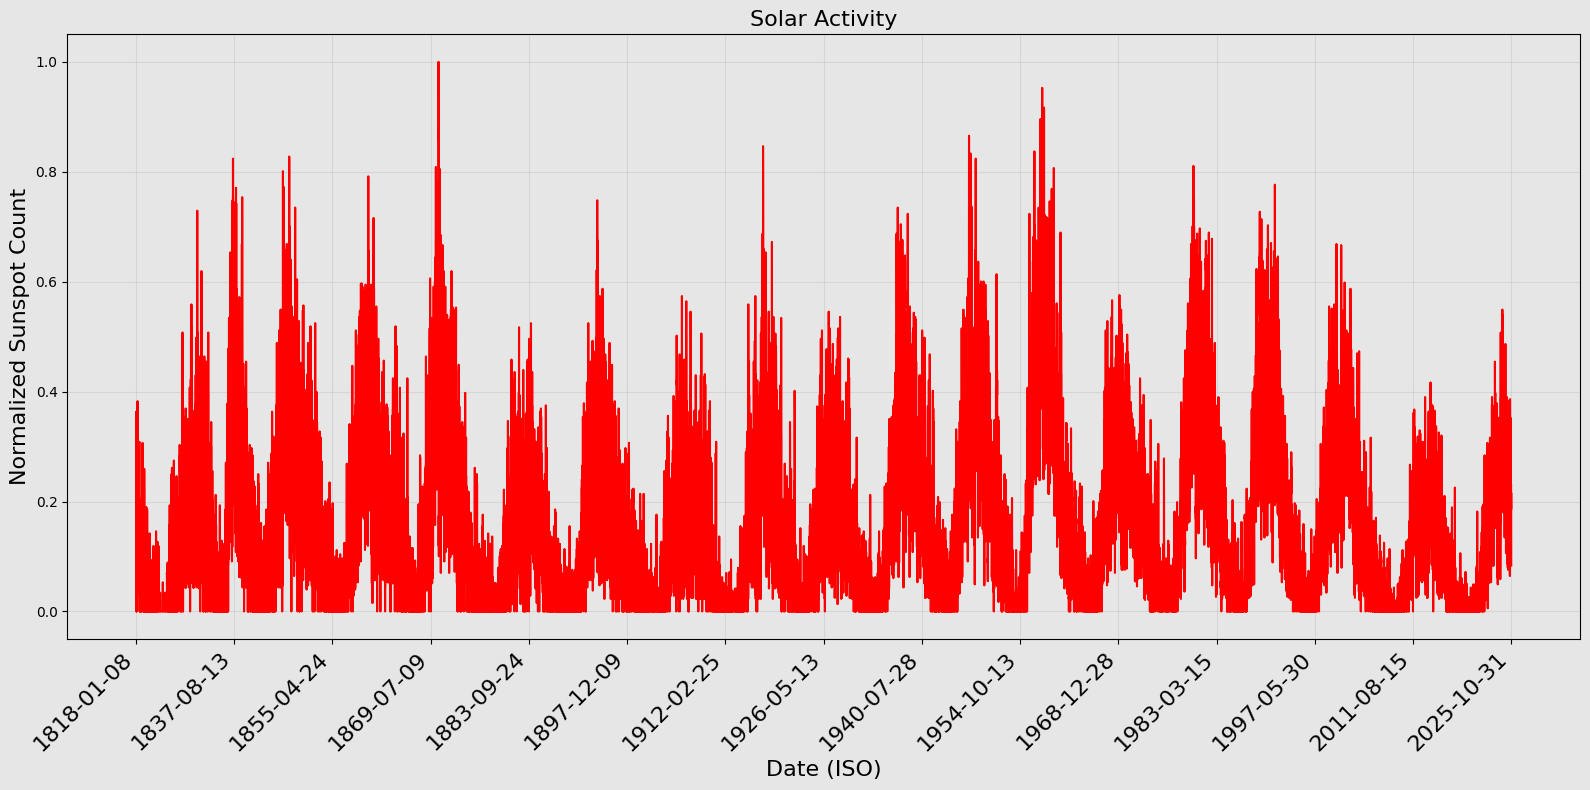

In [30]:
plot_facecolor = (0.902, 0.902, 0.902)

fig, ax = plt.subplots(figsize=(16,8), facecolor=plot_facecolor)
ax.plot(timearray_iso, tranquility, 'r-', linewidth=1.5, label='Solar Activity')

# Set only 10 x-ticks with ISO format labels
tick_indices = np.linspace(0, len(timearray_iso)-1, 15, dtype=int)
ax.set_xticks(timearray_iso[tick_indices])
ax.set_xticklabels([timearray_iso[i][:10] for i in tick_indices], rotation=45, ha='right', fontsize=16)

ax.set_xlabel('Date (ISO)', fontsize=16)
ax.set_ylabel("Normalized Sunspot Count", fontsize=16)
ax.get_yaxis().set_visible(True)  # Turn off y-axis
ax.set_title('Solar Activity', fontsize=16)
ax.grid(True, alpha=0.3)
ax.set_facecolor(plot_facecolor)
plt.tight_layout()
plt.savefig("../figures/full_tranquility.png")
plt.savefig('../literature/our_work/full_tranquility.png')

We see the dominant 11-year solar cycle. We will detrend this 11-year cycle to determine the underlying statistical distribution

In [ ]:
# Detrend using high-pass butterworth filter
cutoff_period = 9 * 365 
sampling_interval = np.median(np.diff(timearray_jd.values))

# Nyquist freq
nyquist = 1 / ( 2 * sampling_interval)

# Cutoff freq
cutoff_freq = 1 / cutoff_period

# Sampling frequency
sampling_freq = 1 / sampling_interval

# normalize by nyquist
normalized_cutoff = cutoff_freq / nyquist
print(f"cutoff: {cutoff_freq}   norm_cutoff: {normalized_cutoff}")

# Design butterworth high-pass filter
order = 4
b,a = scipy.signal.butter(order, normalized_cutoff, btype='highpass', analog=False, fs = sampling_freq)

# Apply the filter
filtered_tranquility = scipy.signal.filtfilt(b,a,tranquility.values)

In [ ]:
detrended_tranquility = filtered_tranquility

fig, ax = plt.subplots(2,1, figsize=(16,8), facecolor=plot_facecolor)
ax[0].plot(timearray_iso, detrended_tranquility, 'r-', linewidth=1.5, label='Solar Tranquility (detrended)')

# Set only 10 x-ticks with ISO format labels
tick_indices = np.linspace(0, len(timearray_iso)-1, 15, dtype=int)
ax[0].set_xticks(timearray_iso[tick_indices])
ax[0].set_xticklabels([timearray_iso[i][:10] for i in tick_indices], rotation=45, ha='right', fontsize=16)

ax[0].set_xlabel('Date (ISO)', fontsize=16)
ax[0].get_yaxis().set_visible(True)  # Turn off y-axis
ax[0].set_title('Solar Activity', fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True, alpha=0.3)
ax[0].set_facecolor(plot_facecolor)

n_bins = int((timearray_jd.values[-1] - timearray_jd.values[0]) / 30) # 30 day bin size

vals, bins, patches = ax[1].hist(detrended_tranquility, bins=n_bins, density=True, alpha=0.7, stacked = True)
ax[1].set_xlabel("Detrended Activity", fontsize=16)
ax[1].set_ylabel("Probability Density", fontsize=16)
ax[1].set_facecolor(plot_facecolor)
ax[1].grid(True, alpha=0.4)
plt.tight_layout()

print(f"Mean: {np.mean(detrended_tranquility):.3f}")
print(f"Std Dev: {np.std(detrended_tranquility):.3f}")
print(f"Skewness: {scipy.stats.skew(detrended_tranquility):.3f}")
print(f"Kurtosis: {scipy.stats.kurtosis(detrended_tranquility):.3f}")
print(f"    Excess: {scipy.stats.kurtosis(detrended_tranquility) - 3:.3f}")



plt.savefig("../figures/detrended_tranquility.png")
plt.savefig('../literature/our_work/detrended_tranquility.png')

We now analyze the statistical attributes of the distribution as a function of the high-pass filter cutoff

In [ ]:
def get_stats(cutoff_period_years):
    cutoff_period = cutoff_period_years * 365 
    sampling_interval = np.median(np.diff(timearray_jd.values))

    # Nyquist freq
    nyquist = 1 / ( 2 * sampling_interval)

    # Cutoff freq
    cutoff_freq = 1 / cutoff_period

    # normalize by nyquist
    normalized_cutoff = cutoff_freq / nyquist

    # Design butterworth high-pass filter
    order = 4
    b,a = scipy.signal.butter(order, normalized_cutoff, btype='high', analog=False)

    # Apply the filter
    filttranq = scipy.signal.filtfilt(b,a,tranquility.values)

    stats = {
        'cutoff_year': cutoff_period_years,
        'mean': np.mean(filttranq),
        'std': np.std(filttranq),
        'skew': scipy.stats.skew(filttranq),
        'kurt': scipy.stats.kurtosis(filttranq),
        'exckurt': scipy.stats.kurtosis(filttranq) - 3
    }

    return stats

stats = [get_stats(cut) for cut in np.linspace(362 / (6*30),14, 5000, dtype=np.float64)]

years = [info['cutoff_year'] for info in stats]
means = [info['mean'] for info in stats]
stds = [info['std'] for info in stats]
skews = [info['skew'] for info in stats]
kurts = [info['kurt'] for info in stats]
exkurts = [info['exckurt'] for info in stats]

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(2, 2, figsize=(16,8))

# ===================== PANEL 1: mean =====================
ax[0,0].plot(years, means, color='black')
ax[0,0].set_xlabel("Years")
ax[0,0].set_ylabel("mean")
ax[0,0].grid(True, alpha=0.4)

# inset for mean
#axins = ax[0,0].inset_axes([0.15, 0.2, 0.40, 0.35])  # [left, bottom, width, height]
#axins.plot(years, means, color='black')
#axins.set_xlim(2, 3)
#axins.set_ylim(-0.0001, 0)
#axins.grid(True, alpha = 0.3)
#axins.set_xticks([]), axins.set_yticks([])

#mark_inset(ax[0,0], axins, loc1=3, loc2=1, fc="none", ec="0.5")

# ===================== PANEL 2: std =====================
ax[0,1].plot(years, stds, color='black')
ax[0,1].set_xlabel("Years")
ax[0,1].set_ylabel("standard deviation")
ax[0,1].grid(True, alpha=0.4)

#axins = ax[0,1].inset_axes([0.10, 0.50, 0.45, 0.35])
#axins.plot(years, stds, color='black')
#axins.yaxis.tick_right()
#axins.xaxis.set_major_locator(MaxNLocator(nbins=4))
#plt.setp(axins.get_xticklabels(), rotation=45, ha='right')
#axins.grid(True, alpha = 0.3)
#axins.set_xlim(2, 3)
#axins.set_ylim(0.065, 0.078)

#mark_inset(ax[0,1], axins, loc1=2, loc2=4, fc="none", ec="0.2")

# ===================== PANEL 3: skew =====================
ax[1,0].plot(years, skews, color='black')
ax[1,0].set_xlabel("Years")
ax[1,0].set_ylabel("skewness")
ax[1,0].grid(True, alpha=0.4)

#axins = ax[1,0].inset_axes([0.55, 0.5, 0.40, 0.35])
#axins.plot(years, skews, color='black')
#axins.xaxis.set_major_locator(MaxNLocator(nbins=4))
#plt.setp(axins.get_xticklabels(), rotation=45, ha='right')
#axins.grid(True, alpha = 0.3)
#axins.set_xlim(2, 3)
#axins.set_ylim(-0.65, -0.40)
#axins.set_xticks([]), axins.set_yticks([])

#mark_inset(ax[1,0], axins, loc1=2, loc2=4, fc="none", ec="0.5")

# ===================== PANEL 4: excess kurtosis =====================
ax[1,1].plot(years, exkurts, color='black')
ax[1,1].set_xlabel("Years")
ax[1,1].set_ylabel("excess kurtosis")
ax[1,1].grid(True, alpha=0.4)

#axins = ax[1,1].inset_axes([0.3, 0.15, 0.40, 0.35])
#axins.plot(years, exkurts, color='black')
#axins.xaxis.set_major_locator(MaxNLocator(nbins=4))
#plt.setp(axins.get_xticklabels(), rotation=45, ha='right')
#axins.grid(True, alpha = 0.3)
#axins.set_xlim(2, 3)
#axins.set_ylim(-0.75, -0.5)
#axins.set_xticks([]), axins.set_yticks([])

#mark_inset(ax[1,1], axins, loc1=1, loc2=3, fc="none", ec="0.5");


plt.savefig("../figures/dist_stats.png")
plt.savefig('../literature/our_work/dist_stats.png')

## Wavelet Analysis

To better understand the periodicities, we also compute the wavelet transformation

In [ ]:
#Mask to get rid of NaN jumps
MASK = timearray_iso > Time('1850-01-01', format='iso')

timearray = timearray_jd[MASK]
tran = tranquility[MASK].values

# Ensure the data is evenly spaced
if not max(np.diff(timearray)) == min(np.diff(timearray)):
    print(f"{FancyColors.IMPORTANT}ERROR! Data is inhomogeneously spaced!")

dt = timearray.values[1] - timearray.values[0]
s0 = 2 * dt
dj = 1/12
J = int(np.log2(len(timearray) * dt / s0) / dj)
print(f"starting scale {s0}")
print(f"Scale spacing: {dj}")
print(f"number scales {J}")
print(f"time spacing {dt}")

Wx, scales, freqs, coi_x, fft, fftfreqs = wavelet.cwt(
    tran,
    dt,
    dj,
    s0,
    J,
    wavelet = wavelet.Morlet(6)
)

power = (np.abs(Wx))**2

period = 1/freqs * (1/365)
T,P = np.meshgrid(timearray, period)

print(f"Period range: {period.min():.2f} to {period.max():.2f} years")

In [ ]:
# Perform alost a 95 confidence level significance test

# Compute Lag-1 autocorrelation coefficient
alpha,_,_ = wavelet.ar1(tran)
print(f" Alpha coefficient: {alpha}")

signif, fft_theor = wavelet.significance(
    tran,
    dt,
    scales,
    sigma_test = 0,
    alpha = alpha,
    significance_level = 0.95, 
    wavelet=wavelet.Morlet(6)
)

signif_2D = np.tile(signif[:, np.newaxis], (1, power.shape[1]))

sig95 = signif[:,None] * np.ones_like(power)
ratio = power / sig95

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Setup the xticks
tick_indices = np.linspace(0, len(timearray)-1, 10, dtype=int)
xticks = timearray.values[tick_indices]
xtick_labels = [tick[:10] for tick in Time(xticks, format='jd').iso]

fig, ax = plt.subplots(3,1,figsize=(20,22), facecolor=plot_facecolor)
plot = ax[0].pcolormesh(T,P,power, shading='auto', cmap='viridis')
cont_plot = ax[0].contour(
    T,P, ratio,
    levels=[1],
    colors='black',
    linewidths=1.
)
# Set only 10 x-ticks with ISO format labels
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=18)

ax[0].set_yscale("log")
ax[0].set_ylabel("Period [yr]", fontsize=18)
ax[0].set_title("Wavelet transform of Solar Activity", fontsize=18)
cbar = plt.colorbar(plot, ax = ax[0], orientation='vertical', label='Power Spectrum')
cbar.ax.yaxis.label.set_size(16)   # set font size

plot = ax[1].pcolormesh(T,P,np.log10(power), shading='auto', cmap='viridis')
ax[1].contour(
    T,P, ratio,
    levels=[1],
    colors='black',
    linewidths=1.
)
# Set only 10 x-ticks with ISO format labels
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=18)

ax[1].set_yscale("log")
ax[1].set_ylabel("Period [yr]", fontsize=18)
ax[1].set_title("Wavelet transform of Solar Activity (log)", fontsize=18)
cbar = plt.colorbar(plot, ax = ax[1], orientation='vertical', label='Log Power Spectrum')
cbar.ax.yaxis.label.set_size(16)   # set font size

time_min = Time("1930-01-01", format='iso').jd
time_max = Time("2020-01-01", format='iso').jd
axins_xticks = timearray.values[(timearray.values>time_min)&(timearray.values<time_max)][::6500]
axins_xtick_labels = [tick[:10] for tick in Time(axins_xticks, format='jd').iso]
axins = ax[1].inset_axes([0.1, 0.6, 0.35, 0.3])
axins.pcolormesh(T,P,np.log10(power), shading='auto', cmap='viridis')
axins.set_xlim(time_min, time_max)
axins.set_xticks(axins_xticks)
axins.set_xticklabels(axins_xtick_labels, rotation=45, ha='right', fontsize=18)
axins.set_ylim(0.02, .6)
axins.tick_params(labelsize=10)
axins.set_yscale("log")
mark_inset(ax[1], axins, loc1=1, loc2=3, fc="none", ec="0.5")

ax[2].plot(timearray.values, tran, color='blue', linewidth=1)
ax[2].set_xlabel("Dates (iso)", fontsize=18)
ax[2].set_ylabel("Activity", fontsize=18)
ax[2].set_title("Solar Activity over Epochs", fontsize=18)
ax[2].set_xticks(xticks)
ax[2].set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=18)
ax[2].set_xlim(timearray.values[0], timearray.values[-1])
ax[2].set_facecolor("lightgray")

# Iterate over the events and indicate them on the wavelet plot
import matplotlib, copy
for event in tranq_var_rat_pre:
    start = event['start_time']
    end = event['end_time']
    #Get midpoint
    midtime = (start+end)/2
    # Compute duration of event (conver to years)
    period = (end-start) / 365

    ellipse = matplotlib.patches.Ellipse(
        (midtime, period),
        width = period,
        height = period * 0.2,
        alpha = 0.8,
        facecolor = 'blue',
        edgecolor = 'black',
        linewidth = 2
    )

    ellipse2 = matplotlib.patches.Ellipse(
        (midtime, period),
        width = period,
        height = period * 0.2,
        alpha = 0.4,
        facecolor = 'blue',
        edgecolor = 'black',
        linewidth = 2
    )
    ellipse3 = matplotlib.patches.Ellipse(
        (midtime, period),
        width = period,
        height = period * 0.2,
        alpha = 0.4,
        facecolor = 'blue',
        edgecolor = 'black',
        linewidth = 2
    )
    ax[0].add_patch(ellipse)
    ax[1].add_patch(ellipse2)
    axins.add_patch(ellipse3)


ax[2].grid(True, alpha=0.3)
ax[1].grid(True, alpha=0.3)
ax[0].grid(True, alpha=0.3)
plt.tight_layout()

# Align bottom plot to top plots
pos0 = ax[1].get_position()
pos1 = ax[2].get_position()
ax[2].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])

plt.savefig("../figures/tranq_cwt.png")
plt.savefig('../literature/our_work/tranq_cwt.png')

# Sub-dominant Wavelet Analysis

We filter out the large 11-year cycle

In [ ]:
#Mask to get rid of NaN jumps
MASK = timearray_iso > Time('1850-01-01', format='iso')

timearray = timearray_jd[MASK]
tran = tranquility[MASK].values

# Detrend using high-pass butterworth filter
cutoff_period = 9 * 365 
sampling_interval = np.median(np.diff(timearray))

# Nyquist freq
nyquist = 1 / ( 2 * sampling_interval)

# Cutoff freq
cutoff_freq = 1 / cutoff_period

# Sampling frequency
sampling_freq = 1 / sampling_interval

# normalize by nyquist
normalized_cutoff = cutoff_freq / nyquist
print(f"cutoff: {cutoff_freq}   norm_cutoff: {normalized_cutoff}")

# Design butterworth high-pass filter
order = 4
b,a = scipy.signal.butter(order, normalized_cutoff, btype='highpass', analog=False, fs = sampling_freq)

# Apply the filter
filtered_tranquility = scipy.signal.filtfilt(b,a,tran)

# Ensure the data is evenly spaced
if not max(np.diff(timearray)) == min(np.diff(timearray)):
    print(f"{FancyColors.IMPORTANT}ERROR! Data is inhomogeneously spaced!")

dt = timearray.values[1] - timearray.values[0]
s0 = 2 * dt
dj = 1/12
J = int(np.log2(len(timearray) * dt / s0) / dj)
print(f"starting scale {s0}")
print(f"Scale spacing: {dj}")
print(f"number scales {J}")
print(f"time spacing {dt}")

Wx, scales, freqs, coi_x, fft, fftfreqs = wavelet.cwt(
    filtered_tranquility,
    dt,
    dj,
    s0,
    J,
    wavelet = wavelet.Morlet(6)
)

power = (np.abs(Wx))**2

period = 1/freqs * (1/365)
T,P = np.meshgrid(timearray, period)

print(f"Period range: {period.min():.2f} to {period.max():.2f} years")

In [ ]:
# Perform alost a 95 confidence level significance test

# Compute Lag-1 autocorrelation coefficient
alpha,_,_ = wavelet.ar1(filtered_tranquility)
print(f" Alpha coefficient: {alpha}")

signif, fft_theor = wavelet.significance(
    filtered_tranquility,
    dt,
    scales,
    sigma_test = 0,
    alpha = alpha,
    significance_level = 0.95, 
    wavelet=wavelet.Morlet(6)
)

signif_2D = np.tile(signif[:, np.newaxis], (1, power.shape[1]))

sig95 = signif[:,None] * np.ones_like(power)
ratio = power / sig95

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Setup the xticks
tick_indices = np.linspace(0, len(timearray)-1, 10, dtype=int)
xticks = timearray.values[tick_indices]
xtick_labels = [tick[:10] for tick in Time(xticks, format='jd').iso]

fig, ax = plt.subplots(3,1,figsize=(20,22), facecolor=plot_facecolor)
plot = ax[0].pcolormesh(T,P,power, shading='auto', cmap='viridis')
ax[0].contour(
    T,P, ratio,
    levels=[1],
    colors='black',
    linewidths=0.5,
)
# Set only 10 x-ticks with ISO format labels
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=16)

ax[0].set_yscale("log")
ax[0].set_ylabel("Period [yr]", fontsize=16)
ax[0].set_title("Wavelet transform of Solar Activity", fontsize=16)
plt.colorbar(plot, ax = ax[0], orientation='vertical', label='Power Spectrum')

plot = ax[1].pcolormesh(T,P,np.log10(power), shading='auto', cmap='viridis')
ax[1].contour(
    T,P, ratio,
    levels=[1],
    colors='black',
    linewidths=0.5,
)
# Set only 10 x-ticks with ISO format labels
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=16)

ax[1].set_yscale("log")
ax[1].set_ylabel("Period [yr]", fontsize=16)
ax[1].set_title("Wavelet transform of Solar Activity (log)", fontsize=16)
plt.colorbar(plot, ax = ax[1], orientation='vertical', label='Log Power Spectrum')

time_min = Time("1930-01-01", format='iso').jd
time_max = Time("2020-01-01", format='iso').jd
axins_xticks = timearray.values[(timearray.values>time_min)&(timearray.values<time_max)][::6500]
axins_xtick_labels = [tick[:10] for tick in Time(axins_xticks, format='jd').iso]
axins = ax[1].inset_axes([0.1, 0.6, 0.35, 0.3])
axins.pcolormesh(T,P,np.log10(power), shading='auto', cmap='viridis')
axins.contour(
    T,P, ratio,
    levels=[1],
    colors='black',
    linewidths=0.5,
)
axins.set_xlim(time_min, time_max)
axins.set_xticks(axins_xticks)
axins.set_xticklabels(axins_xtick_labels, rotation=45, ha='right', fontsize=16)
axins.set_ylim(0.02, .6)
axins.tick_params(labelsize=10)
axins.set_yscale("log")
mark_inset(ax[1], axins, loc1=1, loc2=3, fc="none", ec="0.5")

ax[2].plot(timearray.values, filtered_tranquility, color='blue', linewidth=1)
ax[2].set_xlabel("Dates (iso)", fontsize=16)
ax[2].set_ylabel("Activity", fontsize=16)
ax[2].set_title("Solar Activity over Epochs", fontsize=16)
ax[2].set_xticks(xticks)
ax[2].set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=16)
ax[2].set_xlim(timearray.values[0], timearray.values[-1])
ax[2].set_facecolor("lightgray")

# Iterate over the events and indicate them on the wavelet plot
import matplotlib, copy
for event in tranq_var_rat_pre:
    start = event['start_time']
    end = event['end_time']
    #Get midpoint
    midtime = (start+end)/2
    # Compute duration of event (conver to years)
    period = (end-start) / 365

    ellipse = matplotlib.patches.Ellipse(
        (midtime, period),
        width = period,
        height = period * 0.2,
        alpha = 0.8,
        facecolor = 'blue',
        edgecolor = 'red',
        linewidth = 2
    )

    ellipse2 = matplotlib.patches.Ellipse(
        (midtime, period),
        width = period,
        height = period * 0.2,
        alpha = 0.4,
        facecolor = 'blue',
        edgecolor = 'red',
        linewidth = 2
    )
    ellipse3 = matplotlib.patches.Ellipse(
        (midtime, period),
        width = period,
        height = period * 0.2,
        alpha = 0.4,
        facecolor = 'blue',
        edgecolor = 'red',
        linewidth = 2
    )
    ax[0].add_patch(ellipse)
    ax[1].add_patch(ellipse2)
    axins.add_patch(ellipse3)


ax[2].grid(True, alpha=0.3)
ax[1].grid(True, alpha=0.3)
ax[0].grid(True, alpha=0.3)
plt.tight_layout()

# Align bottom plot to top plots
pos0 = ax[1].get_position()
pos1 = ax[2].get_position()
ax[2].set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])

plt.savefig("../figures/subdom_tranq_cwt.png")
plt.savefig('../literature/our_work/subdom_tranq_cwt.png')